In [4]:
import os
import sys
import time
import time
import warnings
import datetime
import itertools
from glob import glob

import librosa
import numpy as np
from spleeter.separator import Separator
from spleeter.audio import STFTBackend
import tensorflow as tf
from sklearn.linear_model import LinearRegression
import IPython.display as ipd

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [5]:
genres_dict = {
    'Hip-Hop': 0,
    'Pop': 1,
    'Rock': 2,
    'Folk': 3,
    'Experimental': 4,
    'Jazz': 5,
    'Electronic': 6,
    'International': 7,
    'Soul-RnB': 8,
    'Blues': 9,
    'Spoken': 10,
    'Country': 11,
    'Classical': 12,
    'Old-Time / Historic': 13,
    'Instrumental': 14,
    'Easy Listening': 15
}

channel_labels = ["vocals", "drums", "bass", "other"]

In [6]:
def load_dataset(dataset_path, target_genre):
    x_test, y_test = [], []
    for file in glob(f'{dataset_path}/arr_test_*.npz'):
        npzfile = np.load(file, allow_pickle=True)
        x_test.append(npzfile['arr_0'])
        y_test.append(npzfile['arr_1'])

    print('Concatenate Test Data...')
    x_test = np.concatenate(x_test, axis=0)
    y_test = np.concatenate(y_test, axis=0)

    return list(filter(lambda x: x[1] == genres_dict[target_genre], zip(x_test, y_test)))

def load_tensorflow_model(model_path):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return tf.keras.models.load_model(model_path, custom_objects={'tf': tf})


def explain_snippets(x_test, target_genre, model):
    # Create Channel permutation to test and remove empty and full permutation
    l = [0,1]
    z_ = list(itertools.product(l, repeat=4))
    z_.remove((0,0,0,0))
    z_.remove((1,1,1,1))

    snippet_data = []
    for index, (x, y) in enumerate(x_test):
        print(f'Snippet number {index + 1}')
        del x['original']
        x = list(x.values())
        Z_y = []
        
        # Get prediction for full input
        full_prediction = model.predict(np.array([x]))
        full_predictet_confidence = np.amax(np.squeeze(full_prediction))
        full_predictet_label = list(
            genres_dict.keys())[
            list(genres_dict
                 .values())
            .index(
                np.argmax(
                    np.squeeze(full_prediction)
                )
            )
        ]
        
        
        print(f'Predicted {full_predictet_label} with confidence of {full_predictet_confidence}')
        
        if genres_dict[target_genre] != np.argmax(np.squeeze(full_prediction)):
            print('Not Target Genre ... continue')
            continue
        
        
        # Create Sample and get label for prediction
        for permutation in list(z_):
            z = np.copy(x)
            for index, value in enumerate(permutation):
                if value == 0:
                    z[index] = np.full((z[index].shape[0], z[index].shape[1]), -80)
            z_prediction = model.predict(np.array([z]))
            
            # Get most confident value
            predictet_label = np.argmax(np.squeeze(z_prediction))
            Z_y.append(np.squeeze(z_prediction)[genres_dict[full_predictet_label]])
            print(f'Model predictet {list(genres_dict.keys())[list(genres_dict.values()).index(predictet_label)]} for permutation {permutation}; Target label with {np.squeeze(z_prediction)[genres_dict[full_predictet_label]]}')

        # Train explainable model for 
        reg = LinearRegression()
        reg.fit(z_, Z_y)

        snippet_data.append({
            "weights": reg.coef_,
            "label": full_predictet_label,
            "confidence": full_predictet_confidence
        })

    return snippet_data

def evalate_explanations(snippet_explanations):
    fig, ax = plt.subplots()
    cmap = mpl.cm.viridis
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    
    channel_explanation = channel_labels.copy()
    channel_explanation.append('global pred.')
    
    print(f'Number of Explanations: {len(snippet_explanations)}')
    
    for explanation in snippet_explanations:
        weights = np.append(explanation['weights'], explanation['confidence'])
        ax.plot(
            channel_explanation,
            weights,
            c=cmap(explanation['confidence'])
        )
        ax.legend()
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    fig.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=cax,
        orientation='vertical',
        label='global prediction'
    )
    
    plt.show()


def preprocess_instance_snippet(dataset_path, target_genre, model_path):
    spectrogram_snippets = load_dataset(dataset_path, target_genre)
    model = load_tensorflow_model(model_path)
    snippet_explanations = explain_snippets(spectrogram_snippets, target_genre, model)
    evalate_explanations(snippet_explanations)
    

In [7]:
dataset_path = os.path.join('/data','Deathweight','test_data')
model_path = os.path.join('/data', 'logs','DropOriginalMultiChannelParallelCRNN','fma_medium_SpleeterGPUPreprocessor_spleeter:4stems_keepOriginal_LibrosaCPUSTFT','10-03-2022-14-25-21','trained_model')

Concatenate Test Data...
Snippet number 1
Predicted Instrumental with confidence of 0.24910153448581696
Not Target Genre ... continue
Snippet number 2
Predicted Rock with confidence of 0.3985982835292816
Not Target Genre ... continue
Snippet number 3
Predicted Instrumental with confidence of 0.787013590335846
Not Target Genre ... continue
Snippet number 4
Predicted Rock with confidence of 0.38610392808914185
Not Target Genre ... continue
Snippet number 5
Predicted Rock with confidence of 0.3736230134963989
Not Target Genre ... continue
Snippet number 6
Predicted Instrumental with confidence of 0.277596652507782
Not Target Genre ... continue
Snippet number 7
Predicted Experimental with confidence of 0.2805003821849823
Not Target Genre ... continue
Snippet number 8
Predicted Electronic with confidence of 0.34266555309295654
Not Target Genre ... continue
Snippet number 9
Predicted Electronic with confidence of 0.38996416330337524
Not Target Genre ... continue
Snippet number 10
Predicted C

Predicted Rock with confidence of 0.7554381489753723
Not Target Genre ... continue
Snippet number 34
Predicted Rock with confidence of 0.4888552725315094
Not Target Genre ... continue
Snippet number 35
Predicted Jazz with confidence of 0.34052154421806335
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.001491977833211422
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.019112274050712585
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.00971386767923832
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.15259292721748352
Model predictet International for permutation (0, 1, 0, 1); Target label with 0.2846790552139282
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.2852572798728943
Model predictet Jazz for permutation (0, 1, 1, 1); Target label with 0.43256551027297974
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.029541723430156708
M

Model predictet Jazz for permutation (0, 1, 0, 1); Target label with 0.238132506608963
Model predictet Experimental for permutation (0, 1, 1, 0); Target label with 0.05422276630997658
Model predictet Jazz for permutation (0, 1, 1, 1); Target label with 0.22086359560489655
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.02037166804075241
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.0735548809170723
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.014851775951683521
Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.1218399628996849
Model predictet Experimental for permutation (1, 1, 0, 0); Target label with 0.05432413890957832
Model predictet Jazz for permutation (1, 1, 0, 1); Target label with 0.22321243584156036
Model predictet Experimental for permutation (1, 1, 1, 0); Target label with 0.037731196731328964
Snippet number 49
Predicted Folk with confidence of 0.4286048710

Model predictet Jazz for permutation (1, 1, 0, 1); Target label with 0.6619734764099121
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.05065472424030304
Snippet number 74
Predicted Jazz with confidence of 0.8402697443962097
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.023768210783600807
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.030662380158901215
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.035007454454898834
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.06501560658216476
Model predictet Jazz for permutation (0, 1, 0, 1); Target label with 0.7558407783508301
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.10539379715919495
Model predictet Jazz for permutation (0, 1, 1, 1); Target label with 0.8570247292518616
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.02462774515151977

Model predictet Jazz for permutation (1, 1, 0, 1); Target label with 0.7646209001541138
Model predictet Instrumental for permutation (1, 1, 1, 0); Target label with 0.05665355548262596
Snippet number 80
Predicted Jazz with confidence of 0.8873652219772339
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.044119060039520264
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.030653394758701324
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.20034028589725494
Model predictet Instrumental for permutation (0, 1, 0, 0); Target label with 0.029965367168188095
Model predictet Jazz for permutation (0, 1, 0, 1); Target label with 0.7035669088363647
Model predictet Instrumental for permutation (0, 1, 1, 0); Target label with 0.0959593802690506
Model predictet Jazz for permutation (0, 1, 1, 1); Target label with 0.8983439207077026
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.035089951008

Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.019717782735824585
Snippet number 90
Predicted International with confidence of 0.48915761709213257
Not Target Genre ... continue
Snippet number 91
Predicted International with confidence of 0.47572240233421326
Not Target Genre ... continue
Snippet number 92
Predicted Jazz with confidence of 0.8553246855735779
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.06499422341585159
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.037390340119600296
Model predictet Jazz for permutation (0, 0, 1, 1); Target label with 0.45133423805236816
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.05741775408387184
Model predictet Jazz for permutation (0, 1, 0, 1); Target label with 0.8647525906562805
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.20067429542541504
Model predictet Jazz for permutation (0, 1, 1, 1); Target label with 0.9

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

Predicted Folk with confidence of 0.75702965259552
Not Target Genre ... continue
Snippet number 117
Predicted Folk with confidence of 0.4563000500202179
Not Target Genre ... continue
Number of Explanations: 31


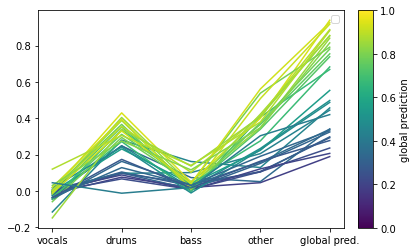

--- Execution Time: 00:24 seconds ---


In [8]:
start_time = time.time()
preprocess_instance_snippet(dataset_path, "Jazz", model_path)
print(f"--- Execution Time: {time.strftime('%M:%S', time.gmtime(time.time() - start_time))} seconds ---")

Concatenate Test Data...
Snippet number 1
Predicted Hip-Hop with confidence of 0.9981207251548767
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.014409191906452179
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.02209988795220852
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.04129166156053543
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.05894185230135918
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.1885441094636917
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.09149183332920074
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.15922336280345917
Model predictet Hip-Hop for permutation (1, 0, 0, 0); Target label with 0.748956561088562
Model predictet Hip-Hop for permutation (1, 0, 0, 1); Target label with 0.9261488318443298
Model predictet Hip-Hop for permutation (1, 0, 1, 0); Ta

Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.8464690446853638
Snippet number 7
Predicted Rock with confidence of 0.3389211595058441
Not Target Genre ... continue
Snippet number 8
Predicted Rock with confidence of 0.6423798203468323
Not Target Genre ... continue
Snippet number 9
Predicted Rock with confidence of 0.5556246042251587
Not Target Genre ... continue
Snippet number 10
Predicted Hip-Hop with confidence of 0.9840238094329834
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.00760488910600543
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.03177228197455406
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.003950581420212984
Model predictet Hip-Hop for permutation (0, 1, 0, 0); Target label with 0.7587149739265442
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.396505206823349
Model predictet Hip-Hop for permutation (0, 1, 1, 0); Target 

Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9993791580200195
Snippet number 16
Predicted Hip-Hop with confidence of 0.9960762858390808
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.028555022552609444
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.032069891691207886
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.03233237937092781
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.16618101298809052
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.22411228716373444
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.20199429988861084
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.24193237721920013
Model predictet Spoken for permutation (1, 0, 0, 0); Target label with 0.3146110475063324
Model predictet Hip-Hop for permutation (1, 0, 0, 1); Target label with 0.6511

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.031779687851667404
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.025156019255518913
Model predictet Instrumental for permutation (0, 1, 0, 0); Target label with 0.047713056206703186
Model predictet Instrumental for permutation (0, 1, 0, 1); Target label with 0.06895440816879272
Model predictet Instrumental for permutation (0, 1, 1, 0); Target label with 0.11075836420059204
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.18270452320575714
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.052767448127269745
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.035888466984033585
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.03199099749326706
Model predictet International for permutation (1, 0, 1, 1); Target label with 0.06452394276857376
Model predictet Hip-Hop for p

Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.2519437074661255
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.3673933148384094
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.052698273211717606
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.05620046332478523
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.07012622058391571
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.12216058373451233
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.4311874806880951
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.5810707807540894
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.702084481716156
Snippet number 31
Predicted Hip-Hop with confidence of 0.9238860607147217
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.01

Model predictet Spoken for permutation (1, 0, 1, 0); Target label with 0.1524687260389328
Model predictet International for permutation (1, 0, 1, 1); Target label with 0.15180031955242157
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.9954356551170349
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.995209276676178
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9946755170822144
Snippet number 39
Predicted Hip-Hop with confidence of 0.9951660633087158
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.01254095509648323
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.02804926410317421
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.027705704793334007
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.12795662879943848
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.125446051

Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.0073287347331643105
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.23933528363704681
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.008267174474895
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.0301124956458807
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.0077617890201509
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.9055618643760681
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.5327801704406738
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.8510921597480774
Snippet number 47
Predicted Folk with confidence of 0.5371695160865784
Not Target Genre ... continue
Snippet number 48
Predicted Folk with confidence of 0.5846700668334961
Not Target Genre ... continue
Snippet number 49
Predicted Hip-Hop with confidenc

Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.8129709362983704
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.9184479713439941
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.929682195186615
Snippet number 55
Predicted Spoken with confidence of 0.4220523238182068
Not Target Genre ... continue
Snippet number 56
Predicted Hip-Hop with confidence of 0.37444108724594116
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.01124283205717802
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.024348370730876923
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.019711751490831375
Model predictet Experimental for permutation (0, 1, 0, 0); Target label with 0.023563863709568977
Model predictet Experimental for permutation (0, 1, 0, 1); Target label with 0.03037126176059246
Model predictet Experimental for permutation (0, 1, 1, 0); Target 

Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.1938915103673935
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.5271967053413391
Snippet number 63
Predicted Hip-Hop with confidence of 0.5397290587425232
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.016353541985154152
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.027577729895710945
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.01953267864882946
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.10677149891853333
Model predictet Instrumental for permutation (0, 1, 0, 1); Target label with 0.05748782679438591
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.1359548717737198
Model predictet Instrumental for permutation (0, 1, 1, 1); Target label with 0.1011066660284996
Model predictet Spoken for permutation (1, 0, 0, 0); Target label with 0.0107644

Model predictet Hip-Hop for permutation (0, 1, 0, 1); Target label with 0.9595546126365662
Model predictet Hip-Hop for permutation (0, 1, 1, 0); Target label with 0.9707193374633789
Model predictet Hip-Hop for permutation (0, 1, 1, 1); Target label with 0.977377712726593
Model predictet Hip-Hop for permutation (1, 0, 0, 0); Target label with 0.7794066667556763
Model predictet Hip-Hop for permutation (1, 0, 0, 1); Target label with 0.5812015533447266
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.36289870738983154
Model predictet International for permutation (1, 0, 1, 1); Target label with 0.29871782660484314
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.9999814033508301
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.9999868869781494
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9999446868896484
Snippet number 70
Predicted Hip-Hop with confidence of 0.6630280017852783
Mod

Model predictet Hip-Hop for permutation (0, 1, 0, 0); Target label with 0.4842369854450226
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.266755610704422
Model predictet Hip-Hop for permutation (0, 1, 1, 0); Target label with 0.6629447340965271
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.3038002848625183
Model predictet International for permutation (1, 0, 0, 0); Target label with 0.0019529988057911396
Model predictet International for permutation (1, 0, 0, 1); Target label with 0.0014095623046159744
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.007269938476383686
Model predictet International for permutation (1, 0, 1, 1); Target label with 0.007173762656748295
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.9264576435089111
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.8835878372192383
Model predictet Hip-Hop for permutation (1, 1, 1, 0

Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.2401747703552246
Model predictet International for permutation (1, 0, 0, 0); Target label with 0.02391623705625534
Model predictet International for permutation (1, 0, 0, 1); Target label with 0.006172133609652519
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.01480917353183031
Model predictet International for permutation (1, 0, 1, 1); Target label with 0.0016646924195811152
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.7997411489486694
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.8924322724342346
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.8016851544380188
Snippet number 83
Predicted Hip-Hop with confidence of 0.951218843460083
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.009427479468286037
Model predictet Electronic for permutation (0, 0, 1, 0); Target label

Model predictet Spoken for permutation (1, 0, 0, 1); Target label with 0.06913242489099503
Model predictet Spoken for permutation (1, 0, 1, 0); Target label with 0.10297928750514984
Model predictet Spoken for permutation (1, 0, 1, 1); Target label with 0.09572271257638931
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.607586681842804
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.8228026628494263
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.5115562677383423
Snippet number 91
Predicted Experimental with confidence of 0.35719606280326843
Not Target Genre ... continue
Snippet number 92
Predicted Rock with confidence of 0.32063689827919006
Not Target Genre ... continue
Snippet number 93
Predicted Electronic with confidence of 0.827672004699707
Not Target Genre ... continue
Snippet number 94
Predicted International with confidence of 0.3583677411079407
Not Target Genre ... continue
Snippet number 95
Predicted

Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.3846927881240845
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.7492230534553528
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.43353521823883057
Snippet number 113
Predicted Hip-Hop with confidence of 0.5242736339569092
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.0064266095869243145
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.0354645699262619
Model predictet Experimental for permutation (0, 0, 1, 1); Target label with 0.0051424247212708
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.01641426607966423
Model predictet International for permutation (0, 1, 0, 1); Target label with 0.011596988886594772
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.024510694667696953
Model predictet International for permutation (0, 1, 1, 1); Target label

Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9995120763778687
Snippet number 120
Predicted Hip-Hop with confidence of 0.9812079668045044
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.003933572210371494
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.025859149172902107
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.004949929658323526
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.06435683369636536
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.02310282364487648
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.08590047806501389
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.04007404297590256
Model predictet Spoken for permutation (1, 0, 0, 0); Target label with 0.2099832147359848
Model predictet Spoken for permutation (1, 0, 0, 1); Target label with 0

Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.006857824511826038
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.018457824364304543
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.008998346514999866
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.2835845947265625
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.24639053642749786
Model predictet Hip-Hop for permutation (0, 1, 1, 0); Target label with 0.5337231159210205
Model predictet Hip-Hop for permutation (0, 1, 1, 1); Target label with 0.497209370136261
Model predictet Hip-Hop for permutation (1, 0, 0, 0); Target label with 0.8872067332267761
Model predictet Hip-Hop for permutation (1, 0, 0, 1); Target label with 0.9219697117805481
Model predictet Hip-Hop for permutation (1, 0, 1, 0); Target label with 0.7025809288024902
Model predictet Hip-Hop for permutation (1, 0, 1, 1); Target la

Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.03082236275076866
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.5127357840538025
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.5852394700050354
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.5990889668464661
Snippet number 152
Predicted Electronic with confidence of 0.6138373017311096
Not Target Genre ... continue
Snippet number 153
Predicted Electronic with confidence of 0.5102930068969727
Not Target Genre ... continue
Snippet number 154
Predicted Electronic with confidence of 0.8651123046875
Not Target Genre ... continue
Snippet number 155
Predicted Electronic with confidence of 0.8672390580177307
Not Target Genre ... continue
Snippet number 156
Predicted Electronic with confidence of 0.841986358165741
Not Target Genre ... continue
Snippet number 157
Predicted Electronic with confidence of 0.8082250356674194
Not Target Genre .

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.03232593834400177
Model predictet Experimental for permutation (0, 0, 1, 1); Target label with 0.01986207626760006
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.12033277750015259
Model predictet International for permutation (0, 1, 0, 1); Target label with 0.04794149100780487
Model predictet Hip-Hop for permutation (0, 1, 1, 0); Target label with 0.26659876108169556
Model predictet International for permutation (0, 1, 1, 1); Target label with 0.29148295521736145
Model predictet Spoken for permutation (1, 0, 0, 0); Target label with 0.3052252233028412
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.07053819298744202
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.1619967371225357
Model predictet International for permutation (1, 0, 1, 1); Target label with 0.0641142725944519
Model predictet Hip-Hop for permutation (1, 

Model predictet Hip-Hop for permutation (0, 1, 0, 0); Target label with 0.4090980887413025
Model predictet Hip-Hop for permutation (0, 1, 0, 1); Target label with 0.4160250127315521
Model predictet Hip-Hop for permutation (0, 1, 1, 0); Target label with 0.671374499797821
Model predictet Hip-Hop for permutation (0, 1, 1, 1); Target label with 0.5871374607086182
Model predictet Hip-Hop for permutation (1, 0, 0, 0); Target label with 0.8911324739456177
Model predictet Hip-Hop for permutation (1, 0, 0, 1); Target label with 0.9885619878768921
Model predictet Hip-Hop for permutation (1, 0, 1, 0); Target label with 0.9875389337539673
Model predictet Hip-Hop for permutation (1, 0, 1, 1); Target label with 0.9926885962486267
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.9999648332595825
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.9999803304672241
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9999812841415405


Model predictet Spoken for permutation (1, 0, 1, 1); Target label with 0.159852996468544
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.9937158226966858
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.9882668852806091
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9795911312103271
Snippet number 204
Predicted Rock with confidence of 0.3292153775691986
Not Target Genre ... continue
Snippet number 205
Predicted Hip-Hop with confidence of 0.9993732571601868
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.003729186486452818
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.029915325343608856
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.008237781003117561
Model predictet Hip-Hop for permutation (0, 1, 0, 0); Target label with 0.714137613773346
Model predictet Hip-Hop for permutation (0, 1, 0, 1); Target label with 0.5744571

Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.15969815850257874
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.18760192394256592
Model predictet Hip-Hop for permutation (0, 1, 1, 0); Target label with 0.3238527178764343
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.25841909646987915
Model predictet Spoken for permutation (1, 0, 0, 0); Target label with 0.2126779854297638
Model predictet International for permutation (1, 0, 0, 1); Target label with 0.05603548139333725
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.18786677718162537
Model predictet International for permutation (1, 0, 1, 1); Target label with 0.09096824377775192
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.9985387325286865
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.9986615180969238
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Targ

Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.9979829788208008
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.9967091083526611
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9991058707237244
Snippet number 218
Predicted Hip-Hop with confidence of 0.9990322589874268
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.0023763971403241158
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.03861920163035393
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.00926388893276453
Model predictet Hip-Hop for permutation (0, 1, 0, 0); Target label with 0.4272133409976959
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.2602553367614746
Model predictet Hip-Hop for permutation (0, 1, 1, 0); Target label with 0.7681944966316223
Model predictet Hip-Hop for permutation (0, 1, 1, 1); Target label with 0.46965953707

Model predictet Hip-Hop for permutation (0, 1, 0, 1); Target label with 0.6783085465431213
Model predictet Hip-Hop for permutation (0, 1, 1, 0); Target label with 0.828509509563446
Model predictet Hip-Hop for permutation (0, 1, 1, 1); Target label with 0.7907332181930542
Model predictet Folk for permutation (1, 0, 0, 0); Target label with 0.17593544721603394
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.11820948123931885
Model predictet Hip-Hop for permutation (1, 0, 1, 0); Target label with 0.2117024064064026
Model predictet Hip-Hop for permutation (1, 0, 1, 1); Target label with 0.21806739270687103
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.9060035347938538
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.8821839094161987
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9461587071418762
Snippet number 225
Predicted Hip-Hop with confidence of 0.9043428897857666
Model predictet Ele

Model predictet Hip-Hop for permutation (1, 0, 1, 0); Target label with 0.8000828623771667
Model predictet Hip-Hop for permutation (1, 0, 1, 1); Target label with 0.43203550577163696
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.9992584586143494
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.9926371574401855
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9991845488548279
Snippet number 232
Predicted Hip-Hop with confidence of 0.3481498658657074
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.03515418991446495
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.03440230339765549
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.050278790295124054
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.058093924075365067
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.0407935678

Model predictet Hip-Hop for permutation (1, 0, 1, 0); Target label with 0.6810526847839355
Model predictet Hip-Hop for permutation (1, 0, 1, 1); Target label with 0.8415046334266663
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.9999184608459473
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.9999829530715942
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9999681711196899
Snippet number 238
Predicted Electronic with confidence of 0.4199596643447876
Not Target Genre ... continue
Snippet number 239
Predicted Electronic with confidence of 0.5031397342681885
Not Target Genre ... continue
Snippet number 240
Predicted Hip-Hop with confidence of 0.4686044454574585
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.019049957394599915
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.028762919828295708
Model predictet Electronic for permutation (0, 0, 1, 1); Tar

Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.042815107852220535
Model predictet Hip-Hop for permutation (1, 0, 0, 0); Target label with 0.7695285081863403
Model predictet Hip-Hop for permutation (1, 0, 0, 1); Target label with 0.4442594051361084
Model predictet Hip-Hop for permutation (1, 0, 1, 0); Target label with 0.701326847076416
Model predictet Hip-Hop for permutation (1, 0, 1, 1); Target label with 0.3692623972892761
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.999046266078949
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.995862603187561
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9986683130264282
Snippet number 247
Predicted Hip-Hop with confidence of 0.9878584146499634
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.006907422095537186
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.025331933051347733
M

Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.9996545314788818
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.9998093247413635
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9996278285980225
Snippet number 254
Predicted Hip-Hop with confidence of 0.9001869559288025
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.026789167895913124
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.032850656658411026
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.03315882384777069
Model predictet Hip-Hop for permutation (0, 1, 0, 0); Target label with 0.37970805168151855
Model predictet Hip-Hop for permutation (0, 1, 0, 1); Target label with 0.36329948902130127
Model predictet Hip-Hop for permutation (0, 1, 1, 0); Target label with 0.5609258413314819
Model predictet Hip-Hop for permutation (0, 1, 1, 1); Target label with 0.5057164430618286

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.03442869335412979
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.004980240948498249
Model predictet Hip-Hop for permutation (0, 1, 0, 0); Target label with 0.5088798403739929
Model predictet Hip-Hop for permutation (0, 1, 0, 1); Target label with 0.48949721455574036
Model predictet Hip-Hop for permutation (0, 1, 1, 0); Target label with 0.49911731481552124
Model predictet Hip-Hop for permutation (0, 1, 1, 1); Target label with 0.573689341545105
Model predictet Hip-Hop for permutation (1, 0, 0, 0); Target label with 0.7720312476158142
Model predictet Hip-Hop for permutation (1, 0, 0, 1); Target label with 0.8302927613258362
Model predictet Hip-Hop for permutation (1, 0, 1, 0); Target label with 0.7453442215919495
Model predictet Hip-Hop for permutation (1, 0, 1, 1); Target label with 0.728924036026001
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.99994

Model predictet Hip-Hop for permutation (0, 1, 0, 0); Target label with 0.7716425657272339
Model predictet Hip-Hop for permutation (0, 1, 0, 1); Target label with 0.6802588701248169
Model predictet Hip-Hop for permutation (0, 1, 1, 0); Target label with 0.8929141759872437
Model predictet Hip-Hop for permutation (0, 1, 1, 1); Target label with 0.7933914065361023
Model predictet International for permutation (1, 0, 0, 0); Target label with 0.017770497128367424
Model predictet International for permutation (1, 0, 0, 1); Target label with 0.00796518661081791
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.029056811705231667
Model predictet International for permutation (1, 0, 1, 1); Target label with 0.037497684359550476
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.8171380162239075
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.7787917256355286
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Targe

Model predictet Experimental for permutation (0, 0, 1, 1); Target label with 0.008139456622302532
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.1792556345462799
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.11508142948150635
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.15952910482883453
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.08072599023580551
Model predictet Hip-Hop for permutation (1, 0, 0, 0); Target label with 0.8408656716346741
Model predictet Hip-Hop for permutation (1, 0, 0, 1); Target label with 0.7041730284690857
Model predictet Hip-Hop for permutation (1, 0, 1, 0); Target label with 0.8177756071090698
Model predictet Hip-Hop for permutation (1, 0, 1, 1); Target label with 0.5286962985992432
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.9987910389900208
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label w

Model predictet Hip-Hop for permutation (0, 1, 1, 0); Target label with 0.3608166575431824
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.31080880761146545
Model predictet Spoken for permutation (1, 0, 0, 0); Target label with 0.11798328906297684
Model predictet International for permutation (1, 0, 0, 1); Target label with 0.16086849570274353
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.04597393050789833
Model predictet International for permutation (1, 0, 1, 1); Target label with 0.04072314128279686
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.9698565006256104
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.9810882806777954
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9115131497383118
Snippet number 286
Predicted Hip-Hop with confidence of 0.9957577586174011
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.01

Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9998189806938171
Snippet number 292
Predicted Hip-Hop with confidence of 0.9990367889404297
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.0007654394721612334
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.027238227427005768
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.001999983098357916
Model predictet Hip-Hop for permutation (0, 1, 0, 0); Target label with 0.5828761458396912
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.3616746664047241
Model predictet Hip-Hop for permutation (0, 1, 1, 0); Target label with 0.7273370623588562
Model predictet Hip-Hop for permutation (0, 1, 1, 1); Target label with 0.5437368750572205
Model predictet Spoken for permutation (1, 0, 0, 0); Target label with 0.27549076080322266
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.182877585291862

Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.02031927928328514
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.028454771265387535
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.016158122569322586
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.15196482837200165
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.015418730676174164
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.15281639993190765
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.01534629799425602
Model predictet Spoken for permutation (1, 0, 0, 0); Target label with 0.15995658934116364
Model predictet Spoken for permutation (1, 0, 0, 1); Target label with 0.1026134267449379
Model predictet Spoken for permutation (1, 0, 1, 0); Target label with 0.17619003355503082
Model predictet Spoken for permutation (1, 0, 1, 1); Target label wi

Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.19646549224853516
Model predictet Hip-Hop for permutation (0, 1, 1, 0); Target label with 0.4821757376194
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.33348238468170166
Model predictet Hip-Hop for permutation (1, 0, 0, 0); Target label with 0.7263232469558716
Model predictet Hip-Hop for permutation (1, 0, 0, 1); Target label with 0.5601487755775452
Model predictet Hip-Hop for permutation (1, 0, 1, 0); Target label with 0.7625178098678589
Model predictet Hip-Hop for permutation (1, 0, 1, 1); Target label with 0.6724725961685181
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.9999035596847534
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.9999009370803833
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9998189806938171
Snippet number 307
Predicted Hip-Hop with confidence of 0.9989089965820312
Model pred

Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.0295869093388319
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.970684826374054
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.8587981462478638
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.960622251033783
Snippet number 313
Predicted Hip-Hop with confidence of 0.9981086254119873
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.0073875621892511845
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.019452445209026337
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.013446200639009476
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.1187218502163887
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.10526373237371445
Model predictet International for permutation (0, 1, 1, 0); Target label with 0.1

Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.714341938495636
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.8731204867362976
Snippet number 319
Predicted Hip-Hop with confidence of 0.9995755553245544
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.005926390178501606
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.029585523530840874
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.013547483831644058
Model predictet Hip-Hop for permutation (0, 1, 0, 0); Target label with 0.6731740236282349
Model predictet Hip-Hop for permutation (0, 1, 0, 1); Target label with 0.5201230645179749
Model predictet Hip-Hop for permutation (0, 1, 1, 0); Target label with 0.7492964267730713
Model predictet Hip-Hop for permutation (0, 1, 1, 1); Target label with 0.5913615822792053
Model predictet Hip-Hop for permutation (1, 0, 0, 0); Target label with 0.77515906095504

Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.2239987552165985
Model predictet Spoken for permutation (1, 0, 0, 0); Target label with 0.31273171305656433
Model predictet Hip-Hop for permutation (1, 0, 0, 1); Target label with 0.3288743197917938
Model predictet Hip-Hop for permutation (1, 0, 1, 0); Target label with 0.2853364944458008
Model predictet Hip-Hop for permutation (1, 0, 1, 1); Target label with 0.3462318480014801
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.8350070118904114
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.8723572492599487
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.8408840298652649
Snippet number 326
Predicted Electronic with confidence of 0.39907532930374146
Not Target Genre ... continue
Snippet number 327
Predicted Classical with confidence of 0.33980217576026917
Not Target Genre ... continue
Snippet number 328
Predicted Hip-Hop with confidence

Model predictet Hip-Hop for permutation (0, 1, 1, 1); Target label with 0.6590482592582703
Model predictet Spoken for permutation (1, 0, 0, 0); Target label with 0.45961055159568787
Model predictet Hip-Hop for permutation (1, 0, 0, 1); Target label with 0.8374141454696655
Model predictet Hip-Hop for permutation (1, 0, 1, 0); Target label with 0.7846826314926147
Model predictet Hip-Hop for permutation (1, 0, 1, 1); Target label with 0.9560385346412659
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.9981890320777893
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.9989796280860901
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9982112646102905
Snippet number 334
Predicted Hip-Hop with confidence of 0.9999986886978149
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.023326164111495018
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.030411068350076675
Mod

Model predictet International for permutation (1, 0, 1, 1); Target label with 0.007363113109022379
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.8456045985221863
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.6099293828010559
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.8792804479598999
Snippet number 340
Predicted Hip-Hop with confidence of 0.9996504783630371
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.028367046266794205
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.023631997406482697
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.032184600830078125
Model predictet Hip-Hop for permutation (0, 1, 0, 0); Target label with 0.4946952164173126
Model predictet Hip-Hop for permutation (0, 1, 0, 1); Target label with 0.5914419889450073
Model predictet Hip-Hop for permutation (0, 1, 1, 0); Target label with 0.6374209

Model predictet International for permutation (1, 0, 1, 1); Target label with 0.24675124883651733
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.995445966720581
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.994178056716919
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9877808094024658
Snippet number 346
Predicted Hip-Hop with confidence of 0.9994828701019287
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.010566852055490017
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.03333989903330803
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.018770067021250725
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.1018606573343277
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.04668906703591347
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0

Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.1103200763463974
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.04753193259239197
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.24268396198749542
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.11896133422851562
Model predictet Spoken for permutation (1, 0, 0, 0); Target label with 0.14400087296962738
Model predictet Spoken for permutation (1, 0, 0, 1); Target label with 0.02742929570376873
Model predictet Spoken for permutation (1, 0, 1, 0); Target label with 0.17660702764987946
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.05740523710846901
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.947539746761322
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.9002039432525635
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.96

Model predictet Spoken for permutation (1, 0, 0, 0); Target label with 0.40796536207199097
Model predictet Hip-Hop for permutation (1, 0, 0, 1); Target label with 0.675317645072937
Model predictet Hip-Hop for permutation (1, 0, 1, 0); Target label with 0.4178653657436371
Model predictet Hip-Hop for permutation (1, 0, 1, 1); Target label with 0.45669183135032654
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.958061695098877
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.9955723285675049
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9688467979431152
Snippet number 362
Predicted Rock with confidence of 0.37159305810928345
Not Target Genre ... continue
Snippet number 363
Predicted Electronic with confidence of 0.5635634660720825
Not Target Genre ... continue
Snippet number 364
Predicted Hip-Hop with confidence of 0.9998719692230225
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.00

Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.028895091265439987
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.02534041926264763
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.027410106733441353
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.09998523443937302
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.17314644157886505
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.12303225696086884
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.19021643698215485
Model predictet Hip-Hop for permutation (1, 0, 0, 0); Target label with 0.5648842453956604
Model predictet Hip-Hop for permutation (1, 0, 0, 1); Target label with 0.8704328536987305
Model predictet Hip-Hop for permutation (1, 0, 1, 0); Target label with 0.6558133959770203
Model predictet Hip-Hop for permutation (1, 0, 1, 1); Target

Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.018691297620534897
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.03494340181350708
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.023328369483351707
Model predictet Hip-Hop for permutation (0, 1, 0, 0); Target label with 0.5937377214431763
Model predictet Hip-Hop for permutation (0, 1, 0, 1); Target label with 0.6912473440170288
Model predictet Hip-Hop for permutation (0, 1, 1, 0); Target label with 0.6661033630371094
Model predictet Hip-Hop for permutation (0, 1, 1, 1); Target label with 0.7386772036552429
Model predictet Hip-Hop for permutation (1, 0, 0, 0); Target label with 0.5936593413352966
Model predictet Hip-Hop for permutation (1, 0, 0, 1); Target label with 0.8516722321510315
Model predictet Hip-Hop for permutation (1, 0, 1, 0); Target label with 0.7079959511756897
Model predictet Hip-Hop for permutation (1, 0, 1, 1); Target label with 0.90

Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.01474257092922926
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.025217805057764053
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.033309292048215866
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.04495006427168846
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.04901890084147453
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.12959066033363342
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.11973575502634048
Model predictet Hip-Hop for permutation (1, 0, 0, 0); Target label with 0.4538213908672333
Model predictet Hip-Hop for permutation (1, 0, 0, 1); Target label with 0.5232048630714417
Model predictet Hip-Hop for permutation (1, 0, 1, 0); Target label with 0.5630484819412231
Model predictet Hip-Hop for permutation (1, 0, 1, 1); Targ

Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.02364472486078739
Model predictet Jazz for permutation (0, 1, 0, 1); Target label with 0.008898704312741756
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.03336797282099724
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.011873767711222172
Model predictet Hip-Hop for permutation (1, 0, 0, 0); Target label with 0.27924010157585144
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.10747271031141281
Model predictet Hip-Hop for permutation (1, 0, 1, 0); Target label with 0.2640182673931122
Model predictet International for permutation (1, 0, 1, 1); Target label with 0.055650901049375534
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.8116675019264221
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.8046112060546875
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target la

Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.01562778651714325
Model predictet Hip-Hop for permutation (0, 1, 0, 0); Target label with 0.4444007873535156
Model predictet Hip-Hop for permutation (0, 1, 0, 1); Target label with 0.5004425644874573
Model predictet Hip-Hop for permutation (0, 1, 1, 0); Target label with 0.5172162055969238
Model predictet Hip-Hop for permutation (0, 1, 1, 1); Target label with 0.5290708541870117
Model predictet Hip-Hop for permutation (1, 0, 0, 0); Target label with 0.4627160131931305
Model predictet Hip-Hop for permutation (1, 0, 0, 1); Target label with 0.6781397461891174
Model predictet Hip-Hop for permutation (1, 0, 1, 0); Target label with 0.5302185416221619
Model predictet Hip-Hop for permutation (1, 0, 1, 1); Target label with 0.60533607006073
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.998913049697876
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.9997119307518

Model predictet Hip-Hop for permutation (0, 1, 1, 1); Target label with 0.33887168765068054
Model predictet Instrumental for permutation (1, 0, 0, 0); Target label with 0.01092649158090353
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.019848687574267387
Model predictet Instrumental for permutation (1, 0, 1, 0); Target label with 0.017516981810331345
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.05658275634050369
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.3027179539203644
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.38522523641586304
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.3195255994796753
Snippet number 406
Predicted Hip-Hop with confidence of 0.9962508082389832
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.013286106288433075
Model predictet Electronic for permutation (0, 0, 1, 0); Target lab

Model predictet Hip-Hop for permutation (0, 1, 1, 1); Target label with 0.3473302721977234
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.01267159078270197
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.0001941141817951575
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.010230314917862415
Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.0006139989709481597
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.44408944249153137
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.20438383519649506
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.6082810759544373
Snippet number 412
Predicted Electronic with confidence of 0.396574467420578
Not Target Genre ... continue
Snippet number 413
Predicted Electronic with confidence of 0.5103918313980103
Not Target Genre ... continue
Snippet number 414
Predicted Elec

Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.01690368540585041
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.02951003983616829
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.03609789162874222
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.17960026860237122
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.19161421060562134
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.4030815064907074
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.36933162808418274
Model predictet Hip-Hop for permutation (1, 0, 0, 0); Target label with 0.6370748281478882
Model predictet Hip-Hop for permutation (1, 0, 0, 1); Target label with 0.7472137212753296
Model predictet Hip-Hop for permutation (1, 0, 1, 0); Target label with 0.7736985683441162
Model predictet Hip-Hop for permutation (1, 0, 1, 1); Target la

Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.02807512693107128
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.024358874186873436
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.036883238703012466
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.0684337243437767
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.08242086321115494
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.07665041834115982
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.12661395967006683
Model predictet Hip-Hop for permutation (1, 0, 0, 0); Target label with 0.820610523223877
Model predictet Hip-Hop for permutation (1, 0, 0, 1); Target label with 0.9448063969612122
Model predictet Hip-Hop for permutation (1, 0, 1, 0); Target label with 0.9106979370117188
Model predictet Hip-Hop for permutation (1, 0, 1, 1); Target l

Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.005127782002091408
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.028721660375595093
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.014599643647670746
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.06999804079532623
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.1107860654592514
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.0741589218378067
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.10910600423812866
Model predictet International for permutation (1, 0, 0, 0); Target label with 0.23336544632911682
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.0825597420334816
Model predictet Hip-Hop for permutation (1, 0, 1, 0); Target label with 0.49493950605392456
Model predictet Hip-Hop for permutation (1, 0, 

Model predictet Hip-Hop for permutation (1, 0, 0, 1); Target label with 0.6670247912406921
Model predictet Hip-Hop for permutation (1, 0, 1, 0); Target label with 0.7705398201942444
Model predictet Hip-Hop for permutation (1, 0, 1, 1); Target label with 0.6024301052093506
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.986088216304779
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.9825848340988159
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9912210702896118
Snippet number 443
Predicted Hip-Hop with confidence of 0.9480466842651367
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.015677470713853836
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.023243818432092667
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.021601134911179543
Model predictet Hip-Hop for permutation (0, 1, 0, 0); Target label with 0.18254870176315308


Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.027945423498749733
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.022733177989721298
Model predictet Instrumental for permutation (0, 1, 0, 0); Target label with 0.022997887805104256
Model predictet Instrumental for permutation (0, 1, 0, 1); Target label with 0.022106995806097984
Model predictet Instrumental for permutation (0, 1, 1, 0); Target label with 0.02002193219959736
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.03387463092803955
Model predictet Spoken for permutation (1, 0, 0, 0); Target label with 0.2339988648891449
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.1346033662557602
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.20298486948013306
Model predictet International for permutation (1, 0, 1, 1); Target label with 0.17742794752120972
Model predictet Hip-Hop for permutatio

Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9988111257553101
Snippet number 458
Predicted Hip-Hop with confidence of 0.9942202568054199
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.012387077324092388
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.035021789371967316
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.04177316278219223
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.12836821377277374
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.14215649664402008
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.22288212180137634
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.17382580041885376
Model predictet Spoken for permutation (1, 0, 0, 0); Target label with 0.19902603328227997
Model predictet Spoken for permutation (1, 0, 0, 1); Target label with 0.088

Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9995813965797424
Snippet number 464
Predicted Hip-Hop with confidence of 0.9998051524162292
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.013700553216040134
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.029633324593305588
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.00864785723388195
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.1174609586596489
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.14542797207832336
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.23068980872631073
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.2791917324066162
Model predictet Hip-Hop for permutation (1, 0, 0, 0); Target label with 0.9061105251312256
Model predictet Hip-Hop for permutation (1, 0, 0, 1); Target label with 

Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9090511798858643
Snippet number 470
Predicted Hip-Hop with confidence of 0.9994623064994812
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.0063351173885166645
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.028876792639493942
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.012562951073050499
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.2177470624446869
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.1663447618484497
Model predictet Hip-Hop for permutation (0, 1, 1, 0); Target label with 0.3032292425632477
Model predictet Hip-Hop for permutation (0, 1, 1, 1); Target label with 0.273495078086853
Model predictet Hip-Hop for permutation (1, 0, 0, 0); Target label with 0.5764970779418945
Model predictet Spoken for permutation (1, 0, 0, 1); Target label with 0.1898305714

Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.21437102556228638
Model predictet Hip-Hop for permutation (0, 1, 1, 1); Target label with 0.5616956949234009
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.013651463203132153
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.009823022410273552
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.017123669385910034
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.029045145958662033
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.11316423118114471
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.20194582641124725
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.3266497552394867
Snippet number 484
Predicted Electronic with confidence of 0.22304275631904602
Not Target Genre ... continue
Snippet number 485
Predicted Roc

Predicted Folk with confidence of 0.33703672885894775
Not Target Genre ... continue
Snippet number 522
Predicted Folk with confidence of 0.3743007481098175
Not Target Genre ... continue
Snippet number 523
Predicted Electronic with confidence of 0.4291553199291229
Not Target Genre ... continue
Snippet number 524
Predicted Hip-Hop with confidence of 0.24572038650512695
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.008953981101512909
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.029266273602843285
Model predictet Experimental for permutation (0, 0, 1, 1); Target label with 0.004256927873939276
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.1841539889574051
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.09027645736932755
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.15041618049144745
Model predictet Electronic for permutation (0, 1, 1, 1

Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.009913873858749866
Model predictet Hip-Hop for permutation (0, 1, 0, 0); Target label with 0.3346986174583435
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.22104106843471527
Model predictet Hip-Hop for permutation (0, 1, 1, 0); Target label with 0.6063171029090881
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.3660562336444855
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.013814120553433895
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.0024145219940692186
Model predictet Old-Time / Historic for permutation (1, 0, 1, 0); Target label with 0.025963744148612022
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.01122360024601221
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.8737537264823914
Model predictet Hip-Hop for permutation (1, 

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.019665084779262543
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.016049325466156006
Model predictet Hip-Hop for permutation (0, 1, 0, 0); Target label with 0.36104312539100647
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.20653927326202393
Model predictet Hip-Hop for permutation (0, 1, 1, 0); Target label with 0.2723168432712555
Model predictet Instrumental for permutation (0, 1, 1, 1); Target label with 0.10511796176433563
Model predictet Hip-Hop for permutation (1, 0, 0, 0); Target label with 0.5093370079994202
Model predictet Spoken for permutation (1, 0, 0, 1); Target label with 0.08322325348854065
Model predictet Hip-Hop for permutation (1, 0, 1, 0); Target label with 0.48003947734832764
Model predictet Hip-Hop for permutation (1, 0, 1, 1); Target label with 0.25666722655296326
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label 

Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.7882063388824463
Snippet number 549
Predicted Hip-Hop with confidence of 0.8912906050682068
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.0065146321430802345
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.03154502436518669
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.011243578046560287
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.10208003222942352
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.08497575670480728
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.2005903273820877
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.20927900075912476
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.03558974713087082
Model predictet Experimental for permutation (1, 0, 0, 1); Target 

Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.04299817979335785
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.039673808962106705
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.049222204834222794
Model predictet Hip-Hop for permutation (1, 0, 0, 0); Target label with 0.48717692494392395
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.23968948423862457
Model predictet Hip-Hop for permutation (1, 0, 1, 0); Target label with 0.3757764399051666
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.19805535674095154
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.5928142666816711
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.746586263179779
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.641198992729187
Snippet number 557
Predicted Hip-Hop with confidence of 0.5349467992782593
Model pr

Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.05017099902033806
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.03788761794567108
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.004311945755034685
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.021919239312410355
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.010515023022890091
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.8035759329795837
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.7080867886543274
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9439808130264282
Snippet number 566
Predicted Experimental with confidence of 0.3488416373729706
Not Target Genre ... continue
Snippet number 567
Predicted Experimental with confidence of 0.33637142181396484
Not Target Genre ... continue
Snippet number 568


Model predictet Hip-Hop for permutation (1, 0, 1, 0); Target label with 0.548166036605835
Model predictet International for permutation (1, 0, 1, 1); Target label with 0.34974080324172974
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.9556891322135925
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.9906452894210815
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9860934019088745
Snippet number 574
Predicted Hip-Hop with confidence of 0.9971737861633301
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.005034548230469227
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.02789103426039219
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.007894767448306084
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.06222756206989288
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.0170

Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.012510131113231182
Model predictet International for permutation (1, 0, 1, 1); Target label with 0.0038467433769255877
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.931556761264801
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.8875038027763367
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9522762298583984
Snippet number 580
Predicted Electronic with confidence of 0.313003808259964
Not Target Genre ... continue
Snippet number 581
Predicted Electronic with confidence of 0.3150804936885834
Not Target Genre ... continue
Snippet number 582
Predicted Hip-Hop with confidence of 0.7245174646377563
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.01289080549031496
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.029243173077702522
Model predictet Electronic for permutation (0, 0, 

Model predictet Instrumental for permutation (0, 1, 0, 1); Target label with 0.02046673186123371
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.1368924230337143
Model predictet Instrumental for permutation (0, 1, 1, 1); Target label with 0.034789975732564926
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.023432642221450806
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.005995158571749926
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.02915545366704464
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.015917137265205383
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.6085465550422668
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.3627801537513733
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.7041342258453369
Snippet number 591
Predicted Rock with confiden

Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.022577479481697083
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.21125151216983795
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.14255675673484802
Model predictet Hip-Hop for permutation (0, 1, 1, 0); Target label with 0.49722012877464294
Model predictet International for permutation (0, 1, 1, 1); Target label with 0.2024555206298828
Model predictet Spoken for permutation (1, 0, 0, 0); Target label with 0.1475551575422287
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.08552040904760361
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.12823089957237244
Model predictet International for permutation (1, 0, 1, 1); Target label with 0.10947586596012115
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.9723277688026428
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target

Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.04735017195343971
Model predictet Hip-Hop for permutation (0, 1, 0, 0); Target label with 0.3475962281227112
Model predictet Hip-Hop for permutation (0, 1, 0, 1); Target label with 0.3114458918571472
Model predictet Hip-Hop for permutation (0, 1, 1, 0); Target label with 0.653893768787384
Model predictet Hip-Hop for permutation (0, 1, 1, 1); Target label with 0.6605622172355652
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.03543413057923317
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.014347993768751621
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.024872781708836555
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.03543589264154434
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.17158345878124237
Model predictet Rock for permutation (1, 1, 0, 1); Target label wi

Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.9966158270835876
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9973178505897522
Snippet number 615
Predicted Hip-Hop with confidence of 0.9854782819747925
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.009267829358577728
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.022614505141973495
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.020977284759283066
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.15091626346111298
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.09783641248941422
Model predictet Hip-Hop for permutation (0, 1, 1, 0); Target label with 0.433902382850647
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.23397359251976013
Model predictet Spoken for permutation (1, 0, 0, 0); Target label with 0.228937

Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.006669195834547281
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.4632112383842468
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.2907838821411133
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.48586612939834595
Snippet number 626
Predicted Rock with confidence of 0.38828158378601074
Not Target Genre ... continue
Snippet number 627
Predicted Hip-Hop with confidence of 0.28485265374183655
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.0086881248280406
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.03550158813595772
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.015107490122318268
Model predictet Hip-Hop for permutation (0, 1, 0, 0); Target label with 0.37458524107933044
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.140247

Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.04303307831287384
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.005123830400407314
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.03786580637097359
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.009715884923934937
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.9006689190864563
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.8437344431877136
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9674680829048157
Snippet number 639
Predicted Hip-Hop with confidence of 0.7086998820304871
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.007698594126850367
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.029895635321736336
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label 

Model predictet Hip-Hop for permutation (1, 0, 0, 1); Target label with 0.934647798538208
Model predictet Hip-Hop for permutation (1, 0, 1, 0); Target label with 0.7786226868629456
Model predictet Hip-Hop for permutation (1, 0, 1, 1); Target label with 0.8583692312240601
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.9996836185455322
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.999798595905304
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9994578957557678
Snippet number 645
Predicted Hip-Hop with confidence of 0.9994660019874573
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.008990905247628689
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.027880772948265076
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.024676043540239334
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.07096851617097

Model predictet International for permutation (1, 0, 0, 0); Target label with 0.24385076761245728
Model predictet International for permutation (1, 0, 0, 1); Target label with 0.13554519414901733
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.05544663965702057
Model predictet International for permutation (1, 0, 1, 1); Target label with 0.05994101241230965
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.954340934753418
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.9282513856887817
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9509073495864868
Snippet number 651
Predicted Hip-Hop with confidence of 0.9408836364746094
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.00969115924090147
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.023846659809350967
Model predictet Electronic for permutation (0, 0, 1, 1); Target label 

Model predictet International for permutation (1, 0, 0, 1); Target label with 0.17044152319431305
Model predictet Spoken for permutation (1, 0, 1, 0); Target label with 0.16536247730255127
Model predictet International for permutation (1, 0, 1, 1); Target label with 0.16907048225402832
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.9775205254554749
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.984728991985321
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9892749190330505
Snippet number 658
Predicted Hip-Hop with confidence of 0.6131919622421265
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.0036101590376347303
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.03269381821155548
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.003300189273431897
Model predictet Hip-Hop for permutation (0, 1, 0, 0); Target label with 0.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.06450192630290985
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.06196999177336693
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.8026078939437866
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.4695921838283539
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.9272465705871582
Number of Explanations: 447


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


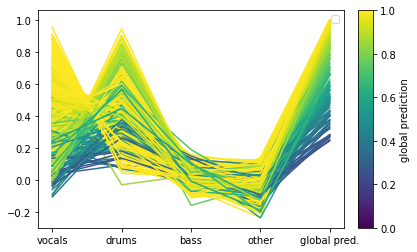

--- Execution Time: 02:46 seconds ---


In [11]:
start_time = time.time()
preprocess_instance_snippet(dataset_path, "Hip-Hop", model_path)
print(f"--- Execution Time: {time.strftime('%M:%S', time.gmtime(time.time() - start_time))} seconds ---")

Concatenate Test Data...
Snippet number 1
Predicted Rock with confidence of 0.4188956320285797
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.02949739247560501
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.049742184579372406
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.03732123598456383
Model predictet Instrumental for permutation (0, 1, 0, 0); Target label with 0.07718323916196823
Model predictet Instrumental for permutation (0, 1, 0, 1); Target label with 0.16703681647777557
Model predictet Instrumental for permutation (0, 1, 1, 0); Target label with 0.07257858663797379
Model predictet Instrumental for permutation (0, 1, 1, 1); Target label with 0.1792410910129547
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.042294640094041824
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.030939579010009766
Model predictet Classical for permu

Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.028450295329093933
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.48713982105255127
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9060068726539612
Model predictet Jazz for permutation (0, 1, 1, 0); Target label with 0.320002943277359
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.8932889699935913
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.1372101902961731
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.1971108466386795
Model predictet Pop for permutation (1, 0, 1, 0); Target label with 0.13230863213539124
Model predictet Pop for permutation (1, 0, 1, 1); Target label with 0.18939118087291718
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.8317724466323853
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9255320429801941
Model 

Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.730584979057312
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9607675075531006
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.8134445548057556
Snippet number 17
Predicted Rock with confidence of 0.9549117088317871
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.05808539316058159
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.02622736059129238
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.047193367034196854
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.642818033695221
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9033629894256592
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.49772337079048157
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9336015582084656
Model predictet Classica

Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.3895253837108612
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.07794400304555893
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.08226623386144638
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.09141779690980911
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.11289399862289429
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.4369264245033264
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.7250808477401733
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.5018628239631653
Snippet number 24
Predicted Rock with confidence of 0.40256378054618835
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.06929930299520493
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04561019316315651

Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.45086023211479187
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.04065055772662163
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.072084441781044
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.0371546596288681
Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.07665134221315384
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.16981573402881622
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.479105144739151
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.1883579045534134
Snippet number 30
Predicted Rock with confidence of 0.6821174025535583
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.1163741797208786
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.043224938213825226


Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.045416247099637985
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.09942352026700974
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.4353431463241577
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8120025396347046
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.43709927797317505
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.7625374794006348
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.1262529045343399
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.26932233572006226
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.1433601677417755
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.2577537000179291
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.73055118322372

Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9368946552276611
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9919608235359192
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.8882980346679688
Snippet number 43
Predicted Rock with confidence of 0.8229731917381287
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.1726987212896347
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04005446657538414
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.12121637165546417
Model predictet Instrumental for permutation (0, 1, 0, 0); Target label with 0.1759677529335022
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.7270230054855347
Model predictet Instrumental for permutation (0, 1, 1, 0); Target label with 0.17760665714740753
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.6928941011428833
Model pr

Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.7964441180229187
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9683457612991333
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.06968019902706146
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.20684203505516052
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.09606356918811798
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.20401936769485474
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.8788650035858154
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9836810827255249
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9330868124961853
Snippet number 50
Predicted Rock with confidence of 0.9884682297706604
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.0932253822684288
Model predictet Elect

Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.10625459998846054
Model predictet Folk for permutation (1, 0, 1, 1); Target label with 0.17179782688617706
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.09092483669519424
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.13136877119541168
Model predictet Experimental for permutation (1, 1, 1, 0); Target label with 0.17295826971530914
Snippet number 61
Predicted International with confidence of 0.6696736812591553
Not Target Genre ... continue
Snippet number 62
Predicted Folk with confidence of 0.4142218232154846
Not Target Genre ... continue
Snippet number 63
Predicted Folk with confidence of 0.46445178985595703
Not Target Genre ... continue
Snippet number 64
Predicted Rock with confidence of 0.3385823667049408
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.03825841844081879
Model predictet Electronic for permutation (0,

Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.6463713049888611
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.3230867087841034
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.6143357157707214
Model predictet International for permutation (1, 0, 0, 0); Target label with 0.05074891820549965
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.13946348428726196
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.11650891602039337
Model predictet International for permutation (1, 0, 1, 1); Target label with 0.17121842503547668
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.3807062804698944
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.6843137145042419
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.526261031627655
Snippet number 72
Predicted Rock with confidence of 0.619300901889801
Model predic

Predicted Rock with confidence of 0.9991760849952698
Model predictet Rock for permutation (0, 0, 0, 1); Target label with 0.4830412268638611
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04985244944691658
Model predictet Rock for permutation (0, 0, 1, 1); Target label with 0.5429052114486694
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.8119325041770935
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9972368478775024
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.9340693950653076
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9988425374031067
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.07718103379011154
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.6286126375198364
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.1352686583995819
Model predictet Rock for permutation (1, 0,

Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.12017042934894562
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.06056137755513191
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.1291385293006897
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.5493844151496887
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.7432867884635925
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.6001531481742859
Snippet number 85
Predicted Rock with confidence of 0.9837861657142639
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.22233204543590546
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04627792537212372
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.22154906392097473
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.48450425267219543
Model p

Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.025224855169653893
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.14539653062820435
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.6474430561065674
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9802595376968384
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.4894827902317047
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9839860200881958
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.060775406658649445
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.30644670128822327
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.09068241715431213
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.360607773065567
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.543265700340271

Model predictet International for permutation (1, 0, 0, 0); Target label with 0.05985233932733536
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.11244602501392365
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.07214216142892838
Model predictet Folk for permutation (1, 0, 1, 1); Target label with 0.12899264693260193
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.3747046887874603
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.46890053153038025
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.39520835876464844
Snippet number 98
Predicted Folk with confidence of 0.5079175233840942
Not Target Genre ... continue
Snippet number 99
Predicted Rock with confidence of 0.4741167426109314
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.06325840204954147
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04600729793310

Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.3933027386665344
Snippet number 105
Predicted Rock with confidence of 0.7798058390617371
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.0434030145406723
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.02610129676759243
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.02883913926780224
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.34684616327285767
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.5248042345046997
Model predictet Jazz for permutation (0, 1, 1, 0); Target label with 0.10917796939611435
Model predictet Instrumental for permutation (0, 1, 1, 1); Target label with 0.23357953131198883
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.05291926860809326
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.0922630578279

Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.6784359216690063
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.700301468372345
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.6083990931510925
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.6866708993911743
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.0849059671163559
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.08217988163232803
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.1824352890253067
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.2039509415626526
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9001661539077759
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9189234972000122
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9432165026664734


Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.17508377134799957
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.8952793478965759
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9096261858940125
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9129879474639893
Snippet number 118
Predicted Rock with confidence of 0.8998817801475525
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.05497853457927704
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04978654533624649
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.0632714033126831
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.733677864074707
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8645195960998535
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.5639917254447937
Model predictet 

Model predictet Instrumental for permutation (0, 1, 1, 0); Target label with 0.1414158046245575
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.3852948844432831
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.08143594861030579
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.1053037941455841
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.1278485208749771
Model predictet Folk for permutation (1, 0, 1, 1); Target label with 0.23476748168468475
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.6210139393806458
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.6838367581367493
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.6252502202987671
Snippet number 125
Predicted Rock with confidence of 0.9101933836936951
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.11304926872253418
Model predict

Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.7898074388504028
Model predictet International for permutation (1, 1, 1, 0); Target label with 0.34337177872657776
Snippet number 131
Predicted Rock with confidence of 0.9119645953178406
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.05164134129881859
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.02647358924150467
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.032368455082178116
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.6727361679077148
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8747289776802063
Model predictet Instrumental for permutation (0, 1, 1, 0); Target label with 0.31821051239967346
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.6723718047142029
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.0590475909

Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.061166007071733475
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.041317105293273926
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.06125154346227646
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.8729895353317261
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8839858770370483
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.8435685038566589
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.8837283253669739
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.03727232292294502
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.05568128079175949
Model predictet Instrumental for permutation (1, 0, 1, 0); Target label with 0.05536250025033951
Model predictet Instrumental for permutation (1, 0, 1, 1); Target l

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.057357028126716614
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.14680905640125275
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.408376544713974
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8605520725250244
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.6129522323608398
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.8711962699890137
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.12074213474988937
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.25982093811035156
Model predictet Rock for permutation (1, 0, 1, 0); Target label with 0.20091448724269867
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.33327385783195496
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.733421266078949
Model

Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.0422758087515831
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9738000631332397
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9866266846656799
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9786083102226257
Snippet number 151
Predicted Rock with confidence of 0.6647576093673706
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.032726746052503586
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.0450541153550148
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.0343950092792511
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.7344940304756165
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.6323783993721008
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.8196240663528442
Model predictet Rock 

Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.05836435407400131
Snippet number 166
Predicted Rock with confidence of 0.8784372806549072
Model predictet Rock for permutation (0, 0, 0, 1); Target label with 0.5108911395072937
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.0475386381149292
Model predictet Rock for permutation (0, 0, 1, 1); Target label with 0.48820653557777405
Model predictet Instrumental for permutation (0, 1, 0, 0); Target label with 0.08223547041416168
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.7165700793266296
Model predictet Instrumental for permutation (0, 1, 1, 0); Target label with 0.06778443604707718
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.7575992345809937
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.07955187559127808
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.6920496821403503
Model p

Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.837746262550354
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9753888845443726
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.8861818313598633
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9826056957244873
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.039141084998846054
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.0690263956785202
Model predictet Classical for permutation (1, 0, 1, 0); Target label with 0.04743288457393646
Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.06634361296892166
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9487995505332947
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9888582229614258
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9691451191902161
Snippe

Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.2919844090938568
Model predictet Instrumental for permutation (1, 1, 0, 0); Target label with 0.23268386721611023
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.8103057742118835
Model predictet Instrumental for permutation (1, 1, 1, 0); Target label with 0.23378396034240723
Snippet number 181
Predicted Rock with confidence of 0.6584177017211914
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.12320053577423096
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04208492487668991
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.07331858575344086
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.3409182131290436
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.6779587268829346
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.3065285384654999
M

Predicted Rock with confidence of 0.9137218594551086
Model predictet Folk for permutation (0, 0, 0, 1); Target label with 0.03701440617442131
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.05145683512091637
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.07198645174503326
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.39651548862457275
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.6948662996292114
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.5000012516975403
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.8477404713630676
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.1370178610086441
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.1179838627576828
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.20456422865390778
Model predictet Rock for permuta

Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.4900943636894226
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.2998523712158203
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.608950674533844
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.036829568445682526
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.0839710384607315
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.03497723489999771
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.06149920076131821
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.2413349598646164
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.6185005307197571
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.27814120054244995
Snippet number 195
Predicted International with confidence of 0.5676770210266113
Not Target 

Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.5339658856391907
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.8270469307899475
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.5818923711776733
Snippet number 202
Predicted Electronic with confidence of 0.34308168292045593
Not Target Genre ... continue
Snippet number 203
Predicted Rock with confidence of 0.3364821672439575
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.03428450971841812
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04201773181557655
Model predictet Jazz for permutation (0, 0, 1, 1); Target label with 0.06643680483102798
Model predictet Experimental for permutation (0, 1, 0, 0); Target label with 0.1033119335770607
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.262825071811676
Model predictet Experimental for permutation (0, 1, 1, 0); Target label with 0.088156133890151

Model predictet Rock for permutation (0, 0, 1, 1); Target label with 0.4407956302165985
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.1257389336824417
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.7755675911903381
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.13759586215019226
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.7716532945632935
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.052949175238609314
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.45098263025283813
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.052912719547748566
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.5325958132743835
Model predictet Experimental for permutation (1, 1, 0, 0); Target label with 0.13931182026863098
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.79480552

Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9831303358078003
Model predictet Instrumental for permutation (1, 0, 0, 0); Target label with 0.06071009114384651
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.3281191885471344
Model predictet Instrumental for permutation (1, 0, 1, 0); Target label with 0.06455350667238235
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.24766144156455994
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.6709796190261841
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9883834719657898
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.6713404059410095
Snippet number 219
Predicted Rock with confidence of 0.9775288105010986
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.14444465935230255
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.0392607748508

Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.853999137878418
Snippet number 225
Predicted Rock with confidence of 0.9923116564750671
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.09192059189081192
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04461012780666351
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.0951097384095192
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.8232226967811584
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9813675284385681
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.8347143530845642
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9908161163330078
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.046731747686862946
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.11810799688100815
Model pr

Model predictet International for permutation (1, 0, 0, 0); Target label with 0.038351189345121384
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.0952385738492012
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.04321037232875824
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.1109309047460556
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9028410911560059
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9649568200111389
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9177886843681335
Snippet number 232
Predicted Electronic with confidence of 0.4997237026691437
Not Target Genre ... continue
Snippet number 233
Predicted Electronic with confidence of 0.5325778126716614
Not Target Genre ... continue
Snippet number 234
Predicted Electronic with confidence of 0.4402300715446472
Not Target Genre ... continue
Snippet number 235
Pred

Predicted Rock with confidence of 0.7719005942344666
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.016697587445378304
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.05224873870611191
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.025416553020477295
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.5510955452919006
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.7376286387443542
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.5086235404014587
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.8636054992675781
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.03702929988503456
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.013862590305507183
Model predictet Classical for permutation (1, 0, 1, 0); Target label with 0.03416161239147186
Model predictet

Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.7925278544425964
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.43160685896873474
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.8317627906799316
Model predictet International for permutation (1, 0, 0, 0); Target label with 0.2519110441207886
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.6220027804374695
Model predictet Rock for permutation (1, 0, 1, 0); Target label with 0.3726717233657837
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.6638032793998718
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.6230638027191162
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9062049984931946
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.7625684142112732
Snippet number 251
Predicted Rock with confidence of 0.8989319205284119
Model predictet Folk for permutation (

Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.03241005912423134
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.14228764176368713
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.4522271752357483
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9478509426116943
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.5268186330795288
Snippet number 257
Predicted Rock with confidence of 0.8709139823913574
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.15993548929691315
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.04279791936278343
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.12424040585756302
Model predictet Experimental for permutation (0, 1, 0, 0); Target label with 0.1260044276714325
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.63212472200393

Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.09570862352848053
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.8720318675041199
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9417764544487
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9310722351074219
Snippet number 265
Predicted Rock with confidence of 0.9586911797523499
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.11052798479795456
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.045803964138031006
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.12361998856067657
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.4090929627418518
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9101290106773376
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.5684729218482971
Model predictet Ro

Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.5122368335723877
Model predictet Experimental for permutation (1, 1, 1, 0); Target label with 0.1527128368616104
Snippet number 272
Predicted Rock with confidence of 0.8503718376159668
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.10573383420705795
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.053790971636772156
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.10578583925962448
Model predictet Experimental for permutation (0, 1, 0, 0); Target label with 0.3097301423549652
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.6666680574417114
Model predictet Experimental for permutation (0, 1, 1, 0); Target label with 0.30473899841308594
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.746248722076416
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.0596067

Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9607032537460327
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.6364224553108215
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9838417768478394
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.04495488107204437
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.3842600882053375
Model predictet Classical for permutation (1, 0, 1, 0); Target label with 0.07150015980005264
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.446292519569397
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.8779467940330505
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9930324554443359
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9185145497322083
Snippet number 281
Predicted Rock with confidence of 0.9866364598274231
Model predictet Instrumental for perm

Model predictet Classical for permutation (1, 0, 1, 0); Target label with 0.07669459283351898
Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.15628871321678162
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.5379514098167419
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.7289577126502991
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.7606788277626038
Snippet number 287
Predicted Rock with confidence of 0.8852037191390991
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.08347851037979126
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.046815503388643265
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.08788340538740158
Model predictet International for permutation (0, 1, 0, 0); Target label with 0.24769292771816254
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.6525816321372986


Predicted Rock with confidence of 0.740509033203125
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.04177647829055786
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04316117614507675
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.030291341245174408
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.3518480062484741
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.4265013635158539
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.544951319694519
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.6005396842956543
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.07339318096637726
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.062404222786426544
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.08990176767110825
Model predictet Folk for permutat

Model predictet Rock for permutation (0, 0, 0, 1); Target label with 0.19568698108196259
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.036425501108169556
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.14183318614959717
Model predictet Instrumental for permutation (0, 1, 0, 0); Target label with 0.2103368490934372
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8231210112571716
Model predictet Instrumental for permutation (0, 1, 1, 0); Target label with 0.24591583013534546
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.8759779930114746
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.012146266177296638
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.06156913563609123
Model predictet Classical for permutation (1, 0, 1, 0); Target label with 0.006182307377457619
Model predictet Classical for permutation (1, 0, 1, 1); Target label

Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.10057558119297028
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.025804633274674416
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.06674759089946747
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.43134450912475586
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.8060321807861328
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.29914772510528564
Snippet number 306
Predicted Rock with confidence of 0.9290952682495117
Model predictet Rock for permutation (0, 0, 0, 1); Target label with 0.49763286113739014
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.03847552835941315
Model predictet Rock for permutation (0, 0, 1, 1); Target label with 0.35008054971694946
Model predictet Experimental for permutation (0, 1, 0, 0); Target label with 0.1845303624868393
M

Model predictet Folk for permutation (0, 0, 0, 1); Target label with 0.033820606768131256
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.04379027709364891
Model predictet Folk for permutation (0, 0, 1, 1); Target label with 0.029052700847387314
Model predictet Instrumental for permutation (0, 1, 0, 0); Target label with 0.1271635890007019
Model predictet Folk for permutation (0, 1, 0, 1); Target label with 0.23431634902954102
Model predictet Experimental for permutation (0, 1, 1, 0); Target label with 0.18367211520671844
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.31762903928756714
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.10951132327318192
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.05485506355762482
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.11718517541885376
Model predictet Folk for permutation (1, 0, 1, 1); Target label with 

Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.23133037984371185
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.07018942385911942
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.28605908155441284
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.7243461608886719
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9361677765846252
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.5216218829154968
Snippet number 322
Predicted Rock with confidence of 0.8891147971153259
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.039160601794719696
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.040293481200933456
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.05723250284790993
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.3985174298286438
Model p

Predicted Rock with confidence of 0.6220697164535522
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.055751144886016846
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.03842930868268013
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.0608588382601738
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.33218246698379517
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.5904775857925415
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.39827945828437805
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.6395439505577087
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.058516256511211395
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.06501588970422745
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.06415538489818573
Model predictet Instrume

Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.031222937628626823
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.001541432342492044
Model predictet Instrumental for permutation (1, 0, 1, 0); Target label with 0.02425093948841095
Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.0018659840570762753
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.841773271560669
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.7040889859199524
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.8568336367607117
Snippet number 335
Predicted Rock with confidence of 0.974543571472168
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.11813156306743622
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.02831280790269375
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.088148698

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.041762612760066986
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.017974350601434708
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.7267711758613586
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8725905418395996
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.6813175082206726
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.8288717269897461
Model predictet Old-Time / Historic for permutation (1, 0, 0, 0); Target label with 0.00078967260196805
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.15592601895332336
Model predictet Old-Time / Historic for permutation (1, 0, 1, 0); Target label with 0.0003900006413459778
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.16651196777820587
Model predictet Rock for permutation (1, 1, 0, 0); Ta

Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.16848057508468628
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.813532829284668
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9553580284118652
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.8747074604034424
Snippet number 348
Predicted Rock with confidence of 0.8450306057929993
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.12639082968235016
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.04548674449324608
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.08090589195489883
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.29728513956069946
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.7273604273796082
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.4866991937160492
Model predictet

Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.7059345245361328
Snippet number 357
Predicted Rock with confidence of 0.7833616733551025
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.060399651527404785
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.05649115890264511
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.05124082416296005
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.24646827578544617
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.5074249505996704
Model predictet Instrumental for permutation (0, 1, 1, 0); Target label with 0.2508992552757263
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.5436692237854004
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.0494588203728199
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.08213416486978

Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.9104359149932861
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9907434582710266
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.08216048032045364
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.3055364787578583
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.20911478996276855
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.556049644947052
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9427659511566162
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9914959669113159
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9849435687065125
Snippet number 364
Predicted Rock with confidence of 0.4795105755329132
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.028869828209280968
Model predictet Electron

Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.7087379097938538
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9747179746627808
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.04225405305624008
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.2821190655231476
Model predictet Instrumental for permutation (1, 0, 1, 0); Target label with 0.08819844573736191
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.32393670082092285
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.7341141104698181
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9629049301147461
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.7100841403007507
Snippet number 370
Predicted Rock with confidence of 0.994476854801178
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.07560145854949951
Model predictet Electron

Predicted Rock with confidence of 0.9991984963417053
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.03737986460328102
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04471020773053169
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.057555053383111954
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.9517685174942017
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.986091673374176
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.9852993488311768
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9970231652259827
Model predictet Spoken for permutation (1, 0, 0, 0); Target label with 0.10384609550237656
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.17251375317573547
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.18834711611270905
Model predictet Rock 

Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9877822995185852
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.8271794319152832
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9890583157539368
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.07583024352788925
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.20373615622520447
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.06635986268520355
Model predictet Folk for permutation (1, 0, 1, 1); Target label with 0.1762228012084961
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9182810187339783
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9911032915115356
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9071112275123596
Snippet number 386
Predicted Rock with confidence of 0.9844091534614563
Model predictet Elec

Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.29157131910324097
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.1272810399532318
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.24190761148929596
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.5227113366127014
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.6369132995605469
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.5941665768623352
Snippet number 392
Predicted Rock with confidence of 0.6099998950958252
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.03982501104474068
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.03991355001926422
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.04528326913714409
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.23863442242145538
Model 

Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.47456884384155273
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.3089790344238281
Snippet number 398
Predicted Rock with confidence of 0.695367157459259
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.10406305640935898
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.040021155029535294
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.07379171252250671
Model predictet Experimental for permutation (0, 1, 0, 0); Target label with 0.12589634954929352
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.5725436210632324
Model predictet Experimental for permutation (0, 1, 1, 0); Target label with 0.12373559176921844
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.5599983334541321
Model predictet Spoken for permutation (1, 0, 0, 0); Target label with 0.043365489691495895
Model

Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.5789291858673096
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.29525700211524963
Snippet number 404
Predicted Electronic with confidence of 0.5431023836135864
Not Target Genre ... continue
Snippet number 405
Predicted Rock with confidence of 0.7154583930969238
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.03442170098423958
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.03651442751288414
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.02561737224459648
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.34910356998443604
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.6235942840576172
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.32341665029525757
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.4368135631084442
Mode

Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9392556548118591
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.04203053563833237
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.07137554883956909
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.04677223414182663
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.06513151526451111
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.7334099411964417
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9333562254905701
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.7599056959152222
Snippet number 412
Predicted Rock with confidence of 0.6460487246513367
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.09592526406049728
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.0354003943502903
M

Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9522232413291931
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.8404481410980225
Snippet number 418
Predicted Rock with confidence of 0.8239311575889587
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.07572546601295471
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04853583872318268
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.05912189185619354
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.1875421702861786
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.5829815864562988
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.27044743299484253
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.7126279473304749
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.0740247294306755
Model predicte

Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8667685985565186
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.8016443848609924
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.8736253976821899
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.08731120824813843
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.23240382969379425
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.086839459836483
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.28044798970222473
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.890998363494873
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9132215976715088
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.8718194365501404
Snippet number 425
Predicted Rock with confidence of 0.8208614587783813
Model predictet Instrum

Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.7745894193649292
Snippet number 431
Predicted Rock with confidence of 0.9097718000411987
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.010099408216774464
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.03992532938718796
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.02993064746260643
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.48125529289245605
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.5331419110298157
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.6169495582580566
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.7198162078857422
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.05231868475675583
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.11791932582855225
Model pre

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04429459944367409
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.062452275305986404
Model predictet Instrumental for permutation (0, 1, 0, 0); Target label with 0.28524038195610046
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.6500492691993713
Model predictet Instrumental for permutation (0, 1, 1, 0); Target label with 0.2766178846359253
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.703761875629425
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.06264205276966095
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.11167286336421967
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.05762384831905365
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.1841600239276886
Model predictet Rock for permutation (1, 1, 0, 0); T

Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.041954703629016876
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.22511427104473114
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.0363750085234642
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.25101661682128906
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.7453399300575256
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9820805788040161
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.7600308060646057
Snippet number 444
Predicted Rock with confidence of 0.9714571237564087
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.09621996432542801
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.04327191784977913
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.25018

Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.041391272097826004
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04032329469919205
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.07593131810426712
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.6275331377983093
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8079594373703003
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.7221215963363647
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9205266833305359
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.07304392009973526
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.08736257255077362
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.09939046204090118
Model predictet Experimental for permutation (1, 0, 1, 1); Target label

Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.05814904347062111
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.16389106214046478
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.8918463587760925
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9937663078308105
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.943930447101593
Snippet number 457
Predicted Rock with confidence of 0.724489152431488
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.03600463271141052
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04456442967057228
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.05452689528465271
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.34655308723449707
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.5360249280929565
Model predicte

Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.7531221508979797
Snippet number 463
Predicted International with confidence of 0.3991199731826782
Not Target Genre ... continue
Snippet number 464
Predicted International with confidence of 0.23798030614852905
Not Target Genre ... continue
Snippet number 465
Predicted Rock with confidence of 0.7841301560401917
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.0548231340944767
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.0501517690718174
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.05755731463432312
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.44500473141670227
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.6763164401054382
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.596580445766449
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0

Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.25529229640960693
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.44356879591941833
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.025674208998680115
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.015067457221448421
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.02944953180849552
Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.03183108568191528
Model predictet Experimental for permutation (1, 1, 0, 0); Target label with 0.23327556252479553
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.39084282517433167
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.3345761001110077
Snippet number 472
Predicted Rock with confidence of 0.9960579872131348
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.110786989331245

Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.964033842086792
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9965327978134155
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9659256339073181
Snippet number 478
Predicted Rock with confidence of 0.9983506202697754
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.08455746620893478
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04038495942950249
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.09587211161851883
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.9602799415588379
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9904289245605469
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.9918022751808167
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9974790215492249
Model predictet Classical 

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.046485964208841324
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.0975663959980011
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.9837491512298584
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9967708587646484
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.9928997755050659
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9984614849090576
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.05143868550658226
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.19867178797721863
Model predictet Classical for permutation (1, 0, 1, 0); Target label with 0.05639396607875824
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.14989250898361206
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.99384

Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9960436820983887
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.09098582714796066
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.12173370271921158
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.07804222404956818
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.08835272490978241
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9924377799034119
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9948851466178894
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.995274543762207
Snippet number 491
Predicted Rock with confidence of 0.9898607730865479
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.07639278471469879
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.0530603788793087


Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.071439728140831
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.5327131152153015
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.8924306631088257
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.7196385264396667
Snippet number 497
Predicted Rock with confidence of 0.9040551781654358
Model predictet Rock for permutation (0, 0, 0, 1); Target label with 0.3443487584590912
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04849017411470413
Model predictet Rock for permutation (0, 0, 1, 1); Target label with 0.366924911737442
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.3317805528640747
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9021372199058533
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.26824966073036194
Model predictet Rock for permutation 

Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.05102095752954483
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.05045676603913307
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.06343384087085724
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.5584138035774231
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8273755311965942
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.4560394287109375
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.8621286153793335
Model predictet Old-Time / Historic for permutation (1, 0, 0, 0); Target label with 0.04749704897403717
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.12713748216629028
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.10091704875230789
Model predictet Instrumental for permutation (1, 0, 1, 1); Ta

Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.13237319886684418
Model predictet Instrumental for permutation (0, 1, 0, 0); Target label with 0.23268122971057892
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.6425734162330627
Model predictet Instrumental for permutation (0, 1, 1, 0); Target label with 0.20517335832118988
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.6583577990531921
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.05289701744914055
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.20715060830116272
Model predictet Classical for permutation (1, 0, 1, 0); Target label with 0.07532647252082825
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.22200840711593628
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.580091655254364
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.7

Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9214221835136414
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.6485128998756409
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9180340766906738
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.022533807903528214
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.04034259542822838
Model predictet Classical for permutation (1, 0, 1, 0); Target label with 0.01625404693186283
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.02736896649003029
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.7966291904449463
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9516032338142395
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.8408078551292419
Snippet number 519
Predicted Rock with confidence of 0.6755803227424622
Model predictet Experi

Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.6872914433479309
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.949178159236908
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.7960367202758789
Snippet number 525
Predicted Rock with confidence of 0.9856463074684143
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.10418868809938431
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.043141238391399384
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.08221796900033951
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.7164271473884583
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9085842967033386
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.849646270275116
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9643754363059998
Model predictet Experime

Predicted Rock with confidence of 0.9759148955345154
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.08204803615808487
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04317966103553772
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.060974981635808945
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.8475661277770996
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9430549740791321
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.9503543972969055
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9783406853675842
Model predictet Instrumental for permutation (1, 0, 0, 0); Target label with 0.030213072896003723
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.04554300010204315
Model predictet Instrumental for permutation (1, 0, 1, 0); Target label with 0.031236780807375908
Model predictet 

Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.5007762908935547
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.7062282562255859
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.0343131385743618
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.03784935548901558
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.03183695301413536
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.03006051480770111
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.4678393304347992
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.6509034633636475
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.5746862292289734
Snippet number 538
Predicted Rock with confidence of 0.6908378601074219
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.049285370856523514
Model predi

Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.045407772064208984
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.038960717618465424
Model predictet Instrumental for permutation (1, 0, 1, 0); Target label with 0.06370116025209427
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.06201712042093277
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.31774622201919556
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.6901341676712036
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.4066767990589142
Snippet number 545
Predicted Rock with confidence of 0.8464956879615784
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.042652249336242676
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.03381229192018509
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.0

Model predictet Experimental for permutation (0, 1, 1, 0); Target label with 0.1498369723558426
Model predictet International for permutation (0, 1, 1, 1); Target label with 0.17122286558151245
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.09159483015537262
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.01281769573688507
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.06911125034093857
Model predictet Folk for permutation (1, 0, 1, 1); Target label with 0.01931990496814251
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.4150356650352478
Model predictet Folk for permutation (1, 1, 0, 1); Target label with 0.2080526351928711
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.3757020831108093
Snippet number 556
Predicted Rock with confidence of 0.9797899723052979
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.04217802733182907
Model 

Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9675392508506775
Snippet number 562
Predicted Rock with confidence of 0.9880896210670471
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.14113456010818481
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.036334745585918427
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.09951993823051453
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.9228183627128601
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9848265647888184
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.9490935802459717
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9912770986557007
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.069668710231781
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.2458052635192871
Model predictet Ex

Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9408043026924133
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.5403624773025513
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9524788856506348
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.06529609113931656
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.26520290970802307
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.07567989826202393
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.2663955092430115
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.6080352067947388
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9227411150932312
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.6193131804466248
Snippet number 569
Predicted Rock with confidence of 0.9904116988182068
Model predictet Instrumental 

Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.14689230918884277
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.37517988681793213
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9424716234207153
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9773560762405396
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9710109233856201
Snippet number 575
Predicted Rock with confidence of 0.9847879409790039
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.02656036801636219
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.05370762571692467
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.039709411561489105
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.8309416174888611
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.954311192035675
Model predictet Roc

Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9879325032234192
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.9166568517684937
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9953837990760803
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.07970847934484482
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.2065456658601761
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.09133101999759674
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.20469367504119873
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.958816409111023
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.98783278465271
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9731299877166748
Snippet number 582
Predicted Rock with confidence of 0.9852456450462341
Model predictet 

Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.5857946276664734
Model predictet Instrumental for permutation (0, 1, 1, 0); Target label with 0.20094163715839386
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.6135541200637817
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.0576222762465477
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.1672438383102417
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.06299468874931335
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.16075581312179565
Model predictet Instrumental for permutation (1, 1, 0, 0); Target label with 0.10003625601530075
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.5284416079521179
Model predictet Instrumental for permutation (1, 1, 1, 0); Target label with 0.14846636354923248
Snippet number 588
Predicted Rock with confidence of 0.35821020

Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.04112854227423668
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04374658316373825
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.047212496399879456
Model predictet Experimental for permutation (0, 1, 0, 0); Target label with 0.09864778816699982
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.34405598044395447
Model predictet Experimental for permutation (0, 1, 1, 0); Target label with 0.08004537969827652
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.27864331007003784
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.03846711292862892
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.03807135671377182
Model predictet Classical for permutation (1, 0, 1, 0); Target label with 0.03257298469543457
Model predictet Instrumental for permutation (1, 0, 1

Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.32009151577949524
Snippet number 604
Predicted Rock with confidence of 0.9869871139526367
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.20668545365333557
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.03889966011047363
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.20138925313949585
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.6316457390785217
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9457305073738098
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.727337658405304
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9796486496925354
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.04283600300550461
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.17191153764724731
Model p

Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.10024406760931015
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.17134889960289001
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.15209558606147766
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.27087312936782837
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.7254388928413391
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.875723123550415
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.7903205752372742
Snippet number 611
Predicted Rock with confidence of 0.940601110458374
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.07064409554004669
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.05202135071158409
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.06544768065214157

Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.988224983215332
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9254234433174133
Snippet number 617
Predicted Rock with confidence of 0.9882192611694336
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.0873202458024025
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.03466149419546127
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.05225002020597458
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.7752548456192017
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9662235379219055
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.7564445734024048
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9599363207817078
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.07112012803554535
Model predictet 

Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.3323380947113037
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8488703966140747
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.3131493330001831
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.7902726531028748
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.039590224623680115
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.0760362297296524
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.042292091995477676
Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.07397275418043137
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.5211334228515625
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.8643907308578491
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.495231747627258

Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.35969534516334534
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.574540913105011
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.46542128920555115
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.7571306824684143
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.04148298129439354
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.03428788483142853
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.04831841215491295
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.043026819825172424
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.4219871759414673
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.6319289803504944
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.594797372817993

Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.16441790759563446
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.5004652142524719
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.8215994238853455
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.8039165735244751
Snippet number 637
Predicted Rock with confidence of 0.7240397334098816
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.05534745380282402
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.06711336970329285
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.08170916140079498
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.3909768760204315
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.5910472869873047
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.4218057096004486
Model predictet 

Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.6945040822029114
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.45674505829811096
Snippet number 644
Predicted Rock with confidence of 0.7556071877479553
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.14919807016849518
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04322589933872223
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.15606483817100525
Model predictet Instrumental for permutation (0, 1, 0, 0); Target label with 0.14077706634998322
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.562333881855011
Model predictet Instrumental for permutation (0, 1, 1, 0); Target label with 0.13101167976856232
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.5041895508766174
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.0502676814794540

Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.8518346548080444
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9395958185195923
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.9201499819755554
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9757434725761414
Model predictet Instrumental for permutation (1, 0, 0, 0); Target label with 0.057079706341028214
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.024020614102482796
Model predictet Instrumental for permutation (1, 0, 1, 0); Target label with 0.05284503102302551
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.029406603425741196
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9206971526145935
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9635634422302246
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9510718584

Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.21193073689937592
Model predictet Spoken for permutation (1, 1, 0, 0); Target label with 0.2972666323184967
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.7865965962409973
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.47600454092025757
Snippet number 669
Predicted Rock with confidence of 0.9009549021720886
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.06568732857704163
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04074031859636307
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.050799690186977386
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.2668185830116272
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.7932302355766296
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.29816973209381104
Model pre

Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.5233195424079895
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.6112084984779358
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.7320674061775208
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.022346438840031624
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.03687277436256409
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.04338014870882034
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.07495460659265518
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.5922196507453918
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.7628624439239502
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.6337184309959412
Snippet number 676
Predicted Rock with confidence of 0.5190490484237671
Model predi

Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.37556353211402893
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.7824861407279968
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.48210757970809937
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.8517906665802002
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.06145266443490982
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.2893846035003662
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.08874675631523132
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.2730675935745239
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.42892342805862427
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.785231351852417
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.4841907024383545
Snip

Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.5841792225837708
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.04318111389875412
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.0512048676609993
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.03681057691574097
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.05025859549641609
Model predictet Experimental for permutation (1, 1, 0, 0); Target label with 0.14656636118888855
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.4551454782485962
Model predictet Experimental for permutation (1, 1, 1, 0); Target label with 0.1561216115951538
Snippet number 689
Predicted Rock with confidence of 0.5974487662315369
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.0652434304356575
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.055

Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.3606990873813629
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.530631959438324
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.3898855149745941
Snippet number 695
Predicted Rock with confidence of 0.7376899719238281
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.03944792225956917
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.040892768651247025
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.05801553279161453
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.3613017797470093
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.5995367765426636
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.36149317026138306
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.6310750246047974
Model predictet Experiment

Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.408771276473999
Snippet number 701
Predicted Rock with confidence of 0.3168075978755951
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.027895955368876457
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.045952729880809784
Model predictet Experimental for permutation (0, 0, 1, 1); Target label with 0.030316531658172607
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.09940286725759506
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.21685265004634857
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.11446254700422287
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.2366577386856079
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.059510212391614914
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.04510

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.043597254902124405
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.06098150089383125
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.5437397360801697
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.849160373210907
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.6433013081550598
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.935979962348938
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.11373752355575562
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.22556401789188385
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.12586580216884613
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.2581791877746582
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 

Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.8765984773635864
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.08326637744903564
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.14980150759220123
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.14415867626667023
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.29519838094711304
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.4152187407016754
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.877650797367096
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.6782644391059875
Snippet number 715
Predicted Rock with confidence of 0.8329845666885376
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.02085801027715206
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04982076585292816


Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.17526689171791077
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.7105764746665955
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9121622443199158
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.7496647834777832
Snippet number 721
Predicted Rock with confidence of 0.9895078539848328
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.25050777196884155
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.046538274735212326
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.2854701280593872
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.4841781258583069
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9482234716415405
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.4853632152080536
Model predicte

Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.540082573890686
Snippet number 727
Predicted Hip-Hop with confidence of 0.32544106245040894
Not Target Genre ... continue
Snippet number 728
Predicted Rock with confidence of 0.7386723160743713
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.014368354342877865
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04665430262684822
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.05611351877450943
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.15579305589199066
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.31218230724334717
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.26157844066619873
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.43197131156921387
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.0974

Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.10868997126817703
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.047035109251737595
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.09570366889238358
Model predictet Instrumental for permutation (0, 1, 0, 0); Target label with 0.04820096492767334
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.2513391375541687
Model predictet Experimental for permutation (0, 1, 1, 0); Target label with 0.07178832590579987
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.28579047322273254
Model predictet Instrumental for permutation (1, 0, 0, 0); Target label with 0.03813834860920906
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.10512156039476395
Model predictet Instrumental for permutation (1, 0, 1, 0); Target label with 0.0675879493355751
Model predictet Instrumental for permutation (1, 

Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.24630683660507202
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8100375533103943
Model predictet Experimental for permutation (0, 1, 1, 0); Target label with 0.23360088467597961
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.7782565355300903
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.02715872973203659
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.19142772257328033
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.04927226901054382
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.18015438318252563
Model predictet Experimental for permutation (1, 1, 0, 0); Target label with 0.22513055801391602
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.7870819568634033
Model predictet Experimental for permutation (1, 1, 1, 0); Target

Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.09594902396202087
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.044693440198898315
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.1006571352481842
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.7928248047828674
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9684226512908936
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.8484402894973755
Snippet number 748
Predicted Rock with confidence of 0.9427402019500732
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.14215391874313354
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04666822776198387
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.12186890095472336
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.3365727663040161


Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.032708995044231415
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9432406425476074
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9886552095413208
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9552435874938965
Snippet number 756
Predicted Rock with confidence of 0.8106666803359985
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.037048451602458954
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.050893668085336685
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.048882778733968735
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.44719094038009644
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.7451615333557129
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.5301459431648254
Model predictet

Predicted Experimental with confidence of 0.6313117146492004
Not Target Genre ... continue
Snippet number 766
Predicted Experimental with confidence of 0.5546126961708069
Not Target Genre ... continue
Snippet number 767
Predicted Experimental with confidence of 0.5736761689186096
Not Target Genre ... continue
Snippet number 768
Predicted Rock with confidence of 0.6307455897331238
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.11581902951002121
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.042405761778354645
Model predictet Experimental for permutation (0, 0, 1, 1); Target label with 0.22439846396446228
Model predictet Instrumental for permutation (0, 1, 0, 0); Target label with 0.08251815289258957
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.42123061418533325
Model predictet Instrumental for permutation (0, 1, 1, 0); Target label with 0.11594261974096298
Model predictet Rock for permutation (0, 1, 

Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.8881197571754456
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9971179962158203
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.055238988250494
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.5958821177482605
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.11317506432533264
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.6013103127479553
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.8732818961143494
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9952722191810608
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9432371854782104
Snippet number 779
Predicted Rock with confidence of 0.996036946773529
Model predictet Rock for permutation (0, 0, 0, 1); Target label with 0.3630979657173157
Model predictet Electronic for pe

Predicted Rock with confidence of 0.9925899505615234
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.17435608804225922
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04434911534190178
Model predictet Rock for permutation (0, 0, 1, 1); Target label with 0.32509005069732666
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.5150287747383118
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9639685153961182
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.6177323460578918
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9871910810470581
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.05256227031350136
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.2375767081975937
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.07966583222150803
Model predictet Rock for per

Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.24724096059799194
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.11699359863996506
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.35121458768844604
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.700206995010376
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9572315812110901
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.8042886853218079
Snippet number 792
Predicted Rock with confidence of 0.9781455993652344
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.13772527873516083
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.02980632148683071
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.08254951983690262
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.5663751363754272

Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.3791646659374237
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.8772346377372742
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9913557171821594
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9147916436195374
Snippet number 798
Predicted Rock with confidence of 0.9994774460792542
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.09964346885681152
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.039673782885074615
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.15155206620693207
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.8764470815658569
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9926678538322449
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.9227669835090637
Model predictet Rock f

Predicted Rock with confidence of 0.9481815695762634
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.061169788241386414
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.05474570393562317
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.08058841526508331
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.43434274196624756
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8492451906204224
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.5400793552398682
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9105376601219177
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.041932590305805206
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.07965407520532608
Model predictet Classical for permutation (1, 0, 1, 0); Target label with 0.0434306301176548
Model predictet Classi

Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8054895401000977
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.49149587750434875
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.7838208079338074
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.04905089735984802
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.1286810040473938
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.05879052355885506
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.11855097115039825
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.5029861330986023
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.8394243717193604
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.6046017408370972
Snippet number 811
Predicted Rock with confidence of 0.9170737862586975
Model predictet 

Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.07104548811912537
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.2201714962720871
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.5343484282493591
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.7842211127281189
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.5561529994010925
Snippet number 817
Predicted Rock with confidence of 0.8814378380775452
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.05646170303225517
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04205814376473427
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.051069244742393494
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.5827143788337708
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8383530378341675
Model p

Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.4392969012260437
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.699704110622406
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.4606971740722656
Snippet number 823
Predicted Instrumental with confidence of 0.3979793190956116
Not Target Genre ... continue
Snippet number 824
Predicted Classical with confidence of 0.46498599648475647
Not Target Genre ... continue
Snippet number 825
Predicted Instrumental with confidence of 0.5670273900032043
Not Target Genre ... continue
Snippet number 826
Predicted Electronic with confidence of 0.21926558017730713
Not Target Genre ... continue
Snippet number 827
Predicted Electronic with confidence of 0.24912160634994507
Not Target Genre ... continue
Snippet number 828
Predicted Electronic with confidence of 0.2601998448371887
Not Target Genre ... continue
Snippet number 829
Predicted Rock with confidence of 0.9971787929534912
Model predi

Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.29780375957489014
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.7065922617912292
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9403063058853149
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.7089337706565857
Snippet number 835
Predicted Rock with confidence of 0.9095701575279236
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.06000082194805145
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.06044537574052811
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.09127603471279144
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.4749812185764313
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.7824158072471619
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.5657923221588135
Model predictet Rock f

Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.8260672688484192
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8458846211433411
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.8601472973823547
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.8768141269683838
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.05723702162504196
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.0376615896821022
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.07907535880804062
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.07109642773866653
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.8438318371772766
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.8616133332252502
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9079092741012573
Snipp

Model predictet Instrumental for permutation (0, 1, 1, 0); Target label with 0.19146546721458435
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.5991150140762329
Model predictet International for permutation (1, 0, 0, 0); Target label with 0.0375523678958416
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.06534317880868912
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.028715362772345543
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.04836945980787277
Model predictet International for permutation (1, 1, 0, 0); Target label with 0.20089608430862427
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.5852764248847961
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.23491448163986206
Snippet number 849
Predicted Rock with confidence of 0.4062573313713074
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0

Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.701337993144989
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.05690796300768852
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.12151189893484116
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.07486704736948013
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.12052701413631439
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.52348792552948
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.8247094750404358
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.6073009371757507
Snippet number 855
Predicted Rock with confidence of 0.9256518483161926
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.05588437616825104
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04573122039437294
Model

Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.035392746329307556
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.05194637179374695
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.05412459000945091
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.06928959488868713
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.4274144172668457
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.6536704897880554
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.35728201270103455
Snippet number 862
Predicted Rock with confidence of 0.5533254146575928
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.06768900901079178
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.0490066222846508
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.06468430

Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.46251368522644043
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.05831589922308922
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.03702279552817345
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.12432290613651276
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.12478627264499664
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.33002662658691406
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.39281249046325684
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.5861313939094543
Snippet number 868
Predicted Rock with confidence of 0.8321518301963806
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.16276511549949646
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04884023219347

Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.35713809728622437
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.363552451133728
Snippet number 875
Predicted Rock with confidence of 0.4568825364112854
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.014542236924171448
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04192306101322174
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.012469385750591755
Model predictet Experimental for permutation (0, 1, 0, 0); Target label with 0.1694088727235794
Model predictet Instrumental for permutation (0, 1, 0, 1); Target label with 0.10883976519107819
Model predictet Experimental for permutation (0, 1, 1, 0); Target label with 0.14195866882801056
Model predictet Instrumental for permutation (0, 1, 1, 1); Target label with 0.1311141699552536
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 

Predicted Folk with confidence of 0.3485337197780609
Not Target Genre ... continue
Snippet number 889
Predicted Experimental with confidence of 0.3954426050186157
Not Target Genre ... continue
Snippet number 890
Predicted Spoken with confidence of 0.3658168911933899
Not Target Genre ... continue
Snippet number 891
Predicted Folk with confidence of 0.44507914781570435
Not Target Genre ... continue
Snippet number 892
Predicted International with confidence of 0.3231874406337738
Not Target Genre ... continue
Snippet number 893
Predicted Folk with confidence of 0.6660711765289307
Not Target Genre ... continue
Snippet number 894
Predicted Folk with confidence of 0.8680824637413025
Not Target Genre ... continue
Snippet number 895
Predicted Rock with confidence of 0.9921690821647644
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.03687283396720886
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.042407065629959106
Model predictet Inst

Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.0612577423453331
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.023767955601215363
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.06049453467130661
Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.022392721846699715
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.8919376730918884
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9112160801887512
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9188437461853027
Snippet number 901
Predicted Rock with confidence of 0.8654758334159851
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.012409089133143425
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.05105239152908325
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.01825133897364139

Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.024364104494452477
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.6485664248466492
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.79471755027771
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.7150929570198059
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.7884587049484253
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.09149680286645889
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.06321646273136139
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.10011906921863556
Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.07224203646183014
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.7814524173736572
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.87850135564

Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9581852555274963
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9114498496055603
Snippet number 914
Predicted Rock with confidence of 0.8356273174285889
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.02533627301454544
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.03865397348999977
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.025997204706072807
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.641331672668457
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.6109779477119446
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.6388590335845947
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.7955932021141052
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.04591623693704605
Model predicte

Model predictet International for permutation (1, 0, 0, 0); Target label with 0.05596710368990898
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.15454290807247162
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.05333033949136734
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.1539575606584549
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.5356940627098083
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.8187861442565918
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.6770768165588379
Snippet number 921
Predicted Rock with confidence of 0.9941137433052063
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.10911194980144501
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.03851766511797905
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.1842

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.046000923961400986
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.0933668464422226
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.47480151057243347
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.7642267942428589
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.6320493221282959
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.8788371682167053
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.0424845814704895
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.10831297934055328
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.037868350744247437
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.09427639842033386
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.4

Model predictet International for permutation (1, 0, 1, 0); Target label with 0.07539777457714081
Model predictet Folk for permutation (1, 0, 1, 1); Target label with 0.09379145503044128
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.8434510231018066
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9141965508460999
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9232144355773926
Snippet number 934
Predicted Rock with confidence of 0.7847863435745239
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.06319620460271835
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.05049780383706093
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.06610693782567978
Model predictet Instrumental for permutation (0, 1, 0, 0); Target label with 0.15094180405139923
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.36525070667266846
Mo

Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9766573905944824
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.9124032258987427
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9894636869430542
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.06509973108768463
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.16136689484119415
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.11254774034023285
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.2887757420539856
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.8924553990364075
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9868819117546082
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9544718861579895
Snippet number 941
Predicted Rock with confidence of 0.9600732922554016
Model predictet Classical for

Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9300662875175476
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.8954806923866272
Snippet number 947
Predicted Rock with confidence of 0.9065402746200562
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.03668776527047157
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04155701771378517
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.04796507582068443
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.41291680932044983
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.5066916346549988
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.6866855621337891
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.7995818853378296
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.06927932798862457
Model predictet 

Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8397448062896729
Model predictet Experimental for permutation (0, 1, 1, 0); Target label with 0.1648547202348709
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.8756927847862244
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.050571661442518234
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.2148096114397049
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.04510457441210747
Model predictet Folk for permutation (1, 0, 1, 1); Target label with 0.23153795301914215
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.2323979288339615
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.8672832250595093
Model predictet Experimental for permutation (1, 1, 1, 0); Target label with 0.17755548655986786
Snippet number 954
Predicted Rock with confidence of 0.9714550971984863
Model predictet

Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.11583331972360611
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.05965496972203255
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.08650720119476318
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.8898051977157593
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9881402254104614
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9023666381835938
Snippet number 961
Predicted Rock with confidence of 0.9981358051300049
Model predictet Rock for permutation (0, 0, 0, 1); Target label with 0.26804500818252563
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.047652389854192734
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.20996806025505066
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.8369650840759277
Model pre

Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.8041058778762817
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9840625524520874
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.8169993162155151
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9881504774093628
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.033872827887535095
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.047658469527959824
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.05519115552306175
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.08832637220621109
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.8448006510734558
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9884759187698364
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9104406237602234
Sn

Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9377379417419434
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.5577884316444397
Snippet number 983
Predicted Rock with confidence of 0.6503317952156067
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.06093054637312889
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.04170435294508934
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.06344874203205109
Model predictet Experimental for permutation (0, 1, 0, 0); Target label with 0.09617385268211365
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.20427650213241577
Model predictet Experimental for permutation (0, 1, 1, 0); Target label with 0.11468154191970825
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.27315396070480347
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.04

Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9301041960716248
Snippet number 991
Predicted Rock with confidence of 0.7055922746658325
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.056204237043857574
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04281728342175484
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.046363357454538345
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.20508161187171936
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.34665238857269287
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.43608197569847107
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.6669719219207764
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.18236477673053741
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.24776971340179

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.03968852013349533
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.05583048611879349
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.536242663860321
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8944780826568604
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.4595497250556946
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9038450121879578
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.08830524981021881
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.2314634472131729
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.09397494047880173
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.23572172224521637
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0

Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.31487366557121277
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.1313747614622116
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.3627041280269623
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.811108410358429
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9761173725128174
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.7721610069274902
Snippet number 1004
Predicted Rock with confidence of 0.9585391283035278
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.15623053908348083
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.0429188571870327
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.09890107810497284
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.8200223445892334
Model predicte

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04275662079453468
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.09817357361316681
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.6301724910736084
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9000194668769836
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.866270124912262
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9450181722640991
Model predictet International for permutation (1, 0, 0, 0); Target label with 0.03264143317937851
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.08872876316308975
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.04176066815853119
Model predictet Folk for permutation (1, 0, 1, 1); Target label with 0.1146669015288353
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.7659742236137

Model predictet Instrumental for permutation (0, 1, 1, 0); Target label with 0.15960381925106049
Model predictet Instrumental for permutation (0, 1, 1, 1); Target label with 0.24451997876167297
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.029521780088543892
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.05265993997454643
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.027132796123623848
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.04555840790271759
Model predictet Experimental for permutation (1, 1, 0, 0); Target label with 0.18147502839565277
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.3055330514907837
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.2161508947610855
Snippet number 1018
Predicted Rock with confidence of 0.8052666187286377
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.0

Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.042796093970537186
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.005213526077568531
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.05679779872298241
Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.021148046478629112
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.4722638726234436
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.6589268445968628
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.5727140307426453
Snippet number 1024
Predicted Rock with confidence of 0.9947817921638489
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.23549553751945496
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04639316722750664
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.24820862710

Predicted Rock with confidence of 0.9973391890525818
Model predictet Rock for permutation (0, 0, 0, 1); Target label with 0.26067960262298584
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.0428086593747139
Model predictet Rock for permutation (0, 0, 1, 1); Target label with 0.2890852391719818
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.7841095924377441
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9915094375610352
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.949886679649353
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9975488781929016
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.05446527525782585
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.2811415493488312
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.07948616147041321
Model predictet Rock for permutation (1, 0, 1, 

Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.2751752436161041
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.5007373690605164
Model predictet International for permutation (1, 0, 0, 0); Target label with 0.012453342787921429
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.07129081338644028
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.012639755383133888
Model predictet International for permutation (1, 0, 1, 1); Target label with 0.07466573268175125
Model predictet International for permutation (1, 1, 0, 0); Target label with 0.24476958811283112
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.48747628927230835
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.33449846506118774
Snippet number 1037
Predicted Rock with confidence of 0.638343334197998
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.0182

Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.3568960130214691
Model predictet Instrumental for permutation (0, 1, 1, 0); Target label with 0.1331513226032257
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.2978487014770508
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.026982387527823448
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.011424249038100243
Model predictet Instrumental for permutation (1, 0, 1, 0); Target label with 0.03737115114927292
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.013536408543586731
Model predictet Instrumental for permutation (1, 1, 0, 0); Target label with 0.2053527683019638
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.4696660041809082
Model predictet Jazz for permutation (1, 1, 1, 0); Target label with 0.20113509893417358
Snippet number 1043
Predicted Rock with confidence of 0.88958632946014

Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.18493691086769104
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.529193103313446
Model predictet Experimental for permutation (0, 1, 1, 0); Target label with 0.10338688641786575
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.40438422560691833
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.03451796621084213
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.04847610741853714
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.026246817782521248
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.02932102046906948
Model predictet Experimental for permutation (1, 1, 0, 0); Target label with 0.14283441007137299
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.4817967116832733
Model predictet Experimental for permutation (1, 1, 1, 0); Target

Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9514483213424683
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.6533429026603699
Snippet number 1056
Predicted Rock with confidence of 0.9286540150642395
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.1122756227850914
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.06062848120927811
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.10894082486629486
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.2797817289829254
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9132785797119141
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.2872827351093292
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.8719274997711182
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.12470104545354843
Model predicte

Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9911312460899353
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.04169348627328873
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.5962328910827637
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.09324241429567337
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.6101361513137817
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.6876735687255859
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.99437415599823
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.8042060136795044
Snippet number 1063
Predicted Rock with confidence of 0.9816469550132751
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.16442175209522247
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.03894887864589691
Model predictet

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.041272155940532684
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.16621366143226624
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.4007185697555542
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8989319205284119
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.4591953456401825
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9603710770606995
Model predictet International for permutation (1, 0, 0, 0); Target label with 0.05227594077587128
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.42185065150260925
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.0960911437869072
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.5461996793746948
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.560423314571

Model predictet International for permutation (1, 0, 1, 0); Target label with 0.26470303535461426
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.7101131081581116
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9439389705657959
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9904376864433289
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.982268214225769
Snippet number 1076
Predicted Rock with confidence of 0.9994097948074341
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.30855023860931396
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.03491747006773949
Model predictet Rock for permutation (0, 0, 1, 1); Target label with 0.38282454013824463
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.6435436606407166
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9930644631385803
Model predictet Rock 

Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.039568740874528885
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.13825884461402893
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.3646950125694275
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.7359865307807922
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.5015020370483398
Snippet number 1088
Predicted Rock with confidence of 0.9808146953582764
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.07976654917001724
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04824812337756157
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.10762649774551392
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.8861217498779297
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9795616269111633
Model

Predicted Rock with confidence of 0.989337682723999
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.21095934510231018
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.0532257966697216
Model predictet Rock for permutation (0, 0, 1, 1); Target label with 0.32166972756385803
Model predictet Instrumental for permutation (0, 1, 0, 0); Target label with 0.2569209933280945
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9314716458320618
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.3105525076389313
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9662217497825623
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.08287645876407623
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.47197267413139343
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.15600761771202087
Model predictet Rock for 

Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.02664581686258316
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.05381868779659271
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.03314654529094696
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.6774250268936157
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.623513400554657
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.6938154697418213
Snippet number 1103
Predicted Rock with confidence of 0.6519401669502258
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.022138940170407295
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04443395882844925
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.03503544256091118
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.71148574352264

Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.9069550037384033
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9422247409820557
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.9594927430152893
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9801684617996216
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.09837409108877182
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.05688577517867088
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.10277242213487625
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.09160248190164566
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9540811777114868
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9714690446853638
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9816399216651

Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.98777174949646
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.992705762386322
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9920929074287415
Snippet number 1116
Predicted Rock with confidence of 0.9833653569221497
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.07922941446304321
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.037235941737890244
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.07234089821577072
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.8748548626899719
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9426621198654175
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.8878396153450012
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9743324518203735
Model predictet Internation

Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9397227168083191
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.981147289276123
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9770134091377258
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.045791734009981155
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.004293619189411402
Model predictet Instrumental for permutation (1, 0, 1, 0); Target label with 0.07146374881267548
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.014697402715682983
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9695882797241211
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9501037001609802
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9872744083404541
Snippet number 1123
Predicted Spoken with confidence of 0.46414852142333984
Not Target G

Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.1731482446193695
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9020197987556458
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9960910677909851
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9703676700592041
Snippet number 1131
Predicted Rock with confidence of 0.996394693851471
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.03602725267410278
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.05447555333375931
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.057253722101449966
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.7303292751312256
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9567434787750244
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.8065828680992126
Model predicte

Predicted Rock with confidence of 0.8764626383781433
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.04100068286061287
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.049181435257196426
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.04548965021967888
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.7146593928337097
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9005886912345886
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.6582266688346863
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.8611121773719788
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.03177855908870697
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.02921789512038231
Model predictet Classical for permutation (1, 0, 1, 0); Target label with 0.04044531658291817
Model predictet Classical for

Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9696156978607178
Model predictet Instrumental for permutation (1, 0, 0, 0); Target label with 0.0515156053006649
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.09788543730974197
Model predictet Instrumental for permutation (1, 0, 1, 0); Target label with 0.05015198141336441
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.18108612298965454
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.49335792660713196
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9549655318260193
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.6956745386123657
Snippet number 1144
Predicted Rock with confidence of 0.9981704950332642
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.11817577481269836
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.0451695211231

Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.8558953404426575
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9896855354309082
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9569790959358215
Snippet number 1150
Predicted Rock with confidence of 0.9428463578224182
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.12431413680315018
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.052556440234184265
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.0898689329624176
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.6938709616661072
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8840625882148743
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.7522826194763184
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9047791957855225
Model predictet Folk for

Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.6137725114822388
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.4822395443916321
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.6722065210342407
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.09562370181083679
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.12954363226890564
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.16629810631275177
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.23256812989711761
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.7352966666221619
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.82081139087677
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.8206326365470886
Snippet number 1157
Predicted Rock with confidence of 0.9492330551147461
Model predictet Experimental

Model predictet International for permutation (1, 0, 1, 0); Target label with 0.07683463394641876
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.4421267509460449
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9465234875679016
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9778439998626709
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.8871848583221436
Snippet number 1163
Predicted Rock with confidence of 0.9601618647575378
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.11413472890853882
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04297180473804474
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.14948490262031555
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.821923017501831
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.963161826133728
Model predicte

Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.06136656180024147
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.8062775731086731
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9724336862564087
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.8176519870758057
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9857516884803772
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.09997585415840149
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.3072603642940521
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.08283527195453644
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.3489784300327301
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9698541760444641
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9884334206581116
Mode

Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.882445752620697
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9514641165733337
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9093492031097412
Snippet number 1176
Predicted Rock with confidence of 0.9820908904075623
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.059213872998952866
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.036162689328193665
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.057117778807878494
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.6026946306228638
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8629568219184875
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.7415082454681396
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9332186579704285
Model predictet Expe

Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.6820404529571533
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.812157392501831
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.048926349729299545
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.30447524785995483
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.045406803488731384
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.2452230006456375
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.6871302723884583
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.8643270134925842
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.6722014546394348
Snippet number 1183
Predicted Rock with confidence of 0.9635687470436096
Model predictet Rock for permutation (0, 0, 0, 1); Target label with 0.4054930508136749
Model predictet Instrumental fo

Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.6871479153633118
Snippet number 1189
Predicted Rock with confidence of 0.7180550694465637
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.039176277816295624
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04932573437690735
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.03822800889611244
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.32714393734931946
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.511022686958313
Model predictet Instrumental for permutation (0, 1, 1, 0); Target label with 0.19827015697956085
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.33092382550239563
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.04850350320339203
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.04964485764503

Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9669249653816223
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.07370651513338089
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.09761382639408112
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.1261393129825592
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.16823424398899078
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9279913306236267
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9697673916816711
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.963494598865509
Snippet number 1196
Predicted Rock with confidence of 0.9113441705703735
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.04875818267464638
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04627580568194389
Mo

Snippet number 1202
Predicted Rock with confidence of 0.8787853121757507
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.04813123494386673
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.044437043368816376
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.03443459793925285
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.42630279064178467
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.7419612407684326
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.49689173698425293
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.791384220123291
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.06902232021093369
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.10791033506393433
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.11905712634325027

Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.049394022673368454
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.03825598582625389
Model predictet Classical for permutation (1, 0, 1, 0); Target label with 0.05171404778957367
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.05559134855866432
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.8457284569740295
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9102632999420166
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.8657641410827637
Snippet number 1209
Predicted Rock with confidence of 0.9300181865692139
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.04804830998182297
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.0461457222700119
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.0363651

Model predictet Rock for permutation (0, 0, 1, 1); Target label with 0.30431216955184937
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.955613911151886
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9935321807861328
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.9820722937583923
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9976769089698792
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.06614170223474503
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.19541926681995392
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.12000852823257446
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.4403904378414154
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9743732213973999
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.991216778755188
Model predicte

Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.039962880313396454
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.8551205992698669
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.8977115154266357
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9247838258743286
Snippet number 1222
Predicted Rock with confidence of 0.8662034869194031
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.02314133383333683
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.050112951546907425
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.03671523183584213
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.835108757019043
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8702429533004761
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.7412376999855042
Model predic

Model predictet Experimental for permutation (0, 0, 1, 1); Target label with 0.2383740097284317
Model predictet Experimental for permutation (0, 1, 0, 0); Target label with 0.11241836100816727
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.7676950097084045
Model predictet Experimental for permutation (0, 1, 1, 0); Target label with 0.13182856142520905
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.7860277891159058
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.05977389216423035
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.17324620485305786
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.06823638081550598
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.2997171878814697
Model predictet Experimental for permutation (1, 1, 0, 0); Target label with 0.16875004768371582
Model predictet Rock for permutation (1, 1, 0, 1); Target labe

Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.12560662627220154
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.04303007572889328
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.2470027357339859
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.6078127026557922
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9589207172393799
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.47755739092826843
Snippet number 1236
Predicted Rock with confidence of 0.9724191427230835
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.21814554929733276
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.051178716123104095
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.20418263971805573
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.7150639295578003
Mode

Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.14981332421302795
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.5406330823898315
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9367852210998535
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.5155654549598694
Snippet number 1242
Predicted Electronic with confidence of 0.8323648571968079
Not Target Genre ... continue
Snippet number 1243
Predicted Rock with confidence of 0.9524811506271362
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.07834431529045105
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.03837629780173302
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.08822604268789291
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.5040486454963684
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.87607491016

Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.05136631801724434
Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.07903128862380981
Model predictet Instrumental for permutation (1, 1, 0, 0); Target label with 0.14671668410301208
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.3854900300502777
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.12816382944583893
Snippet number 1249
Predicted Rock with confidence of 0.9642027020454407
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.17288675904273987
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.047643210738897324
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.19148950278759003
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.38850364089012146
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9539201855

Model predictet International for permutation (1, 1, 1, 0); Target label with 0.13350743055343628
Snippet number 1258
Predicted Rock with confidence of 0.8662009835243225
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.03855979070067406
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.043759364634752274
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.04930543899536133
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.4682237207889557
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.7967281937599182
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.39395084977149963
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.8121467232704163
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.03520013391971588
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.0272637549787759

Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.4441485106945038
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.7187013030052185
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.09173563867807388
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.10982894152402878
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.09017633646726608
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.18106640875339508
Model predictet International for permutation (1, 1, 0, 0); Target label with 0.31313851475715637
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.5545515418052673
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.5154678225517273
Snippet number 1267
Predicted Rock with confidence of 0.6998328566551208
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.079885952

Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.19180843234062195
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.8834609985351562
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9250621795654297
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.8855330944061279
Snippet number 1274
Predicted Rock with confidence of 0.9575560092926025
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.20889924466609955
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.042333077639341354
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.19541658461093903
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.31474295258522034
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8915706276893616
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.554280698299408
Model predictet

Model predictet Rock for permutation (0, 0, 1, 1); Target label with 0.3268231451511383
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.8758525848388672
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9935775399208069
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.9147223830223083
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9951636791229248
Model predictet Folk for permutation (1, 0, 0, 0); Target label with 0.07201623171567917
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.2902669906616211
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.09253771603107452
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.45259931683540344
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9370291233062744
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9954317808151245
Model predictet Rock

Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.997908353805542
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.04546196386218071
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.3535865247249603
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.043843045830726624
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.21665877103805542
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9720048308372498
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9981339573860168
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9709786772727966
Snippet number 1287
Predicted Rock with confidence of 0.9871314167976379
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.17632649838924408
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04078499600291252
Model pr

Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.27157747745513916
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9712178707122803
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9775019288063049
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9842604994773865
Snippet number 1293
Predicted Rock with confidence of 0.997184693813324
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.07424736768007278
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04996516555547714
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.06697312742471695
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.8806955814361572
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9704198241233826
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.9207559823989868
Model predictet Rock f

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04417670890688896
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.027017178013920784
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.3061479330062866
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.377927303314209
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.37308967113494873
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.4739752411842346
Model predictet International for permutation (1, 0, 0, 0); Target label with 0.13641124963760376
Model predictet International for permutation (1, 0, 0, 1); Target label with 0.15565082430839539
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.12850986421108246
Model predictet International for permutation (1, 0, 1, 1); Target label with 0.14095480740070343
Model predictet Rock for permutation (1, 1, 0, 0); Target label wi

Model predictet International for permutation (1, 0, 1, 0); Target label with 0.10533445328474045
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.19841401278972626
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.97869473695755
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9738476872444153
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9937536120414734
Snippet number 1307
Predicted Rock with confidence of 0.9521030783653259
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.017260028049349785
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04791657626628876
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.03098943457007408
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.8060593605041504
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.7497478127479553
Model p

Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.04476853832602501
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.607567548751831
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8629008531570435
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.6371828317642212
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9274886250495911
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.05163463577628136
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.03305204212665558
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.0950857400894165
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.07458020001649857
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.7188243269920349
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.89046239

Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.034301891922950745
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.0362870991230011
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.04729809984564781
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.10848376899957657
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.20386740565299988
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.10046178847551346
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.314209520816803
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.06141495332121849
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.05360883101820946
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.06240331381559372
Model predictet Electronic for permutation (1, 0

Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.053048085421323776
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.802764892578125
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9187774658203125
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.776445746421814
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9240788817405701
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.11933520436286926
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.14987365901470184
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.10019780695438385
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.17650064826011658
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9410256147384644
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.97062

Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9061152338981628
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.963428795337677
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9154175519943237
Snippet number 1340
Predicted Rock with confidence of 0.9302744269371033
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.03250196576118469
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04881101846694946
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.0292152538895607
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.6260651350021362
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.7961472868919373
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.6263744235038757
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.8455772399902344
Model predictet Experime

Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.8488433957099915
Snippet number 1346
Predicted Rock with confidence of 0.9111757874488831
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.04229211062192917
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.043356332927942276
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.04271378740668297
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.5411494970321655
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.7715604901313782
Model predictet Jazz for permutation (0, 1, 1, 0); Target label with 0.19858716428279877
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.6341243386268616
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.07852803170681
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.13773782551288605
Model

Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.828765869140625
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.0483662486076355
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.04069593548774719
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.05894234776496887
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.055360712110996246
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.7503266334533691
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.8931396007537842
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.6404088735580444
Snippet number 1353
Predicted Rock with confidence of 0.9264420866966248
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.06014542654156685
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.03738179802894592
Mo

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.03567589446902275
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.026594581082463264
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.5795750021934509
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8055309653282166
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.5755324959754944
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.7685620188713074
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.06308302283287048
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.03784996271133423
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.05530574545264244
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.04330787807703018
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.8754

Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.15967588126659393
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.6170687675476074
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.8164399862289429
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.5852090120315552
Snippet number 1366
Predicted Rock with confidence of 0.8957222104072571
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.0784807801246643
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04340403899550438
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.07783200591802597
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.31020089983940125
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.7586320042610168
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.31729820370674133
Model predictet Ro

Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.058968398720026016
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.22965848445892334
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.4225081503391266
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.2992989420890808
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.5740607380867004
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.13156844675540924
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.21232348680496216
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.13717962801456451
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.277896910905838
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.3794412314891815
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.620916

Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.07314653694629669
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.05559802055358887
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.09854807704687119
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.4998812973499298
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9006295800209045
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.46980157494544983
Snippet number 1379
Predicted Rock with confidence of 0.9298605918884277
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.06191016733646393
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.06236185133457184
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.09072740375995636
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.5492328405380249
Mode

Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.40527305006980896
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.6393704414367676
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.34586790204048157
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.6512743234634399
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.1119924858212471
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.18337926268577576
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.14257924258708954
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.19851569831371307
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.829085648059845
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.8795574903488159
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.8234122395515

Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.028044965118169785
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.05455368012189865
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.7424600720405579
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.838836669921875
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.623623251914978
Snippet number 1392
Predicted Rock with confidence of 0.8630167245864868
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.05520666763186455
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.037888053804636
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.06824426352977753
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.592377781867981
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8546229600906372
Model predic

Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.8286593556404114
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.7478498816490173
Snippet number 1398
Predicted Rock with confidence of 0.9463436603546143
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.011405295692384243
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04177350178360939
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.02164824865758419
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.7396364808082581
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8666099309921265
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.7193590402603149
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9220152497291565
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.048287633806467056
Model predicte

Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9279495477676392
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.047120723873376846
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.16753478348255157
Model predictet Instrumental for permutation (1, 0, 1, 0); Target label with 0.04914567992091179
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.19819197058677673
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.4647151231765747
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9257471561431885
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.5602632164955139
Snippet number 1405
Predicted Rock with confidence of 0.9831047654151917
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.2207072228193283
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.0501400828361

Predicted Rock with confidence of 0.989554762840271
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.2093583345413208
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.043324340134859085
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.20219890773296356
Model predictet Instrumental for permutation (0, 1, 0, 0); Target label with 0.4067463278770447
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9277101755142212
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.5815340876579285
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9783046245574951
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.04863573610782623
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.37466979026794434
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.07665562629699707
Model predictet 

Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.0647316724061966
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.3087805211544037
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.0959007740020752
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.43010416626930237
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.8143171072006226
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9830483198165894
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.8564718961715698
Snippet number 1418
Predicted Rock with confidence of 0.9824641346931458
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.11746101826429367
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.047555938363075256
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.1235775277018547
Model pre

Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.08232281357049942
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.3162636458873749
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.3260731101036072
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.4521522521972656
Snippet number 1426
Predicted Rock with confidence of 0.28775641322135925
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.028940722346305847
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04114736244082451
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.03856835514307022
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.08637696504592896
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.11938486248254776
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.1233106404

Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.08015333116054535
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.07907142490148544
Model predictet Classical for permutation (1, 0, 1, 0); Target label with 0.08913621306419373
Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.1100286990404129
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.934615433216095
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9836000204086304
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9403917193412781
Snippet number 1437
Predicted Rock with confidence of 0.9899869561195374
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.11506251245737076
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.051844995468854904
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.09818529337644577

Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.03207285329699516
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.8279388546943665
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.7838738560676575
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.94838547706604
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9014110565185547
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.025570178404450417
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.008193101733922958
Model predictet Classical for permutation (1, 0, 1, 0); Target label with 0.038764916360378265
Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.017710842192173004
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.8960481286048889
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.84479284286499

Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9932623505592346
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9816399216651917
Snippet number 1450
Predicted Rock with confidence of 0.9824606776237488
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.013079269789159298
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.03841281309723854
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.017556995153427124
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.9169666171073914
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9486690759658813
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.9554672837257385
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9709965586662292
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.037195105105638504
Model predictet C

Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.793624758720398
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.09689097106456757
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.17383329570293427
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.14850592613220215
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.20685634016990662
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.6866273283958435
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.8204524517059326
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.8287438154220581
Snippet number 1457
Predicted Rock with confidence of 0.913701057434082
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.038888704031705856
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04151885211467

Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.03757161274552345
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04109318181872368
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.03866061568260193
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.45423442125320435
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.7965772151947021
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.7760022878646851
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9099247455596924
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.08238086849451065
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.15700605511665344
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.1427900642156601
Model predictet Experimental for permutation (1, 0, 1, 1); Target l

Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.11228551715612411
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.774642825126648
Model predictet Old-Time / Historic for permutation (1, 0, 0, 0); Target label with 0.06026092544198036
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.6532508730888367
Model predictet Old-Time / Historic for permutation (1, 0, 1, 0); Target label with 0.09703395515680313
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.5259479880332947
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.3850540220737457
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9671443700790405
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.335943341255188
Snippet number 1470
Predicted Rock with confidence of 0.9612522125244141
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.23258453607559204
M

Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9993600249290466
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.04589498043060303
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.3611898124217987
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.13047054409980774
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.5203796625137329
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9439780116081238
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9994416832923889
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9696313738822937
Snippet number 1476
Predicted Rock with confidence of 0.9992361068725586
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.17501254379749298
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04343020170927048
Model predict

Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.6212096810340881
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.8536122441291809
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.03928076848387718
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.06332965940237045
Model predictet Instrumental for permutation (1, 0, 1, 0); Target label with 0.06360641866922379
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.09482981264591217
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.5922571420669556
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.8520181775093079
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.6868175268173218
Snippet number 1483
Predicted Rock with confidence of 0.7410076260566711
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.014357343316078186
Model pred

Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.050348758697509766
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.03505638614296913
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.05485711246728897
Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.12826645374298096
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.6265209317207336
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9038259983062744
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.6720545887947083
Snippet number 1492
Predicted Instrumental with confidence of 0.2623375952243805
Not Target Genre ... continue
Snippet number 1493
Predicted Rock with confidence of 0.30715471506118774
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.026012171059846878
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.

Model predictet Experimental for permutation (1, 1, 1, 0); Target label with 0.18828356266021729
Snippet number 1499
Predicted Rock with confidence of 0.4553840756416321
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.12225846201181412
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.046591054648160934
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.11065128445625305
Model predictet Instrumental for permutation (0, 1, 0, 0); Target label with 0.047244686633348465
Model predictet Instrumental for permutation (0, 1, 0, 1); Target label with 0.29553091526031494
Model predictet Instrumental for permutation (0, 1, 1, 0); Target label with 0.033806201070547104
Model predictet Instrumental for permutation (0, 1, 1, 1); Target label with 0.2067914456129074
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.04029950872063637
Model predictet Instrumental for permutation (1, 0, 0, 1

Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.06873219460248947
Model predictet Experimental for permutation (0, 1, 0, 0); Target label with 0.06596512347459793
Model predictet Instrumental for permutation (0, 1, 0, 1); Target label with 0.28072085976600647
Model predictet Experimental for permutation (0, 1, 1, 0); Target label with 0.10699884593486786
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.42094555497169495
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.06594131886959076
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.1385510265827179
Model predictet Instrumental for permutation (1, 0, 1, 0); Target label with 0.05751488730311394
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.08078300207853317
Model predictet Experimental for permutation (1, 1, 0, 0); Target label with 0.11143999546766281
Model predictet Rock for permutation (1

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.044672854244709015
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.03182103484869003
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.5578851103782654
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8647512197494507
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.5978204607963562
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9107086062431335
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.050939422100782394
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.007126750890165567
Model predictet Instrumental for permutation (1, 0, 1, 0); Target label with 0.04876414313912392
Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.04606503248214722
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.745326

Model predictet International for permutation (1, 0, 0, 0); Target label with 0.06485587358474731
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.05763673409819603
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.06930221617221832
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.15876102447509766
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.8945415616035461
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9439911842346191
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9682239294052124
Snippet number 1519
Predicted Rock with confidence of 0.9849712252616882
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.11944341659545898
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.04335692524909973
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.

Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.10036352276802063
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.5018764138221741
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8528038263320923
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.5127652287483215
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.877248227596283
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.06631918996572495
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.1496191918849945
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.07568085193634033
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.13604746758937836
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.466089129447937
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.8239253163337

Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.034451909363269806
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.10077283531427383
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.036116261035203934
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.13999797403812408
Model predictet Instrumental for permutation (1, 1, 0, 0); Target label with 0.2988564968109131
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.538250744342804
Model predictet Instrumental for permutation (1, 1, 1, 0); Target label with 0.25217175483703613
Snippet number 1533
Predicted Rock with confidence of 0.7368795275688171
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.11952785402536392
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.0495108962059021
Model predictet Instrumental for permutation (0, 0, 1, 1); Target labe

Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.8052859306335449
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.7932482957839966
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.7844756245613098
Snippet number 1539
Predicted Rock with confidence of 0.9022316336631775
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.021242624148726463
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04618500545620918
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.022321486845612526
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.8250519633293152
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8024490475654602
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.841575026512146
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.8342654705047607
Model predictet Exper

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04152601584792137
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.046304527670145035
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.7329958081245422
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9096513390541077
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.8889051675796509
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9617541432380676
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.058407314121723175
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.0531412810087204
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.0948110893368721
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.08619627356529236
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.8646

Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9659823179244995
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9905259609222412
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9685810208320618
Snippet number 1552
Predicted Rock with confidence of 0.8032314777374268
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.06718122959136963
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.03350656479597092
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.056596532464027405
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.44626331329345703
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.7645441889762878
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.24854885041713715
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.6835624575614929
Model predictet Exp

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04702409729361534
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.051014162600040436
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.5956057906150818
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8119027018547058
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.5621111392974854
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.7891576886177063
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.0633213073015213
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.08394546806812286
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.07993754744529724
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.08041795343160629
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.83618

Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.04746333509683609
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.08677241951227188
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.061402663588523865
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.0876212865114212
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.8918094635009766
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9678385257720947
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.8589162230491638
Snippet number 1565
Predicted Rock with confidence of 0.9693593382835388
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.04090047627687454
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.05545607954263687
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.068074710

Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.10617627948522568
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.14973878860473633
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.1327512413263321
Model predictet Folk for permutation (1, 0, 1, 1); Target label with 0.1611899435520172
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.34918954968452454
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.6101070046424866
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.2864866256713867
Snippet number 1574
Predicted Rock with confidence of 0.7734631299972534
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.07306716591119766
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.0541149377822876
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.089164137840271
Model 

Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.5344821214675903
Snippet number 1580
Predicted Rock with confidence of 0.8581981658935547
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.1086060106754303
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.04351300001144409
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.1365918517112732
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.43361037969589233
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8652873635292053
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.38132673501968384
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.8720102906227112
Model predictet Folk for permutation (1, 0, 0, 0); Target label with 0.09340500086545944
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.2803640365600586
Model predictet Fol

Model predictet International for permutation (1, 0, 0, 0); Target label with 0.04742463305592537
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.3760378062725067
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.06741731613874435
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.49934354424476624
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9457369446754456
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9848014712333679
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9633589386940002
Snippet number 1587
Predicted Rock with confidence of 0.9871362447738647
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.2318180650472641
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04223562777042389
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.20140820741653442
Mo

Predicted Rock with confidence of 0.9801693558692932
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.06141684204339981
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04919067770242691
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.06229686737060547
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.8634284734725952
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9681776762008667
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.8874064683914185
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.967026948928833
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.03448411449790001
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.054441772401332855
Model predictet Classical for permutation (1, 0, 1, 0); Target label with 0.03385566920042038
Model predictet Instr

Model predictet Instrumental for permutation (1, 1, 0, 0); Target label with 0.18242491781711578
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.6820800304412842
Model predictet Experimental for permutation (1, 1, 1, 0); Target label with 0.16840597987174988
Snippet number 1602
Predicted Rock with confidence of 0.7246516942977905
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.049831632524728775
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.042474064975976944
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.05443580821156502
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.3189989924430847
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.6534677743911743
Model predictet Instrumental for permutation (0, 1, 1, 0); Target label with 0.24117402732372284
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.7270987629890

Model predictet Instrumental for permutation (0, 1, 0, 1); Target label with 0.2849898338317871
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.06569650024175644
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.3080384433269501
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.04541376978158951
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.1317419409751892
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.04842864349484444
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.19397097826004028
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.06696049869060516
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.32086125016212463
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.07533757388591766
Snippet number 1610
Predicted Rock with confidence of 0.357

Model predictet Experimental for permutation (1, 1, 1, 0); Target label with 0.23754337430000305
Snippet number 1616
Predicted Rock with confidence of 0.5899154543876648
Model predictet Folk for permutation (0, 0, 0, 1); Target label with 0.09367062896490097
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.05560055002570152
Model predictet Folk for permutation (0, 0, 1, 1); Target label with 0.11137626320123672
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.34238165616989136
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.6423956751823425
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.2814190983772278
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.5875782370567322
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.04125789925456047
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.08045519888401031
Model predictet 

Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.27110740542411804
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.05402383580803871
Model predictet Folk for permutation (1, 0, 1, 1); Target label with 0.29317888617515564
Model predictet Instrumental for permutation (1, 1, 0, 0); Target label with 0.15353809297084808
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.6155561804771423
Model predictet Experimental for permutation (1, 1, 1, 0); Target label with 0.17589473724365234
Snippet number 1623
Predicted Rock with confidence of 0.6260814070701599
Model predictet Folk for permutation (0, 0, 0, 1); Target label with 0.15616853535175323
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.03306298330426216
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.18106280267238617
Model predictet Instrumental for permutation (0, 1, 0, 0); Target label with 0.1755669564

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04753822460770607
Model predictet Rock for permutation (0, 0, 1, 1); Target label with 0.34941962361335754
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.760353147983551
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9550390243530273
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.8492496609687805
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9648125171661377
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.04895840585231781
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.2926679253578186
Model predictet Instrumental for permutation (1, 0, 1, 0); Target label with 0.07481678575277328
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.4019824266433716
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.8431164026260376
Model pred

Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.6517512798309326
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9239932894706726
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.6300615668296814
Snippet number 1636
Predicted Rock with confidence of 0.9124243855476379
Model predictet Rock for permutation (0, 0, 0, 1); Target label with 0.32467004656791687
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.041694507002830505
Model predictet Rock for permutation (0, 0, 1, 1); Target label with 0.22530098259449005
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.621111273765564
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.890242874622345
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.5936645269393921
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.8722081780433655
Model predictet Experimental for permut

Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.10958639532327652
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.2457689493894577
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.14577190577983856
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.3058907687664032
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9906189441680908
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9948650002479553
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9918558597564697
Snippet number 1643
Predicted Rock with confidence of 0.9847933650016785
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.11266033351421356
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.045674342662096024
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.099980428814888
Model

Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9822772145271301
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9924848675727844
Snippet number 1649
Predicted Rock with confidence of 0.977993369102478
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.03067861497402191
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04363907501101494
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.03559628874063492
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.8469566106796265
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9390568733215332
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.8368040919303894
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9565256237983704
Model predictet Old-Time / Historic for permutation (1, 0, 0, 0); Target label with 0.05565858259797096
Model predict

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04163498803973198
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.09674380719661713
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.7334215044975281
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9340361952781677
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.6326819658279419
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9327392578125
Model predictet International for permutation (1, 0, 0, 0); Target label with 0.105649434030056
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.37643635272979736
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.14161917567253113
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.34634560346603394
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.8752878904342651

Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.8999029397964478
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9696827530860901
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.036335814744234085
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.0347781740128994
Model predictet Classical for permutation (1, 0, 1, 0); Target label with 0.07692373543977737
Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.08069313317537308
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9398777484893799
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9496281743049622
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9549795389175415
Snippet number 1662
Predicted Rock with confidence of 0.9934032559394836
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.08694343268871307
Model predictet 

Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.8221015334129333
Snippet number 1668
Predicted Rock with confidence of 0.9578908085823059
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.15956667065620422
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.0355747751891613
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.18497467041015625
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.639900803565979
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9377738833427429
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.7474228739738464
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9590978026390076
Model predictet International for permutation (1, 0, 0, 0); Target label with 0.0571170374751091
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.17613112926483154
Model predicte

Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9251354336738586
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.02263026498258114
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.026619110256433487
Model predictet Classical for permutation (1, 0, 1, 0); Target label with 0.025480521842837334
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.04341195896267891
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.6696785688400269
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9286365509033203
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.6867349147796631
Snippet number 1675
Predicted Rock with confidence of 0.9645128846168518
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.09848204255104065
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.047404173761606216
M

Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9728652834892273
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9354366064071655
Snippet number 1681
Predicted Rock with confidence of 0.9915881752967834
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.08028651773929596
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.043427955359220505
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.07048507034778595
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.8035637140274048
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9717460870742798
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.768936276435852
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9862172603607178
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.04751569405198097
Model predict

Predicted Spoken with confidence of 0.5668482780456543
Not Target Genre ... continue
Snippet number 1688
Predicted Spoken with confidence of 0.8275614976882935
Not Target Genre ... continue
Snippet number 1689
Predicted Spoken with confidence of 0.3922586143016815
Not Target Genre ... continue
Snippet number 1690
Predicted Rock with confidence of 0.9918416738510132
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.05442206561565399
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.03886574134230614
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.08497186005115509
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.8278748989105225
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.967724084854126
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.9008002877235413
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.99134349822

Predicted Rock with confidence of 0.9968510270118713
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.1731281876564026
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04497576877474785
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.1638220101594925
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.8442931771278381
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9950636029243469
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.7659652233123779
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9950677156448364
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.05138452723622322
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.1818343549966812
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.06957118213176727
Model predictet Electron

Model predictet International for permutation (1, 0, 0, 0); Target label with 0.25931861996650696
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.32862788438796997
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.274509459733963
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.37111231684684753
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9096236228942871
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.951551079750061
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.8852035999298096
Snippet number 1706
Predicted Rock with confidence of 0.9852241277694702
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.017964065074920654
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04394157603383064
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.04085150361061096
Model

Predicted Rock with confidence of 0.989100992679596
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.028863925486803055
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04513733834028244
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.04446348175406456
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.9332741498947144
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9708142876625061
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.9615625143051147
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9881779551506042
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.04060467705130577
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.03011445328593254
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.06342244148254395
Model predictet Electroni

Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.06791555881500244
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.419266939163208
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.10789784044027328
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.42326247692108154
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.7954468131065369
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9892055988311768
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.6719416975975037
Snippet number 1719
Predicted Rock with confidence of 0.8174968957901001
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.22676965594291687
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.03950543329119682
Model predictet Experimental for permutation (0, 0, 1, 1); Target label with 0.17742276191711426
Mode

Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.10390328615903854
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.614982008934021
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9695348143577576
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.6119679808616638
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9767970442771912
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.06332530826330185
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.20424559712409973
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.056858278810977936
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.19632625579833984
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.8707116842269897
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9925

Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9907708168029785
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9866358637809753
Snippet number 1732
Predicted Rock with confidence of 0.8249459266662598
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.01994623802602291
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.051008712500333786
Model predictet Experimental for permutation (0, 0, 1, 1); Target label with 0.036594048142433167
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.5405094027519226
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.801848828792572
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.4291367828845978
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.7349372506141663
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.03476891666650772
Model predictet

Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.03702741488814354
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.04302505403757095
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.049000244587659836
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.06641562283039093
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.6265785098075867
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.8902411460876465
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.8006299138069153
Snippet number 1739
Predicted Rock with confidence of 0.869152843952179
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.05515731871128082
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04854612052440643
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.036927942186

Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.32887402176856995
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.8398101329803467
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.2894081771373749
Snippet number 1750
Predicted Rock with confidence of 0.980455756187439
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.03452123701572418
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.05181776359677315
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.04750250652432442
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.6975430250167847
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9366438984870911
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.5547569990158081
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9512459635734558
Model predictet Experi

Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.5301616191864014
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.06491737812757492
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.05585431307554245
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.07131428271532059
Model predictet Folk for permutation (1, 0, 1, 1); Target label with 0.06589736044406891
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.5559011697769165
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.7792176008224487
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.47579917311668396
Snippet number 1757
Predicted Rock with confidence of 0.9786372184753418
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.11425366997718811
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04726099222898483
Model pred

Predicted Rock with confidence of 0.9842132329940796
Model predictet Rock for permutation (0, 0, 0, 1); Target label with 0.41965776681900024
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.037615712732076645
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.3026873469352722
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.42190873622894287
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9226449131965637
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.5614039897918701
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9627869725227356
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.07286861538887024
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.2952894866466522
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.09567190706729889
Model predictet Rock for permut

Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.864328920841217
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.053188372403383255
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.12451761215925217
Model predictet Instrumental for permutation (1, 0, 1, 0); Target label with 0.044710855931043625
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.06829818338155746
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.6261293292045593
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.8886048197746277
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.613319993019104
Snippet number 1773
Predicted Rock with confidence of 0.8002278804779053
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.06574610620737076
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.04636181145906448

Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.8331940174102783
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.762131929397583
Snippet number 1779
Predicted Rock with confidence of 0.8992577195167542
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.022098012268543243
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.055321820080280304
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.031846702098846436
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.6428691148757935
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8062172532081604
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.46304890513420105
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.7379709482192993
Model predictet International for permutation (1, 0, 0, 0); Target label with 0.06612174212932587
Model pre

Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.04583370313048363
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04484736546874046
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.05725650489330292
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.39333948493003845
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.6296966075897217
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.5438624024391174
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.7290240526199341
Model predictet Folk for permutation (1, 0, 0, 0); Target label with 0.08686228096485138
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.037967607378959656
Model predictet Folk for permutation (1, 0, 1, 0); Target label with 0.1581692397594452
Model predictet Folk for permutation (1, 0, 1, 1); Target label with 0.1377679854631424
Mod

Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.07682880014181137
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.04270650073885918
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.11483754217624664
Model predictet Experimental for permutation (0, 1, 0, 0); Target label with 0.06708184629678726
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.22719712555408478
Model predictet Experimental for permutation (0, 1, 1, 0); Target label with 0.05731154978275299
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.27861887216567993
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.10383400321006775
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.2061769664287567
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.09866341203451157
Model predictet Folk for permutation (1, 0, 1, 

Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.5264369249343872
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.0992671549320221
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.07544530928134918
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.08518627285957336
Model predictet Folk for permutation (1, 0, 1, 1); Target label with 0.07903743535280228
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.26708516478538513
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.4647555947303772
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.2374650239944458
Snippet number 1810
Predicted Rock with confidence of 0.40050816535949707
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.017084293067455292
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.040838684886693954
Model predi

Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.025283699855208397
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.12037926912307739
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.37860554456710815
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.7427952885627747
Model predictet Classical for permutation (1, 1, 1, 0); Target label with 0.1879134625196457
Snippet number 1818
Predicted Rock with confidence of 0.5888173580169678
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.08662858605384827
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04081491008400917
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.12612268328666687
Model predictet Instrumental for permutation (0, 1, 0, 0); Target label with 0.07792539894580841
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.409518092

Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.7063953280448914
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.545639157295227
Snippet number 1828
Predicted Rock with confidence of 0.9185575246810913
Model predictet Folk for permutation (0, 0, 0, 1); Target label with 0.08562398701906204
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.04149802401661873
Model predictet Experimental for permutation (0, 0, 1, 1); Target label with 0.10615845024585724
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.5409896969795227
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8706451058387756
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.688888669013977
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9365746378898621
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.10787128657102585
Model predictet Folk 

Predicted Rock with confidence of 0.9396787285804749
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.11017845571041107
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.038785990327596664
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.17391887307167053
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.39850133657455444
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8879894614219666
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.47752928733825684
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9394636154174805
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.05944209173321724
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.1540682166814804
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.05185868591070175
Model predictet I

Predicted Experimental with confidence of 0.6704604625701904
Not Target Genre ... continue
Snippet number 1849
Predicted Spoken with confidence of 0.8006467819213867
Not Target Genre ... continue
Snippet number 1850
Predicted Spoken with confidence of 0.7147195339202881
Not Target Genre ... continue
Snippet number 1851
Predicted Spoken with confidence of 0.7842459082603455
Not Target Genre ... continue
Snippet number 1852
Predicted Rock with confidence of 0.813208281993866
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.0491010881960392
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.05226948857307434
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.08486440777778625
Model predictet Experimental for permutation (0, 1, 0, 0); Target label with 0.22037763893604279
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.4434255361557007
Model predictet Rock for permutation (0, 1, 1, 0)

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04804240167140961
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.11512646079063416
Model predictet Instrumental for permutation (0, 1, 0, 0); Target label with 0.3088706135749817
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9002145528793335
Model predictet Instrumental for permutation (0, 1, 1, 0); Target label with 0.23092332482337952
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9053716659545898
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.04466614872217178
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.08613535016775131
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.03459090739488602
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.11056670546531677
Model predictet Rock for permutation (1, 1, 0, 0); Ta

Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.04323817789554596
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.08320710062980652
Model predictet Instrumental for permutation (1, 1, 0, 0); Target label with 0.19587212800979614
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.6552837491035461
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.23183734714984894
Snippet number 1879
Predicted Rock with confidence of 0.9599955081939697
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.0690578743815422
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.0538797602057457
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.11847624182701111
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.5466957092285156
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.922545850276947
M

Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.03893251344561577
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.028505608439445496
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.8176655173301697
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9451429843902588
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.7718833088874817
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9737555384635925
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.13087639212608337
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.24193109571933746
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.1442633867263794
Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.2714921534061432
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.95

Model predictet International for permutation (1, 0, 0, 0); Target label with 0.069656141102314
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.2086503952741623
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.07806595414876938
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.2619074881076813
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9283768534660339
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9887903928756714
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.8897091746330261
Snippet number 1892
Predicted Rock with confidence of 0.9905559420585632
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.13565543293952942
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.047572191804647446
Model predictet Rock for permutation (0, 0, 1, 1); Target label with 0.3075304329395294
Mo

Predicted Rock with confidence of 0.9818452596664429
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.02743605524301529
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.03992447257041931
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.04643649235367775
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.9042994379997253
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9543803334236145
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.9073364734649658
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9731472134590149
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.032063428312540054
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.015561931766569614
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.024695532396435738
Model predictet Classical

Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.015278019942343235
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.05997101962566376
Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.028628258034586906
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9192759394645691
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9583116769790649
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9564829468727112
Snippet number 1905
Predicted Rock with confidence of 0.6920207142829895
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.1687186360359192
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04060056805610657
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.13383089005947113
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.49652233719825745
M

Predicted Rock with confidence of 0.8974713087081909
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.01813010685145855
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04434569180011749
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.016182411462068558
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.8611930012702942
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8752703070640564
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.861406683921814
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.873869776725769
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.05876756086945534
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.05885536968708038
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.09349625557661057
Model predictet Classical

Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.986987829208374
Model predictet International for permutation (1, 0, 0, 0); Target label with 0.10961291939020157
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.12015758454799652
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.1222342997789383
Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.21472983062267303
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9879297018051147
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.990332305431366
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9907464981079102
Snippet number 1918
Predicted Rock with confidence of 0.9076635241508484
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.09122870117425919
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04319676011800766
Model

Predicted Rock with confidence of 0.9820144176483154
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.03514445945620537
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04679139330983162
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.1029369980096817
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.8161114454269409
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9515575766563416
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.8965542316436768
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9609587788581848
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.07669106125831604
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.20739488303661346
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.13126561045646667
Model predictet Rock for perm

Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.23158103227615356
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.15594522655010223
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.3723496198654175
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9653038382530212
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9824936985969543
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9790027141571045
Snippet number 1931
Predicted Rock with confidence of 0.9706267714500427
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.1460818201303482
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.0472516268491745
Model predictet Experimental for permutation (0, 0, 1, 1); Target label with 0.13989222049713135
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.764952540397644
Model predictet

Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.8404481410980225
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9271129369735718
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.813258707523346
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9485608339309692
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.06264752894639969
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.05222610756754875
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.09936070442199707
Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.1362137496471405
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9125174880027771
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.955365002155304
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9254179000854492
Snippet n

Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.7778540253639221
Snippet number 1944
Predicted Rock with confidence of 0.9881945848464966
Model predictet Rock for permutation (0, 0, 0, 1); Target label with 0.5239741206169128
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04772663861513138
Model predictet Rock for permutation (0, 0, 1, 1); Target label with 0.4102831780910492
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.6811251640319824
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9820053577423096
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.6626471877098083
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9828028082847595
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.046777963638305664
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.6112169623374939
Model predictet Classical for per

Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.09903264045715332
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.39900311827659607
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.17571921646595
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.5431572794914246
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9746745824813843
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9951819777488708
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9858890175819397
Snippet number 1951
Predicted Rock with confidence of 0.9930993318557739
Model predictet Rock for permutation (0, 0, 0, 1); Target label with 0.3514214754104614
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.0331963375210762
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.1482873558998108
Model predictet R

Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.10604630410671234
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.042620882391929626
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.09755237400531769
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.7787314653396606
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9808632135391235
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.7913947701454163
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9754915833473206
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.030754366889595985
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.09534655511379242
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.02541080117225647
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with

Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.824692964553833
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.03462470322847366
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.03264151141047478
Model predictet Classical for permutation (1, 0, 1, 0); Target label with 0.031484004110097885
Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.05553646758198738
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.818541407585144
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9018592834472656
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.7208512425422668
Snippet number 1964
Predicted Rock with confidence of 0.8269345760345459
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.019785920158028603
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.053649116307497025
Model 

Predicted Rock with confidence of 0.9282354712486267
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.060396309942007065
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.03396632522344589
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.04646594449877739
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.7573863863945007
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8777837753295898
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.8119524717330933
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.8866229057312012
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.06981394439935684
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.10081653296947479
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.05400020256638527
Model predictet Folk

Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9711355566978455
Model predictet International for permutation (1, 0, 0, 0); Target label with 0.09265661239624023
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.137135311961174
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.06366036832332611
Model predictet Folk for permutation (1, 0, 1, 1); Target label with 0.12203145027160645
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9278310537338257
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9695274233818054
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9062728881835938
Snippet number 1977
Predicted Rock with confidence of 0.9787832498550415
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.08666852861642838
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04264822602272034
Model predi

Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.1406591534614563
Model predictet Instrumental for permutation (1, 0, 1, 0); Target label with 0.08208433538675308
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.1575305014848709
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.8195744156837463
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9757217764854431
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.869327962398529
Snippet number 1983
Predicted Rock with confidence of 0.9884815216064453
Model predictet Rock for permutation (0, 0, 0, 1); Target label with 0.3018615245819092
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.04483169689774513
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.29319360852241516
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.5716549158096313
Model

Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.8160811066627502
Snippet number 1989
Predicted Rock with confidence of 0.9956409931182861
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.1398964673280716
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04275526478886604
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.15152570605278015
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.89230877161026
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9943720102310181
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.902614951133728
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9956771731376648
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.056329235434532166
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.18206565082073212
Model pre

Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.115340456366539
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.03862784802913666
Model predictet Experimental for permutation (0, 0, 1, 1); Target label with 0.10584517568349838
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.2978915274143219
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.8331301808357239
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.34663960337638855
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.8993513584136963
Model predictet International for permutation (1, 0, 0, 0); Target label with 0.06792598962783813
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.12842707335948944
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.06926999986171722
Model predictet Folk for permutation (1, 0, 1, 1); Target label with 0.17

Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.862984299659729
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.29226794838905334
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.820027768611908
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.0738934725522995
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.21033735573291779
Model predictet Classical for permutation (1, 0, 1, 0); Target label with 0.09258264303207397
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.2306613177061081
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.610521137714386
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9169751405715942
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.5868967771530151
Snippet number 2002
Predicted Rock with confidence of 0.9450051188468933
Model predictet In

Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.10466350615024567
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.049329932779073715
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.10155066102743149
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.40091896057128906
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.8315589427947998
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.5135322213172913
Snippet number 2008
Predicted Rock with confidence of 0.7303270697593689
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.08399545401334763
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04703347757458687
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.0935760959982872
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.4338303506374359
Mo

Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.8738076686859131
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.49998557567596436
Snippet number 2014
Predicted Rock with confidence of 0.8457476496696472
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.025485573336482048
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04832613840699196
Model predictet Folk for permutation (0, 0, 1, 1); Target label with 0.04907409846782684
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.8212292790412903
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9063092470169067
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.7892599105834961
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.8305241465568542
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.02916773036122322
Model predictet Classical

Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.5773027539253235
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9286684393882751
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.07168211787939072
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.18473753333091736
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.10225048661231995
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.24952219426631927
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.6378320455551147
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.8913294672966003
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.8345738649368286
Snippet number 2021
Predicted Rock with confidence of 0.9388364553451538
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.0482792854309082
Model pred

Predicted Rock with confidence of 0.6745448708534241
Model predictet Rock for permutation (0, 0, 0, 1); Target label with 0.46118324995040894
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.048311956226825714
Model predictet Rock for permutation (0, 0, 1, 1); Target label with 0.427042156457901
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.1255623698234558
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.5241438150405884
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.10003173351287842
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.6094366908073425
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.05795842781662941
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.5002120137214661
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.07045509666204453
Model predictet Rock for permuta

Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.818072497844696
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.6269965171813965
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.804293692111969
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.03945831209421158
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.007218354381620884
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.04114873707294464
Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.030462468042969704
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.6626790165901184
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.7407108545303345
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.7246803045272827
Snippet number 2039
Predicted Electronic with confidence of 0.2962054908275604
Not Target 

Model predictet International for permutation (1, 0, 0, 0); Target label with 0.04741374030709267
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.03169206157326698
Model predictet Instrumental for permutation (1, 0, 1, 0); Target label with 0.06028878316283226
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.09215817600488663
Model predictet Experimental for permutation (1, 1, 0, 0); Target label with 0.07930826395750046
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.3716500997543335
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.13380640745162964
Snippet number 2053
Predicted Folk with confidence of 0.4257308840751648
Not Target Genre ... continue
Snippet number 2054
Predicted Folk with confidence of 0.7958539128303528
Not Target Genre ... continue
Snippet number 2055
Predicted Folk with confidence of 0.6772304773330688
Not Target Genre ... continue
Snippet number 2056
Predi

Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9626414775848389
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.6742284297943115
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9699021577835083
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.06325304508209229
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.2669244408607483
Model predictet Classical for permutation (1, 0, 1, 0); Target label with 0.08227676898241043
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.26247861981391907
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9372115135192871
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9878739714622498
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9472796320915222
Snippet number 2062
Predicted Rock with confidence of 0.9896796941757202
Model predictet Instrumental fo

Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9793269634246826
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9191992878913879
Snippet number 2068
Predicted Rock with confidence of 0.9977756142616272
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.1525077223777771
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.05197390913963318
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.1991294026374817
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.6507743000984192
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9699481129646301
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.8923344612121582
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9924431443214417
Model predictet Old-Time / Historic for permutation (1, 0, 0, 0); Target label with 0.049247514456510544
Model p

Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.989700198173523
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.9108889102935791
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9933155179023743
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.10226741433143616
Model predictet Rock for permutation (1, 0, 0, 1); Target label with 0.4591517150402069
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.13657331466674805
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.4372325837612152
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.9663375616073608
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9960994720458984
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9749563336372375
Snippet number 2075
Predicted Rock with confidence of 0.9888926148414612
Model predictet Instrumental f

Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9853563904762268
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9792386889457703
Snippet number 2081
Predicted Rock with confidence of 0.9858672022819519
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.18013808131217957
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.045201756060123444
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.20704488456249237
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.6650893092155457
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9755379557609558
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.7107829451560974
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9811351895332336
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.04613427072763443
Model predicte

Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.03896147757768631
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.18074965476989746
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.04167063906788826
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.11426948010921478
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.13269171118736267
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.6395763158798218
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.16907618939876556
Snippet number 2088
Predicted Rock with confidence of 0.5522816181182861
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.11106107383966446
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.04163489490747452
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.1

Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.10295307636260986
Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.15511228144168854
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.6010767817497253
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.8190181255340576
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.5832483768463135
Snippet number 2094
Predicted Rock with confidence of 0.70513516664505
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.009738285094499588
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04309573397040367
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.008775394409894943
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.6610011458396912
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.5885176658630371
Model predict

Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.08301088213920593
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04286438226699829
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.0726940780878067
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.9021224975585938
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.9694271087646484
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.9525969624519348
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9884864091873169
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.05237450823187828
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.1052803099155426
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.08054357767105103
Model predictet Experimental for permutation (1, 0, 1, 1); Target label w

Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.9582589864730835
Model predictet Instrumental for permutation (1, 0, 0, 0); Target label with 0.03551372140645981
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.1699158102273941
Model predictet Instrumental for permutation (1, 0, 1, 0); Target label with 0.035876236855983734
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.21344469487667084
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.6384871006011963
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.9662516117095947
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.6852203011512756
Snippet number 2107
Predicted Rock with confidence of 0.6679625511169434
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.012704873457551003
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.054045129567384

Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.9026356339454651
Snippet number 2113
Predicted Rock with confidence of 0.5774807333946228
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.011577745899558067
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.04987777769565582
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.01757695898413658
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.7328256368637085
Model predictet International for permutation (0, 1, 0, 1); Target label with 0.2035190910100937
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.8112942576408386
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.4371706545352936
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.045523419976234436
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.012501831166446209
Model 

Predicted International with confidence of 0.5963325500488281
Not Target Genre ... continue
Snippet number 2125
Predicted Rock with confidence of 0.8972780108451843
Model predictet Folk for permutation (0, 0, 0, 1); Target label with 0.043416332453489304
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.042903099209070206
Model predictet Folk for permutation (0, 0, 1, 1); Target label with 0.05590444430708885
Model predictet Rock for permutation (0, 1, 0, 0); Target label with 0.7970675230026245
Model predictet Rock for permutation (0, 1, 0, 1); Target label with 0.883089005947113
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.6464736461639404
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.8086935877799988
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.08829040080308914
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.08476009219884872
Model predictet Experim

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.19624799489974976
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.08985213190317154
Model predictet Folk for permutation (1, 0, 1, 1); Target label with 0.111671581864357
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.6767869591712952
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.7712042927742004
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.6145046353340149
Number of Explanations: 1858


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

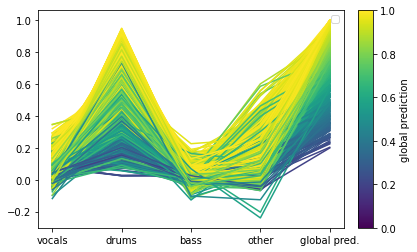

--- Execution Time: 10:45 seconds ---


In [12]:
start_time = time.time()
preprocess_instance_snippet(dataset_path, "Rock", model_path)
print(f"--- Execution Time: {time.strftime('%M:%S', time.gmtime(time.time() - start_time))} seconds ---")

Concatenate Test Data...
Snippet number 1
Predicted Rock with confidence of 0.26557525992393494
Not Target Genre ... continue
Snippet number 2
Predicted Instrumental with confidence of 0.453416645526886
Not Target Genre ... continue
Snippet number 3
Predicted Instrumental with confidence of 0.5065751671791077
Not Target Genre ... continue
Snippet number 4
Predicted Instrumental with confidence of 0.3756006360054016
Not Target Genre ... continue
Snippet number 5
Predicted Instrumental with confidence of 0.2597728371620178
Not Target Genre ... continue
Snippet number 6
Predicted Instrumental with confidence of 0.2956043481826782
Not Target Genre ... continue
Snippet number 7
Predicted Rock with confidence of 0.28602543473243713
Not Target Genre ... continue
Snippet number 8
Predicted Instrumental with confidence of 0.4277361035346985
Not Target Genre ... continue
Snippet number 9
Predicted Rock with confidence of 0.3015860319137573
Not Target Genre ... continue
Snippet number 10
Predicte

Model predictet Instrumental for permutation (0, 1, 0, 1); Target label with 0.4232082664966583
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.459208607673645
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.5020812749862671
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.2649495601654053
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.13151498138904572
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.2833009362220764
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.18093951046466827
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.42108991742134094
Model predictet Instrumental for permutation (1, 1, 0, 1); Target label with 0.33803102374076843
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.44781023263931274
Snippet number 31
Predicted Rock with confidence of

Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.9322531819343567
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.26637959480285645
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.8616704940795898
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.7046419978141785
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.9800689220428467
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.6210436224937439
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.9621779322624207
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.25883448123931885
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.9151119589805603
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.24809899926185608
Model predictet Electronic for permutation (1, 0, 1, 1); 

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2802400588989258
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.30482861399650574
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.8365270495414734
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.9360201358795166
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.800764799118042
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.9316833019256592
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.4025188982486725
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.427390992641449
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.41776326298713684
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.4096694588661194
Model predictet Electronic for permutation (1, 1, 0, 0); Tar

Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.7208530902862549
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.24080629646778107
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.702563464641571
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.722578227519989
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.9440184235572815
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.6914623975753784
Snippet number 52
Predicted Electronic with confidence of 0.9730008244514465
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.288015753030777
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.26047948002815247
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.3105924725532532
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with

Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.8652534484863281
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.12037619948387146
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.5659959316253662
Model predictet Classical for permutation (1, 0, 1, 0); Target label with 0.12661691009998322
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.5353789925575256
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.2341756969690323
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.7062821388244629
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.2744474411010742
Snippet number 58
Predicted Electronic with confidence of 0.8283624649047852
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.3019096255302429
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.

Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.9938021898269653
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.9007521271705627
Snippet number 64
Predicted Instrumental with confidence of 0.46290096640586853
Not Target Genre ... continue
Snippet number 65
Predicted Instrumental with confidence of 0.42272159457206726
Not Target Genre ... continue
Snippet number 66
Predicted Folk with confidence of 0.20100253820419312
Not Target Genre ... continue
Snippet number 67
Predicted Electronic with confidence of 0.9322436451911926
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.7406405806541443
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.26290497183799744
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.6940546631813049
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.768426239490509
Model predictet Electronic for permut

Model predictet Experimental for permutation (1, 1, 1, 0); Target label with 0.1385478675365448
Snippet number 75
Predicted Electronic with confidence of 0.2982702851295471
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.4238450527191162
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.35170555114746094
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.3611224591732025
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.24345247447490692
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.36949262022972107
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.22328779101371765
Model predictet Instrumental for permutation (0, 1, 1, 1); Target label with 0.3418879806995392
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.02413996122777462
Model predictet Instrumental for permutation (1, 0, 0, 1); Targe

Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.03626853972673416
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.2712527811527252
Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.06864222139120102
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.3281090557575226
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.23761457204818726
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.35835233330726624
Snippet number 84
Predicted Electronic with confidence of 0.3354285657405853
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.280103474855423
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.305663138628006
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.3633664548397064
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.

Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.4281667470932007
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.28541141748428345
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.5014181137084961
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.2857164144515991
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.5466773509979248
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.11942391842603683
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.3358428180217743
Model predictet Classical for permutation (1, 0, 1, 0); Target label with 0.16791464388370514
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.3596424162387848
Model predictet Classical for permutation (1, 1, 0, 0); Target label with 0.1774722784757614
Model predictet Electronic for permutation (1, 1, 0, 1); Tar

Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.24486573040485382
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.2666371762752533
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.19959916174411774
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.3249242305755615
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.31188538670539856
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.3403937518596649
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.3204081058502197
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.2808193564414978
Snippet number 116
Predicted Electronic with confidence of 0.24810491502285004
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.20034575462341309
Model predictet Electronic for permutation (0, 0, 1, 0); Target lab

Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.770351767539978
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.6606082320213318
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.8545880317687988
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.7409341335296631
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.13245071470737457
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.14262600243091583
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.1175307109951973
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.1280655711889267
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.4688795208930969
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.44348302483558655
Model predictet Electronic for permutation (1, 1, 

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.25544923543930054
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.5358601808547974
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.527500569820404
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.6964683532714844
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.638140082359314
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.8065844178199768
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.30503442883491516
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.519174337387085
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.30748599767684937
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.5441074967384338
Model predictet Electronic for permutation (1, 1, 0, 0); Tar

Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.5026850700378418
Snippet number 153
Predicted Rock with confidence of 0.4359006881713867
Not Target Genre ... continue
Snippet number 154
Predicted Electronic with confidence of 0.8797576427459717
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.3700876235961914
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.31881049275398254
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.5114652514457703
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.7185011506080627
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.8583936095237732
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.5548664331436157
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.8130837678909302
Model predictet Experimental for permutation (1, 0, 0, 0); Target l

Model predictet Jazz for permutation (0, 1, 1, 1); Target label with 0.1930798590183258
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.2865014672279358
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.13205796480178833
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.2805764377117157
Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.1849556863307953
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.17903903126716614
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.2624484598636627
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.1337345689535141
Snippet number 171
Predicted Rock with confidence of 0.24422022700309753
Not Target Genre ... continue
Snippet number 172
Predicted Electronic with confidence of 0.4414118230342865
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.

Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.5543805956840515
Model predictet International for permutation (0, 1, 1, 0); Target label with 0.33685821294784546
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.6133901476860046
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.46306875348091125
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.8267970085144043
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.5926252603530884
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.8156419992446899
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.3752661645412445
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.7350414991378784
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.5908248424530029
Snippet number 184
Predicted Electronic with confidence

Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.46478521823883057
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.366561621427536
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.39096540212631226
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.35982227325439453
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.5072739720344543
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.4458167850971222
Snippet number 190
Predicted Electronic with confidence of 0.9040223956108093
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.2992943823337555
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.339108943939209
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.4908338785171509
Model predictet Electronic for permutation (0, 1, 0, 0); Target label wit

Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.3702019453048706
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.24637562036514282
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.16965936124324799
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.25339916348457336
Snippet number 196
Predicted Electronic with confidence of 0.6218723654747009
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.2582545876502991
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2987053394317627
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.3549879789352417
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.529643714427948
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.5828181505203247
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.5

Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.9977527260780334
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.8936732411384583
Snippet number 202
Predicted Electronic with confidence of 0.40748682618141174
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.23099151253700256
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.3426152169704437
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.3874487578868866
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.468323677778244
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.45817604660987854
Model predictet International for permutation (0, 1, 1, 0); Target label with 0.3685136139392853
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.44083714485168457
Model predictet Experimental for permutation (1, 0, 0, 0); Target la

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.3415750563144684
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.16546332836151123
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.5999327898025513
Model predictet International for permutation (0, 1, 0, 1); Target label with 0.2382565438747406
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.5651080012321472
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.3329003155231476
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.4153272211551666
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.07274562865495682
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.3484940230846405
Model predictet International for permutation (1, 0, 1, 1); Target label with 0.16286388039588928
Model predictet Electronic for permutation (1, 1, 0, 0)

Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.8492870926856995
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.2935335636138916
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.5128452777862549
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.2655833065509796
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.41223347187042236
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.8124908208847046
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.9062790870666504
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.8079946041107178
Snippet number 221
Predicted Electronic with confidence of 0.828946590423584
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.425401508808136
Model predictet Electronic for permutation (0, 0, 1, 0); Target label wit

Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.3601595461368561
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.6576655507087708
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.3302484154701233
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.6061978340148926
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.30918627977371216
Snippet number 227
Predicted Electronic with confidence of 0.7736838459968567
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.21239769458770752
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2701966464519501
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.3061765432357788
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.5394130349159241
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0

Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.9042778015136719
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.9796273708343506
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.8292458057403564
Snippet number 233
Predicted Electronic with confidence of 0.8009563684463501
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.4663366377353668
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.28940412402153015
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.4831954836845398
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.5544081926345825
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.7139803767204285
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.6245043277740479
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 

Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.7621878981590271
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.659412145614624
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.8476223349571228
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.6125420928001404
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.866256058216095
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.5199958682060242
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.7864953875541687
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.6560637354850769
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.9140036702156067
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.8780806064605713
Model predictet Electronic for permutation (1, 1, 0, 1); Targe

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.30856502056121826
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.337837278842926
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.5253613591194153
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.6767003536224365
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.6431544423103333
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.8212735652923584
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.34987562894821167
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.4083384871482849
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.44399842619895935
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.5620613694190979
Model predictet Electronic for permutation (1, 1, 0, 0); T

Model predictet Experimental for permutation (1, 1, 1, 0); Target label with 0.391781210899353
Snippet number 252
Predicted Electronic with confidence of 0.7325721383094788
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.26015356183052063
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.2564919888973236
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.32028982043266296
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.4342834949493408
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.5461224913597107
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.43893587589263916
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.7669211626052856
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.18039606511592865
Model predictet Instrumental for permutation (1, 0, 0, 1); Target 

Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.5375729203224182
Snippet number 258
Predicted Electronic with confidence of 0.7325633764266968
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.3720507323741913
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.2438553124666214
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.40262213349342346
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.5368090867996216
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.7462678551673889
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.6192196607589722
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.8207984566688538
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.2812637686729431
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label w

Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.14327570796012878
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.12433124333620071
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.49010181427001953
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.4550757110118866
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.4565463364124298
Snippet number 268
Predicted Experimental with confidence of 0.40366238355636597
Not Target Genre ... continue
Snippet number 269
Predicted Experimental with confidence of 0.5107494592666626
Not Target Genre ... continue
Snippet number 270
Predicted Experimental with confidence of 0.42877399921417236
Not Target Genre ... continue
Snippet number 271
Predicted Electronic with confidence of 0.9533537030220032
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.3396516442298889
Model predictet Ele

Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.16930995881557465
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.3154827654361725
Model predictet Instrumental for permutation (1, 1, 0, 1); Target label with 0.13153842091560364
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.3688461482524872
Snippet number 287
Predicted Electronic with confidence of 0.46350371837615967
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.0324857234954834
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.31427672505378723
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.08763311803340912
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.342273086309433
Model predictet Instrumental for permutation (0, 1, 0, 1); Target label with 0.13877134025096893
Model predictet Electronic for permutation (0, 1, 1, 0); Target 

Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.8754140734672546
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.847672700881958
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.9755584001541138
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.3896224796772003
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.5272115468978882
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.4689214527606964
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.6501166820526123
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.6910083889961243
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.93089359998703
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.8827330470085144
Snippet number 297
Predicted Electronic with confidence of 0.98

Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.5272583961486816
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.8210326433181763
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.817526638507843
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.2919789254665375
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.3330402374267578
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.38131970167160034
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.5589371919631958
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.753673255443573
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.6607173681259155
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.9175156354904175
Snippet number 303
Predicted Electronic with confidence of 0.

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.28524190187454224
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.5988209247589111
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.7054932117462158
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.8763665556907654
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.7489449381828308
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.9640076160430908
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.44595101475715637
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.7316101789474487
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.4771232306957245
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.7211406230926514
Model predictet Electronic for permutation (1, 1, 0, 0); T

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.38038885593414307
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.6844431757926941
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.8309446573257446
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.7862787842750549
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.8155365586280823
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.8697667717933655
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.48590126633644104
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.614441990852356
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.5128324627876282
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.6623410582542419
Model predictet Electronic for permutation (1, 1, 0, 0); Ta

Predicted Electronic with confidence of 0.7117600440979004
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.3154081106185913
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.26523062586784363
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.31275731325149536
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.5313951969146729
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.6559378504753113
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.5550566911697388
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.6550855040550232
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.16573144495487213
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.23681777715682983
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.18273915

Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.7676400542259216
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.6905851364135742
Snippet number 329
Predicted Electronic with confidence of 0.765518307685852
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.7050250172615051
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.28172701597213745
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.6597689390182495
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.5612446069717407
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.7491242289543152
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.5998853445053101
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.759602963924408
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.

Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.3935161828994751
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.5293942093849182
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.8761724233627319
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.900607168674469
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.9072866439819336
Snippet number 336
Predicted International with confidence of 0.41831308603286743
Not Target Genre ... continue
Snippet number 337
Predicted Electronic with confidence of 0.41367313265800476
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.02646023966372013
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.28389662504196167
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.044980742037296295
Model predictet Electronic for permutation (0, 1, 0, 0);

Predicted Electronic with confidence of 0.8596789836883545
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.39970478415489197
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2919663190841675
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.42638203501701355
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.5566378235816956
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.6838539242744446
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.6485137343406677
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.8060460090637207
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.3385642170906067
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.5000524520874023
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.2851240038871765

Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.19862762093544006
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.30176061391830444
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.28894147276878357
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.44629037380218506
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.5325098633766174
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.543576180934906
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.7253670692443848
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.13468626141548157
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.093391552567482
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.0673004612326622
Model predictet Folk for permutation (1, 0, 1, 1); Tar

Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.6590904593467712
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.8386755585670471
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.7561482787132263
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.8907747268676758
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.4944058060646057
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.5682787895202637
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.5491570830345154
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.6455219388008118
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.8334193825721741
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.9212296009063721
Model predictet Electronic for permutation (1, 1, 1, 0); Tar

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2634965777397156
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.23116780817508698
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.6901808977127075
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.7915711402893066
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.6131507158279419
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.7312688827514648
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.16588129103183746
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.23974889516830444
Model predictet Spoken for permutation (1, 0, 1, 0); Target label with 0.18813908100128174
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.23063591122627258
Model predictet Electronic for permutation (1, 1, 0

Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.5306533575057983
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.7055065631866455
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.4453001618385315
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.5621505379676819
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.21477533876895905
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.3789121210575104
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.4197222888469696
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.692290723323822
Model predictet Experimental for permutation (1, 1, 0, 0); Target label with 0.23947450518608093
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.49449485540390015
Model predictet Experimental for permutation (1, 1, 1,

Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.650518536567688
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.8109093904495239
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.537043571472168
Snippet number 383
Predicted Electronic with confidence of 0.9735942482948303
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.37219732999801636
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2818756401538849
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.28921759128570557
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.8327039480209351
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.9640241265296936
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.9305804967880249
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0

Predicted Electronic with confidence of 0.40055933594703674
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.02547522261738777
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2566068172454834
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.024248670786619186
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.5218912959098816
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.4095340371131897
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.4850272834300995
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.3200182020664215
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.28542086482048035
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.026768067851662636
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.27980232238769

Model predictet Folk for permutation (1, 0, 1, 1); Target label with 0.1656988263130188
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.4155595600605011
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.31424862146377563
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.3521052300930023
Snippet number 404
Predicted Instrumental with confidence of 0.7814724445343018
Not Target Genre ... continue
Snippet number 405
Predicted Instrumental with confidence of 0.3504400849342346
Not Target Genre ... continue
Snippet number 406
Predicted Electronic with confidence of 0.5771753191947937
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.6011859178543091
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.3615517318248749
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.600250244140625
Model predictet Electronic for permutation (0, 1, 

Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.2899567484855652
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.6830064654350281
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.3111628293991089
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.6686180233955383
Model predictet Experimental for permutation (1, 1, 0, 0); Target label with 0.19854147732257843
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.6698903441429138
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.36950868368148804
Snippet number 414
Predicted Electronic with confidence of 0.7591866850852966
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.7242754101753235
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.29140907526016235
Model predictet Electronic for permutation (0, 0, 1, 1); Target label w

Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.35308459401130676
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.6134101152420044
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.25701889395713806
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.4946433901786804
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.3030140697956085
Snippet number 421
Predicted Experimental with confidence of 0.748663604259491
Not Target Genre ... continue
Snippet number 422
Predicted Experimental with confidence of 0.7338747978210449
Not Target Genre ... continue
Snippet number 423
Predicted Experimental with confidence of 0.6700612306594849
Not Target Genre ... continue
Snippet number 424
Predicted Experimental with confidence of 0.9150502681732178
Not Target Genre ... continue
Snippet number 425
Predicted Hip-Hop with confidence of 0.4522145092487335
Not Target Gen

Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.4632088243961334
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.4883384704589844
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.6923670768737793
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.6035267114639282
Snippet number 440
Predicted Electronic with confidence of 0.6411803364753723
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.4652767777442932
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2578921914100647
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.41768303513526917
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.4247452914714813
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.6944261789321899
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 

Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.2644716203212738
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.3010950982570648
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.3155836760997772
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.4724029302597046
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.5121212601661682
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.3749461770057678
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.48088952898979187
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.32219943404197693
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.2915857434272766
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.25974151492118835
Model predictet Electronic for permutation (1, 0, 1, 1); 

Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.40945425629615784
Snippet number 459
Predicted Electronic with confidence of 0.9479051828384399
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.8928952217102051
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.3835190236568451
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.9101684093475342
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.4058166444301605
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.8922201991081238
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.5980163812637329
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.9315255880355835
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.3134290277957916
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 

Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.9404361844062805
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.7515616416931152
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.9472940564155579
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.36937785148620605
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.750324547290802
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.45202866196632385
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.7165606021881104
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.7003774642944336
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.9470193982124329
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.7607695460319519
Snippet number 467
Predicted Electronic with confidence o

Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.2846481204032898
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.3536461293697357
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.5867350697517395
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.4650416970252991
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.4829423427581787
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.45230403542518616
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.5013205409049988
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.2844732701778412
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.44460329413414
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.42647603154182434
Model predictet Electronic for permutation (1, 0, 1, 1); T

Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.11814375221729279
Snippet number 481
Predicted Electronic with confidence of 0.3339731991291046
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.37014690041542053
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.45297715067863464
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.5713803172111511
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.2896428406238556
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.2881009578704834
Model predictet Experimental for permutation (0, 1, 1, 0); Target label with 0.26202917098999023
Model predictet Experimental for permutation (0, 1, 1, 1); Target label with 0.22653791308403015
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.2749386429786682
Model predictet Electronic for permutation (1, 0, 0, 1); Target label wit

Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.4690805673599243
Snippet number 487
Predicted Electronic with confidence of 0.3975604772567749
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.2789863348007202
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.3263622224330902
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.3734537959098816
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.41857436299324036
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.47456347942352295
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.3565349280834198
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.4278843104839325
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.2925185263156891
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with

Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.7083401679992676
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.9364869594573975
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.7242690920829773
Snippet number 493
Predicted Electronic with confidence of 0.49071115255355835
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.29742664098739624
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.31939488649368286
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.4078114330768585
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.3755742013454437
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.48178359866142273
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.24995839595794678
Model predictet Electronic for permutation (0, 1, 1, 1); Target label w

Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.19158624112606049
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.974794864654541
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.9714756608009338
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.9884981513023376
Snippet number 500
Predicted Electronic with confidence of 0.920017659664154
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.3944427967071533
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2697778642177582
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.39284273982048035
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.8825013637542725
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.894438624382019
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 

Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.17896375060081482
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.5948767066001892
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.5739361643791199
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.530012309551239
Snippet number 506
Predicted Hip-Hop with confidence of 0.6101406812667847
Not Target Genre ... continue
Snippet number 507
Predicted Electronic with confidence of 0.8981958031654358
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.31522685289382935
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.2733319103717804
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.29369449615478516
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.9368106126785278
Model predictet Electronic for permutation (0, 1, 0, 1); Ta

Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.3708440363407135
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.21502718329429626
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.9266380667686462
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.909762978553772
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.9406543970108032
Snippet number 515
Predicted Electronic with confidence of 0.6487059593200684
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.32053646445274353
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2803226709365845
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.27819669246673584
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.6506680250167847
Model predictet Electronic for permutation (0, 1, 0, 1); Target label 

Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.6852326393127441
Snippet number 524
Predicted Electronic with confidence of 0.7051790356636047
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.4096517264842987
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.31808194518089294
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.5362231731414795
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.548738956451416
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.6954001784324646
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.499280720949173
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.7394022941589355
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.17715992033481598
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with

Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.3585841953754425
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.32955682277679443
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.4561924934387207
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.7765217423439026
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.8030065298080444
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.8638471364974976
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.8656523823738098
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.30492016673088074
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.4359321892261505
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.3775699734687805
Model predictet Electronic for permutation (1, 0, 1, 1); T

Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.232656791806221
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.6364967226982117
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.32353073358535767
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.5988868474960327
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.6879844665527344
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.8635146617889404
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.5729433298110962
Snippet number 541
Predicted Electronic with confidence of 0.24409028887748718
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.19185835123062134
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.3627875745296478
Model predictet Electronic for permutation (0, 0, 1, 1); Target label wit

Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.7248116731643677
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.6762804388999939
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.7437495589256287
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.7288557887077332
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.23467518389225006
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.259846955537796
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.18062788248062134
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.18383079767227173
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.6787769794464111
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.6867643594741821
Model predictet Electronic for permutation (1, 1, 

Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.24471336603164673
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.053992874920368195
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.33799415826797485
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.3242357671260834
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.8612930178642273
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.3140370547771454
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.8764375448226929
Model predictet Instrumental for permutation (1, 1, 0, 0); Target label with 0.02345968410372734
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.34384408593177795
Model predictet Experimental for permutation (1, 1, 1, 0); Target label with 0.08112726360559464
Snippet number 558
Predicted Electronic with confidence

Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.2826019525527954
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.29176896810531616
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.33172768354415894
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.40083739161491394
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.6158604621887207
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.651990532875061
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.6288615465164185
Snippet number 568
Predicted Electronic with confidence of 0.7417854070663452
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.26035425066947937
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.33405980467796326
Model predictet Electronic for permutation (0, 0, 1, 1); Target labe

Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.34355345368385315
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.5503158569335938
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.3486047089099884
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.23819778859615326
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.3211959898471832
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.45572903752326965
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.25169023871421814
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.36702096462249756
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.2656916081905365
Snippet number 574
Predicted Electronic with confidence of 0.8677150011062622
Model predictet Electronic for permutation (0, 0, 0, 1); Target lab

Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.3439345359802246
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.6922163963317871
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.8182461261749268
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.7449945211410522
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.8806806206703186
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.41206228733062744
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.562768816947937
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.39249387383461
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.583014965057373
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.8607149720191956
Model predictet Electronic for permutation (1, 1, 0, 1); Target

Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.2699596881866455
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.2991170883178711
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.6407757997512817
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.7771097421646118
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.7565280795097351
Snippet number 593
Predicted Electronic with confidence of 0.9513237476348877
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.35567253828048706
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.2765901982784271
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.47527045011520386
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.7593708038330078
Model predictet Electronic for permutation (0, 1, 0, 1); Target label wi

Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.47560474276542664
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.8215579390525818
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.8953638076782227
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.8351830840110779
Snippet number 599
Predicted Electronic with confidence of 0.9257885217666626
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.27816328406333923
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.3568311631679535
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.3405705988407135
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.826849639415741
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.8199014067649841
Model predictet Electronic for permutation (0, 1, 1, 0); Target label wit

Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.2177167385816574
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.315792977809906
Model predictet Experimental for permutation (1, 1, 0, 0); Target label with 0.20402289927005768
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.3315615952014923
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.22941622138023376
Snippet number 605
Predicted Electronic with confidence of 0.6899971961975098
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.2900494933128357
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.27324920892715454
Model predictet Experimental for permutation (0, 0, 1, 1); Target label with 0.37039878964424133
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.327842652797699
Model predictet International for permutation (0, 1, 0, 1); Target lab

Predicted Electronic with confidence of 0.8727741837501526
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.5483248233795166
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.27981773018836975
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.5709128379821777
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.5147782564163208
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.7815787196159363
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.4877304136753082
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.8046537041664124
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.23609475791454315
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.5269500017166138
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.2609927356243133

Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.5407790541648865
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.4986127018928528
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.5186571478843689
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.5635402202606201
Snippet number 620
Predicted Electronic with confidence of 0.8633998036384583
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.3240499198436737
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2785419523715973
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.39068934321403503
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.690095841884613
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.7553046941757202
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0

Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.3640971779823303
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.5144881010055542
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.6983869671821594
Model predictet Hip-Hop for permutation (0, 1, 1, 0); Target label with 0.29331377148628235
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.5703045725822449
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.37186914682388306
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.2917539179325104
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.42714712023735046
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.44073203206062317
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.5609452724456787
Model predictet Electronic for permutation (1, 1, 0, 1); Ta

Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.11111615598201752
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.2710362374782562
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.21087069809436798
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.40117383003234863
Model predictet Instrumental for permutation (0, 1, 0, 1); Target label with 0.17006459832191467
Model predictet Experimental for permutation (0, 1, 1, 0); Target label with 0.31646499037742615
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.5611041784286499
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.2849638760089874
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.10493823140859604
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.334955096244812
Model predictet Instrumental for permutatio

Model predictet Instrumental for permutation (1, 0, 1, 0); Target label with 0.25502967834472656
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.07516560703516006
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.6996468305587769
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.7192269563674927
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.8631535768508911
Snippet number 643
Predicted Electronic with confidence of 0.7510936856269836
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.5170369744300842
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.24990452826023102
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.4977584779262543
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.6468615531921387
Model predictet Electronic for permutation (0, 1, 0, 1); Target lab

Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.28774526715278625
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.3096497356891632
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.29241064190864563
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.31609758734703064
Model predictet Instrumental for permutation (0, 1, 0, 1); Target label with 0.2455029934644699
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.4342905282974243
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.33299413323402405
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.32101956009864807
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.36660656332969666
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.4138980805873871
Model predictet Electronic for permutation (1, 0, 

Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.5510454773902893
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.4321955442428589
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.5335654616355896
Snippet number 659
Predicted Electronic with confidence of 0.6803159713745117
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.33160966634750366
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.3251028060913086
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.40223386883735657
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.5055145621299744
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.42625775933265686
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.55765300989151
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 

Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.7434540390968323
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.9556406736373901
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.7154077291488647
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.9028540253639221
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.37264421582221985
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.8053316473960876
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.22665224969387054
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.5489291548728943
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.7087613940238953
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.9652702808380127
Model predictet Electronic for permutation (1, 1, 1, 0);

Model predictet International for permutation (1, 0, 1, 0); Target label with 0.20059770345687866
Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.042168568819761276
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.45701584219932556
Model predictet Classical for permutation (1, 1, 0, 1); Target label with 0.24619661271572113
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.4478416442871094
Snippet number 672
Predicted Electronic with confidence of 0.5828526020050049
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.1642417162656784
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.3181460499763489
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.29305025935173035
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.39744824171066284
Model predictet Electronic for permutation (0, 1, 0, 1); Target label

Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.6692653298377991
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.7957013249397278
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.6780324578285217
Snippet number 678
Predicted Electronic with confidence of 0.7248296737670898
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.2040581852197647
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.3286992311477661
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.303343266248703
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.609307587146759
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.5948716998100281
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.5446285009384155
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0

Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.18733032047748566
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.36717724800109863
Model predictet International for permutation (1, 1, 0, 0); Target label with 0.13210327923297882
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.5107788443565369
Model predictet International for permutation (1, 1, 1, 0); Target label with 0.1849866509437561
Snippet number 685
Predicted Instrumental with confidence of 0.4545558989048004
Not Target Genre ... continue
Snippet number 686
Predicted Instrumental with confidence of 0.3831711411476135
Not Target Genre ... continue
Snippet number 687
Predicted Classical with confidence of 0.5704167485237122
Not Target Genre ... continue
Snippet number 688
Predicted Electronic with confidence of 0.7635673880577087
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.23246881365776062
Model predictet E

Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.8516917824745178
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.6687584519386292
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.8444837927818298
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.4658952057361603
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.7344265580177307
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.6120431423187256
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.7387056946754456
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.7834597826004028
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.9038135409355164
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.8124003410339355
Snippet number 694
Predicted Electronic with confidence of 0

Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.26255789399147034
Model predictet Instrumental for permutation (1, 1, 0, 1); Target label with 0.2513740658760071
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.2940598726272583
Snippet number 700
Predicted Instrumental with confidence of 0.5926559567451477
Not Target Genre ... continue
Snippet number 701
Predicted Instrumental with confidence of 0.7085665464401245
Not Target Genre ... continue
Snippet number 702
Predicted Instrumental with confidence of 0.5158563852310181
Not Target Genre ... continue
Snippet number 703
Predicted Instrumental with confidence of 0.44112005829811096
Not Target Genre ... continue
Snippet number 704
Predicted Rock with confidence of 0.4639117419719696
Not Target Genre ... continue
Snippet number 705
Predicted Rock with confidence of 0.43829309940338135
Not Target Genre ... continue
Snippet number 706
Predicted Instrumental with confidence of 0.693418

Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.4711619019508362
Snippet number 715
Predicted International with confidence of 0.5458557605743408
Not Target Genre ... continue
Snippet number 716
Predicted International with confidence of 0.7090657949447632
Not Target Genre ... continue
Snippet number 717
Predicted Electronic with confidence of 0.313295841217041
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.28904250264167786
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.27583715319633484
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.4310745894908905
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.3249633312225342
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.31340542435646057
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.2821720540523529
Model predictet Electronic for permutati

Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.25819358229637146
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.3512137830257416
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.3781897723674774
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.40733420848846436
Snippet number 723
Predicted Electronic with confidence of 0.6700158715248108
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.3893183469772339
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2695457339286804
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.4245733916759491
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.4806394577026367
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.6172299385070801
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with

Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.12581880390644073
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.08166220039129257
Model predictet Classical for permutation (1, 0, 1, 0); Target label with 0.1615881472826004
Model predictet Classical for permutation (1, 0, 1, 1); Target label with 0.15531383454799652
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.5982601046562195
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.67376309633255
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.7481920719146729
Snippet number 730
Predicted Electronic with confidence of 0.39173051714897156
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.20627665519714355
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.28274309635162354
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0

Predicted Instrumental with confidence of 0.3764951527118683
Not Target Genre ... continue
Snippet number 746
Predicted Instrumental with confidence of 0.2719552218914032
Not Target Genre ... continue
Snippet number 747
Predicted Instrumental with confidence of 0.387453556060791
Not Target Genre ... continue
Snippet number 748
Predicted Electronic with confidence of 0.72895348072052
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.3774776756763458
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.2705618441104889
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.38477885723114014
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.7095221877098083
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.819911003112793
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.5904499888420105
Model predictet Electronic for permutation (0, 1

Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.7576920986175537
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.9475685358047485
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.8033745288848877
Snippet number 758
Predicted Electronic with confidence of 0.6627655625343323
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.3163236081600189
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.509967565536499
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.6818217039108276
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.26554811000823975
Model predictet Instrumental for permutation (0, 1, 0, 1); Target label with 0.2728199362754822
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.4888303875923157
Model predictet Electronic for permutation (0, 1, 1, 1); Target label wi

Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.5710578560829163
Snippet number 766
Predicted Electronic with confidence of 0.26977360248565674
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.2178429514169693
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2616615295410156
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.21431761980056763
Model predictet Experimental for permutation (0, 1, 0, 0); Target label with 0.108686164021492
Model predictet Instrumental for permutation (0, 1, 0, 1); Target label with 0.2350836545228958
Model predictet Experimental for permutation (0, 1, 1, 0); Target label with 0.14178715646266937
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.30902326107025146
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.1264222413301468
Model predictet Instrumental for permutation (1, 0, 0, 1); Targe

Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.48682302236557007
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.31679344177246094
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.3444518744945526
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.31257376074790955
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.4271796941757202
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.2629135251045227
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.19144845008850098
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.30193063616752625
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.39229944348335266
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.2920290529727936
Model predictet Electronic for permutation (1, 1, 0, 1

Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.4832892417907715
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.5453824400901794
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.5901077389717102
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.43047890067100525
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.38198035955429077
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.41277194023132324
Snippet number 782
Predicted Electronic with confidence of 0.44505903124809265
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.20016221702098846
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.32828229665756226
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.2935272455215454
Model predictet Electronic for permutation (0, 1, 0, 0); Target label w

Predicted Instrumental with confidence of 0.34126192331314087
Not Target Genre ... continue
Snippet number 789
Predicted Instrumental with confidence of 0.32426905632019043
Not Target Genre ... continue
Snippet number 790
Predicted Electronic with confidence of 0.7416006922721863
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.46378621459007263
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.3006879985332489
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.49376505613327026
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.44069480895996094
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.6198017001152039
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.43296366930007935
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.6606958508491516
Model predictet Electronic for permutation (1, 0, 0, 0); 

Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.37177494168281555
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.6351333260536194
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.6597236394882202
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.6838500499725342
Snippet number 796
Predicted Electronic with confidence of 0.8392375111579895
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.2024172842502594
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.3342086374759674
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.33855628967285156
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.5810842514038086
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.5451151132583618
Model predictet Electronic for permutation (0, 1, 1, 0); Target label wi

Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.7950605750083923
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2618333399295807
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.8109225034713745
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.28568699955940247
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.7771222591400146
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.2893010079860687
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.8272513151168823
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.2590354084968567
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.7917308807373047
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.24375030398368835
Model predictet Electronic for permutation (1, 0, 1, 1);

Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.6852028369903564
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.9014313220977783
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.28658291697502136
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.3673066198825836
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.3929429054260254
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.590846598148346
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.5489286780357361
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.7299041748046875
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.6878232359886169
Snippet number 813
Predicted Electronic with confidence of 0.5207744240760803
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with

Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.6829546689987183
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.15289203822612762
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.15381626784801483
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.18839675188064575
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.15649475157260895
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.6911410689353943
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.6883037090301514
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.6497622728347778
Snippet number 822
Predicted Electronic with confidence of 0.7943668961524963
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.26752832531929016
Model predictet Electronic for permutation (0, 0, 1, 0); Target

Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.9649695754051208
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.9813528656959534
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.9767617583274841
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.29718756675720215
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.32673379778862
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.29890501499176025
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.3750317096710205
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.967808723449707
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.9551576375961304
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.9779158234596252
Snippet number 829
Predicted Electronic with confidence

Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.6089059114456177
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.697454035282135
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.7965809106826782
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.2723325490951538
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.4262125492095947
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.3770492970943451
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.5435522794723511
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.5592665076255798
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.7367338538169861
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.7147018313407898
Snippet number 835
Predicted Electronic with confidence of 

Predicted Electronic with confidence of 0.2633538842201233
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.3929753005504608
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.27251601219177246
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.3635827898979187
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.3704383969306946
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.33220624923706055
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.33410632610321045
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.3011053502559662
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.22480420768260956
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.3405183255672455
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.2167497277

Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.28432074189186096
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.4264580011367798
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.3819788992404938
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.5096740126609802
Model predictet Instrumental for permutation (1, 1, 1, 0); Target label with 0.2805538773536682
Snippet number 852
Predicted Electronic with confidence of 0.8367811441421509
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.35358572006225586
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.27320560812950134
Model predictet Experimental for permutation (0, 0, 1, 1); Target label with 0.36417388916015625
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.7940695881843567
Model predictet Electronic for permutation (0, 1, 0, 1); Target la

Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.5863478183746338
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.48403677344322205
Snippet number 858
Predicted Electronic with confidence of 0.730766773223877
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.14107945561408997
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.25514718890190125
Model predictet Experimental for permutation (0, 0, 1, 1); Target label with 0.1903243511915207
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.6384677290916443
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.6485387682914734
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.6016217470169067
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.6819563508033752
Model predictet Electronic for permutation (1, 0, 0, 0); Target label wit

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.26636919379234314
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.05127464234828949
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.8096984624862671
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.731467068195343
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.7683778405189514
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.7136114835739136
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.39629247784614563
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.12018130719661713
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.40765392780303955
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.14789234101772308
Model predictet Electronic for permutation (1, 1, 0,

Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.579267680644989
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.46116378903388977
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.574349582195282
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.7350376844406128
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.7873862981796265
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.8361054062843323
Snippet number 872
Predicted Electronic with confidence of 0.47391247749328613
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.38351970911026
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2674688994884491
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.30058664083480835
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.4

Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.827419638633728
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.5674581527709961
Snippet number 879
Predicted Electronic with confidence of 0.6640065908432007
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.46353957056999207
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.49444276094436646
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.7098172307014465
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.5398532152175903
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.8019428253173828
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.5631794333457947
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.77997887134552
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.

Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.5254897475242615
Model predictet Experimental for permutation (0, 0, 1, 0); Target label with 0.24321933090686798
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.5219591856002808
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.5266141891479492
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.895274817943573
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.5339542031288147
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.7916866540908813
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.28486695885658264
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.5340690612792969
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.2811574935913086
Model predictet Electronic for permutation (1, 0, 1, 1); 

Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.20512278378009796
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.6009073853492737
Model predictet International for permutation (0, 1, 0, 1); Target label with 0.3138304054737091
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.5819034576416016
Model predictet International for permutation (0, 1, 1, 1); Target label with 0.391710102558136
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.4089265465736389
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.24059566855430603
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.43846434354782104
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.3579677641391754
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.7263402938842773
Model predictet Electronic for permutation (1, 1

Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.5916666388511658
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.7128601670265198
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.8928109407424927
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.9372825026512146
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.9585219025611877
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.28832200169563293
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.6476603746414185
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.32289189100265503
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.570372998714447
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.7170800566673279
Model predictet Electronic for permutation (1, 1, 0, 1); 

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.42882949113845825
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.4199059307575226
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.9225274920463562
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.9127918481826782
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.9079979658126831
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.9107875823974609
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.13793015480041504
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.12911991775035858
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.14648602902889252
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.15351489186286926
Model predictet Electronic for permutation (1, 

Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.2885861396789551
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.30914512276649475
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.29538339376449585
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.439242422580719
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.8672155141830444
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.24541021883487701
Snippet number 924
Predicted Electronic with confidence of 0.8648404479026794
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.4173870086669922
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.24765199422836304
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.40591639280319214
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.38

Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.3214547336101532
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.31827208399772644
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.1988184005022049
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.4851614236831665
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.24918554723262787
Snippet number 931
Predicted Rock with confidence of 0.386947900056839
Not Target Genre ... continue
Snippet number 932
Predicted Rock with confidence of 0.3808271884918213
Not Target Genre ... continue
Snippet number 933
Predicted Rock with confidence of 0.27000686526298523
Not Target Genre ... continue
Snippet number 934
Predicted Electronic with confidence of 0.5076480507850647
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.3199720084667206
Model predictet Electronic for permutation (0, 0, 

Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.6071422100067139
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.6479148268699646
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.7710566520690918
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.29286542534828186
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.2297830879688263
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.3298298716545105
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.3572463393211365
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.4583813548088074
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.5265908241271973
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.5695935487747192
Snippet number 946
Predicted Electronic with confidence

Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.33420854806900024
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.5096327066421509
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.6211373209953308
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.7520291805267334
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.54617840051651
Snippet number 952
Predicted Electronic with confidence of 0.8027589917182922
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.3753063678741455
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.280391126871109
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.3332447409629822
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.464946985244751
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.64

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.27556660771369934
Model predictet International for permutation (0, 0, 1, 1); Target label with 0.15925127267837524
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.560346782207489
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.4172455668449402
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.4500618875026703
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.4592701494693756
Model predictet International for permutation (1, 0, 0, 0); Target label with 0.14348286390304565
Model predictet International for permutation (1, 0, 0, 1); Target label with 0.033972159028053284
Model predictet International for permutation (1, 0, 1, 0); Target label with 0.16991572082042694
Model predictet International for permutation (1, 0, 1, 1); Target label with 0.01996065303683281
Model predictet Electronic for permutat

Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.5027784705162048
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.27102115750312805
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.40296101570129395
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.6023269295692444
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.550943911075592
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.48847970366477966
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.4895298480987549
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.22148533165454865
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.3603987991809845
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.19510748982429504
Model predictet Experimental for permutation (1, 0, 

Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.3148515224456787
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.43937405943870544
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.4931725263595581
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.4278635084629059
Snippet number 979
Predicted Electronic with confidence of 0.5610595941543579
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.4576987326145172
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.33149656653404236
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.5626708269119263
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.30927905440330505
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.38461384177207947
Model predictet Electronic for permutation (0, 1, 1, 0); Target label 

Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.8097202777862549
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.846276044845581
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.7391946911811829
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.8075825572013855
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.2940102517604828
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.3171508014202118
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.37901267409324646
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.42465734481811523
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.7629595994949341
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.835033655166626
Model predictet Electronic for permutation (1, 1, 1, 0); T

Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.37328046560287476
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.3243417739868164
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.3844427764415741
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.4592435956001282
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.7557119131088257
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.532337486743927
Snippet number 1004
Predicted Electronic with confidence of 0.6298177242279053
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.46051567792892456
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2774257957935333
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.49705633521080017
Model predictet Electronic for permutation (0, 1, 0, 0); Target label wit

Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.2894785702228546
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.28430846333503723
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.27049151062965393
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.16773328185081482
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.3123050332069397
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.3695116937160492
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.4389503002166748
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.5552811622619629
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.4059208631515503
Snippet number 1011
Predicted Electronic with confidence of 0.8053336143493652
Model predictet Electronic for permutation (0, 0, 0, 1); Target label wit

Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.41481298208236694
Model predictet International for permutation (0, 1, 1, 1); Target label with 0.2532990574836731
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.36985549330711365
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.27774786949157715
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.38190343976020813
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.17942336201667786
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.5469212532043457
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.5178112983703613
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.4602583646774292
Snippet number 1017
Predicted International with confidence of 0.6625698208808899
Not Target Genre ... continue
Snippet number 1018
Predic

Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.49387213587760925
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.3946261405944824
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.5652140378952026
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.43545180559158325
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.6982586979866028
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.4869600236415863
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.7256585359573364
Model predictet Experimental for permutation (1, 1, 0, 0); Target label with 0.245174840092659
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.3843201994895935
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.3532082438468933
Snippet number 1024
Predicted Electronic with confidence 

Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.2458367645740509
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.4507732391357422
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.32102084159851074
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.5483169555664062
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.5919255018234253
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.6670407652854919
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.6919935345649719
Snippet number 1030
Predicted Electronic with confidence of 0.3529869318008423
Model predictet International for permutation (0, 0, 0, 1); Target label with 0.24696803092956543
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.26904410123825073
Model predictet Electronic for permutation (0, 0, 1, 1); Target l

Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.4928159713745117
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.3279935121536255
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.45369067788124084
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.2846444547176361
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.3282073736190796
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.28763318061828613
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.3379592001438141
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.3620692193508148
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.5247458815574646
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.3414275348186493
Snippet number 1037
Predicted Instrumental with confidence

Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.5461240410804749
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.5391589403152466
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.7110212445259094
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.5190095901489258
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.663493812084198
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.2830374538898468
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.6359611749649048
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.31883078813552856
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.5887982249259949
Model predictet Experimental for permutation (1, 1, 0, 0); Target label with 0.4486285150051117
Model predictet Electronic for permutation (1, 1, 0, 1);

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.26204487681388855
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.28228214383125305
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.40424099564552307
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.42070674896240234
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.24554193019866943
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.342954158782959
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.21479646861553192
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.2177707701921463
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.1728026121854782
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.2590699791908264
Model predictet Electronic for permutation (1, 1, 0

Predicted Experimental with confidence of 0.5285553336143494
Not Target Genre ... continue
Snippet number 1056
Predicted Electronic with confidence of 0.633508563041687
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.4640580713748932
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2819979786872864
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.5931965112686157
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.29575034976005554
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.5406666398048401
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.328195720911026
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.6442392468452454
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.2699066698551178
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.50

Model predictet Instrumental for permutation (0, 1, 0, 1); Target label with 0.2490023672580719
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.3524222671985626
Model predictet Instrumental for permutation (0, 1, 1, 1); Target label with 0.27904844284057617
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.268992155790329
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.2108987420797348
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.33880671858787537
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.28786420822143555
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.2687990963459015
Model predictet Instrumental for permutation (1, 1, 0, 1); Target label with 0.2608024775981903
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.382527232170105
Snippet number 1075
Predicted Instrumental with c

Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.7076553106307983
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.9319567680358887
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.32610610127449036
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.38824939727783203
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.3985028564929962
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.4670151174068451
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.5295604467391968
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.8157091736793518
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.6993369460105896
Snippet number 1083
Predicted Electronic with confidence of 0.9809273481369019
Model predictet Electronic for permutation (0, 0, 0, 1); Target label w

Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.2506122291088104
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.9043916463851929
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.9367347955703735
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.8680897355079651
Snippet number 1089
Predicted Electronic with confidence of 0.8564074635505676
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.33489036560058594
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.25591766834259033
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.3103627562522888
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.6912174224853516
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.7535668015480042
Model predictet Electronic for permutation (0, 1, 1, 0); Target label

Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.21886558830738068
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.27657759189605713
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.30335819721221924
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.5014687180519104
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.3739834725856781
Snippet number 1095
Predicted Electronic with confidence of 0.618876039981842
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.10301770269870758
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.31035667657852173
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.1891816258430481
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.36284446716308594
Model predictet Electronic for permutation (0, 1, 0, 1); Target la

Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.5159631371498108
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.5145210027694702
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.29413458704948425
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.3352777361869812
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.213145449757576
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.2044701725244522
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.6089373230934143
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.4459911286830902
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.5127776265144348
Snippet number 1110
Predicted Rock with confidence of 0.2802439332008362
Not Target Genre ... continue
Snippet number 1111
Predicted Electronic wi

Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.31326261162757874
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.2686738967895508
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.3819423019886017
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.2120463252067566
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.7065486907958984
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.746070921421051
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.5617629885673523
Snippet number 1117
Predicted Electronic with confidence of 0.9092946648597717
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.6420261859893799
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.265849769115448
Model predictet Electronic for permutation (0, 0, 1, 1); Target label 

Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.771923303604126
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.25302374362945557
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.2189808040857315
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.2774296700954437
Model predictet Rock for permutation (1, 0, 1, 1); Target label with 0.10413774102926254
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.5229529142379761
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.7209118604660034
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.5540559887886047
Snippet number 1124
Predicted Electronic with confidence of 0.8333193063735962
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.3668869435787201
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2

Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.5949544310569763
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.5383314490318298
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.4175008237361908
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.3561376929283142
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.47717589139938354
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.3450975716114044
Model predictet Old-Time / Historic for permutation (1, 0, 1, 1); Target label with 0.1664806306362152
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.8245519399642944
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.7189117074012756
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.6727707982063293
Snippet number 1132
Predicted Electronic with conf

Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.39615899324417114
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.4973546862602234
Model predictet International for permutation (0, 1, 0, 1); Target label with 0.3475159704685211
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.5672589540481567
Model predictet International for permutation (0, 1, 1, 1); Target label with 0.3662339746952057
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.2643202841281891
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.36636433005332947
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.2589900493621826
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.3307056725025177
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.7090775966644287
Model predictet Electronic for permutation (1, 1, 

Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.5840326547622681
Snippet number 1145
Predicted Electronic with confidence of 0.48571810126304626
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.15282176434993744
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2934762239456177
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.21704989671707153
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.5888426303863525
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.5557453632354736
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.3729085624217987
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.4072704017162323
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.2755098342895508
Model predictet Experimental for permutation (1, 0, 0, 1); Target la

Model predictet International for permutation (0, 1, 1, 1); Target label with 0.38102343678474426
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.2369624376296997
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.14741158485412598
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.2600601017475128
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.25481292605400085
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.2660462558269501
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.240075021982193
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.3387604355812073
Snippet number 1157
Predicted Rock with confidence of 0.5994827747344971
Not Target Genre ... continue
Snippet number 1158
Predicted Rock with confidence of 0.4435133635997772
Not Target Genre ... continue
Snippet number 1159
Predicted Rock wi

Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.13364455103874207
Model predictet Rock for permutation (1, 1, 0, 0); Target label with 0.20211809873580933
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.2810547351837158
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.17308048903942108
Snippet number 1171
Predicted Instrumental with confidence of 0.3856652081012726
Not Target Genre ... continue
Snippet number 1172
Predicted Instrumental with confidence of 0.4750395119190216
Not Target Genre ... continue
Snippet number 1173
Predicted Instrumental with confidence of 0.8813028335571289
Not Target Genre ... continue
Snippet number 1174
Predicted Electronic with confidence of 0.23638916015625
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.28899407386779785
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.30064550042152405
Model predictet Instrumental 

Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.32668182253837585
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.9385066628456116
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.9193118810653687
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.8753901124000549
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.8915807604789734
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.5286931991577148
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.6030139923095703
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.5037010908126831
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.5137355923652649
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.8504643440246582
Model predictet Electronic for permutation (1, 1, 0, 1); Ta

Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.10520067065954208
Model predictet Spoken for permutation (1, 0, 1, 0); Target label with 0.04728920757770538
Model predictet Spoken for permutation (1, 0, 1, 1); Target label with 0.0632859319448471
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.7410869598388672
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.7788565754890442
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.7947837114334106
Snippet number 1190
Predicted International with confidence of 0.2811565399169922
Not Target Genre ... continue
Snippet number 1191
Predicted International with confidence of 0.49752241373062134
Not Target Genre ... continue
Snippet number 1192
Predicted Electronic with confidence of 0.8362250328063965
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.25476619601249695
Model predictet Electronic for permutat

Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.5824053883552551
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.8877543210983276
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.6591753363609314
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.9231101870536804
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.33448317646980286
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.22487220168113708
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.37849798798561096
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.5185297727584839
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.6135881543159485
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.9077906012535095
Model predictet Electronic for permutation (1, 1, 1, 0); T

Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.7508339881896973
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.6585890650749207
Snippet number 1211
Predicted Electronic with confidence of 0.7898774743080139
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.3648279905319214
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.29734206199645996
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.4565238654613495
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.6765956282615662
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.7844811081886292
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.646108865737915
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.7702245712280273
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 

Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.056123703718185425
Model predictet Hip-Hop for permutation (0, 1, 0, 0); Target label with 0.3117099702358246
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.5701103210449219
Model predictet Hip-Hop for permutation (0, 1, 1, 0); Target label with 0.40327098965644836
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.5062065124511719
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.2831498384475708
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.07741253823041916
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.29352447390556335
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.05959692969918251
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.4138343930244446
Model predictet Electronic for permutation (1, 1, 0, 1); 

Predicted Electronic with confidence of 0.8086615800857544
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.2259620726108551
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.4196797013282776
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.5575996041297913
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.7952815294265747
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.8482064008712769
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.7819357514381409
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.896493136882782
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.13530553877353668
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.1237998828291893
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.1841554641

Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.2798481583595276
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.27909207344055176
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.48772871494293213
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.3020383417606354
Snippet number 1241
Predicted Instrumental with confidence of 0.6156331896781921
Not Target Genre ... continue
Snippet number 1242
Predicted Electronic with confidence of 0.1970885694026947
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.30182528495788574
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.23983800411224365
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.27263036370277405
Model predictet Experimental for permutation (0, 1, 0, 0); Target label with 0.20198975503444672
Model predictet Instrumental for permutation

Predicted Electronic with confidence of 0.8567168116569519
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.3806277811527252
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2710353434085846
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.3596503734588623
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.6184553503990173
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.7925574779510498
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.666400671005249
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.8385640382766724
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.298676460981369
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.4799794852733612
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.2939348220825195

Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.24441665410995483
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.3032298982143402
Model predictet Experimental for permutation (0, 0, 1, 1); Target label with 0.29863953590393066
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.2651347815990448
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.3324384093284607
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.26407018303871155
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.37563076615333557
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.2995876371860504
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.31239861249923706
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.3534058928489685
Model predictet Experimental for permutation (1, 

Model predictet Hip-Hop for permutation (1, 0, 0, 0); Target label with 0.04035249352455139
Model predictet Spoken for permutation (1, 0, 0, 1); Target label with 0.0390203632414341
Model predictet Hip-Hop for permutation (1, 0, 1, 0); Target label with 0.08683400601148605
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.06485916674137115
Model predictet Hip-Hop for permutation (1, 1, 0, 0); Target label with 0.37584638595581055
Model predictet Hip-Hop for permutation (1, 1, 0, 1); Target label with 0.33875134587287903
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.4354497790336609
Snippet number 1277
Predicted Electronic with confidence of 0.36526817083358765
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.37710699439048767
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.34221237897872925
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.4683

Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.9648977518081665
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.6423032879829407
Snippet number 1285
Predicted Rock with confidence of 0.256830096244812
Not Target Genre ... continue
Snippet number 1286
Predicted Electronic with confidence of 0.2785132825374603
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.2501685917377472
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.28589630126953125
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.35944056510925293
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.25608932971954346
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.35842859745025635
Model predictet Rock for permutation (0, 1, 1, 0); Target label with 0.17811912298202515
Model predictet Rock for permutation (0, 1, 1, 1); Target label wi

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2700498700141907
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.691994845867157
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.42908817529678345
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.906197726726532
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.4192260205745697
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.8882541060447693
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.2465001791715622
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.7401406764984131
Model predictet Instrumental for permutation (1, 0, 1, 0); Target label with 0.25134822726249695
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.6806658506393433
Model predictet Electronic for permutation (1, 1, 0, 0);

Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.7477582693099976
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.637080192565918
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.6593254208564758
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.29215776920318604
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.3638233542442322
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.34589409828186035
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.4045068919658661
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.533889651298523
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.6359413266181946
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.5049442648887634
Snippet number 1303
Predicted Electronic with confidence of 

Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.30660903453826904
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.31905534863471985
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.5027307868003845
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.35400909185409546
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.5085930824279785
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.36796775460243225
Snippet number 1310
Predicted Electronic with confidence of 0.6840583682060242
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.2868508994579315
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2797425389289856
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.43943437933921814
Model predictet Electronic for permutation (0, 1, 0, 0); Target la

Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.30707088112831116
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.3091423511505127
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.4122002422809601
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.34320592880249023
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.5255039930343628
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.4115524888038635
Snippet number 1317
Predicted Electronic with confidence of 0.8721611499786377
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.36551547050476074
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.26838719844818115
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.4012320041656494
Model predictet Electronic for permutation (0, 1, 0, 0); Target label

Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.8625985383987427
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.8663032054901123
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.9393972754478455
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.26240473985671997
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.352119505405426
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.3392772078514099
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.5053492188453674
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.8202542066574097
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.9050241112709045
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.9040428996086121
Snippet number 1327
Predicted Electronic with confidence of 

Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.2612398862838745
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.6945217251777649
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.8582190275192261
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.7284573912620544
Snippet number 1333
Predicted Folk with confidence of 0.552352786064148
Not Target Genre ... continue
Snippet number 1334
Predicted Instrumental with confidence of 0.6684605479240417
Not Target Genre ... continue
Snippet number 1335
Predicted Instrumental with confidence of 0.40332522988319397
Not Target Genre ... continue
Snippet number 1336
Predicted Electronic with confidence of 0.8176364302635193
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.2307310402393341
Model predictet Experimental for permutation (0, 0, 1, 0); Target label with 0.27538588643074036
Model predictet Experimental 

Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.4148450791835785
Snippet number 1342
Predicted Electronic with confidence of 0.9472733736038208
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.647749125957489
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.25940003991127014
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.5743510723114014
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.8714236617088318
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.9551547169685364
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.827242910861969
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.9425513744354248
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.3580513596534729
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0

Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.5562872290611267
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.7176448702812195
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.6067789196968079
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.7079461812973022
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.40616580843925476
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.7463452816009521
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.4657320976257324
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.8112755417823792
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.6213238835334778
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.7894952297210693
Model predictet Electronic for permutation (1, 1, 1, 0); Ta

Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.11232463270425797
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.06914322823286057
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.11567133665084839
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.1217384934425354
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.351608544588089
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.4708869457244873
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.3829539716243744
Snippet number 1356
Predicted Electronic with confidence of 0.6524661779403687
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.26455727219581604
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.3407018184661865
Model predictet Electronic for permutation (0, 0, 1, 1); Target 

Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.2814388871192932
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.2945418059825897
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.317731648683548
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.4584355652332306
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.317046195268631
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.49169015884399414
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.3245338201522827
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.4102151095867157
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.245724156498909
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.25863635540008545
Model predictet Electronic for permutation (1, 1, 1, 0); Targ

Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.6617134213447571
Snippet number 1373
Predicted Electronic with confidence of 0.7103138566017151
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.24775828421115875
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2763155400753021
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.23075950145721436
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.5921507477760315
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.6758994460105896
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.5374281406402588
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.6587802767753601
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.3845020532608032
Model predictet Electronic for permutation (1, 0, 0, 1); Target label

Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.2768169045448303
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.3600112497806549
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.4462765157222748
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.2996039390563965
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.4552233815193176
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.301456481218338
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.3282053470611572
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.37250053882598877
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.3942759037017822
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.4138006567955017
Model predictet Electronic for permutation (1, 1, 0, 1); T

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.3347189128398895
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.43176937103271484
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.8007831573486328
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.9077833294868469
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.865288257598877
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.958441436290741
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.27464592456817627
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.2845439612865448
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.34381410479545593
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.44461122155189514
Model predictet Electronic for permutation (1, 1, 0, 0

Predicted Electronic with confidence of 0.3066049814224243
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.2760961353778839
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.30622902512550354
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.41975927352905273
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.31247207522392273
Model predictet Instrumental for permutation (0, 1, 0, 1); Target label with 0.34753766655921936
Model predictet Experimental for permutation (0, 1, 1, 0); Target label with 0.24300634860992432
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.30422836542129517
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.27052244544029236
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.28877002000808716
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.27

Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.687997043132782
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.3924872875213623
Snippet number 1406
Predicted Electronic with confidence of 0.5254682898521423
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.265593558549881
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.3137679100036621
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.3605439364910126
Model predictet Hip-Hop for permutation (0, 1, 0, 0); Target label with 0.30375444889068604
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.49258139729499817
Model predictet Hip-Hop for permutation (0, 1, 1, 0); Target label with 0.26026320457458496
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.44658491015434265
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.0

Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.15456637740135193
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.3535248041152954
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.2542279064655304
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.4139677584171295
Model predictet Instrumental for permutation (0, 1, 0, 1); Target label with 0.34908634424209595
Model predictet Experimental for permutation (0, 1, 1, 0); Target label with 0.36235207319259644
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.4240313470363617
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.2555622458457947
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.08308073878288269
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.2567550241947174
Model predictet Classical for permutation (1, 0, 

Predicted Electronic with confidence of 0.35490384697914124
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.24649553000926971
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2783520817756653
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.2757743299007416
Model predictet Experimental for permutation (0, 1, 0, 0); Target label with 0.339477002620697
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.49054116010665894
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.40671730041503906
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.44074591994285583
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.2892245948314667
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.2567312717437744
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.288626

Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.3054252862930298
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.3065043091773987
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.2682485580444336
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.11328814923763275
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.30140024423599243
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.18507057428359985
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.29199478030204773
Model predictet Instrumental for permutation (1, 1, 0, 1); Target label with 0.16077911853790283
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.34110018610954285
Snippet number 1428
Predicted Electronic with confidence of 0.24798765778541565
Model predictet Classical for permutation (0, 0, 0, 1); Targ

Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.2592298984527588
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.09668465703725815
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.2828107476234436
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.16662992537021637
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.5594486594200134
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.5077104568481445
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.6539737582206726
Snippet number 1438
Predicted Electronic with confidence of 0.6423866748809814
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.47475191950798035
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.3682059049606323
Model predictet Electronic for permutation (0, 0, 1, 1); Target 

Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.40043318271636963
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.38817042112350464
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.393329918384552
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.36719292402267456
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.3942674696445465
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.3382963538169861
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.27762436866760254
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.3766438663005829
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.4482831656932831
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.3411729037761688
Model predictet Electronic for permutation (1, 1, 0, 1)

Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.28249913454055786
Model predictet Instrumental for permutation (0, 1, 0, 1); Target label with 0.30235421657562256
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.2909626364707947
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.31738170981407166
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.5206825733184814
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.5227880477905273
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.5195043683052063
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.5122495293617249
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.44026386737823486
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.4023202955722809
Model predictet Electronic for permutation (1, 1, 1, 0

Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.4621317982673645
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.6418042778968811
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.5000909566879272
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.6576434373855591
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.38383519649505615
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.37085866928100586
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.45184561610221863
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.5064899325370789
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.4524776041507721
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.6599847674369812
Model predictet Electronic for permutation (1, 1, 1, 0)

Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.254718154668808
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.5470073819160461
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.270667165517807
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.4369875192642212
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.39998212456703186
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.5889310240745544
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.40468794107437134
Snippet number 1468
Predicted Electronic with confidence of 0.915395975112915
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.5513918995857239
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2621917128562927
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with

Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.3145815134048462
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.14261025190353394
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.5744263529777527
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.4548659026622772
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.5573969483375549
Snippet number 1475
Predicted Electronic with confidence of 0.7537499070167542
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.09396079927682877
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2973143458366394
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.09407085180282593
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.8397337198257446
Model predictet Electronic for permutation (0, 1, 0, 1); Target la

Model predictet International for permutation (0, 1, 0, 1); Target label with 0.14948946237564087
Model predictet International for permutation (0, 1, 1, 0); Target label with 0.14287175238132477
Model predictet International for permutation (0, 1, 1, 1); Target label with 0.1023230031132698
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.3424350619316101
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.2390100508928299
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.3532539904117584
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.3842810094356537
Model predictet Instrumental for permutation (1, 1, 0, 0); Target label with 0.27017736434936523
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.4584355652332306
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.32564908266067505
Snippet number 1487
Predicted Electronic wi

Predicted Rock with confidence of 0.3135475516319275
Not Target Genre ... continue
Snippet number 1498
Predicted Electronic with confidence of 0.5515577793121338
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.20075266063213348
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.30681777000427246
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.32723572850227356
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.37201908230781555
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.4350196421146393
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.4902004897594452
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.5794236063957214
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.2357129454612732
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.23

Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.43006113171577454
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.5301855802536011
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.3314681649208069
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.302866667509079
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.38666483759880066
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.4240983724594116
Model predictet Experimental for permutation (1, 1, 0, 0); Target label with 0.2946341633796692
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.40327656269073486
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.45077750086784363
Snippet number 1511
Predicted Experimental with confidence of 0.3711297810077667
Not Target Genre ... continue
Snippet number 1512
Predicted Expe

Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.3917609453201294
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.3803149461746216
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.3906058669090271
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.37321218848228455
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.26297855377197266
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.18062947690486908
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.36127719283103943
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.36059021949768066
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.29200586676597595
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.2936364710330963
Model predictet Electronic for permutation (1, 1, 

Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.37901410460472107
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.22079649567604065
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.44929754734039307
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.42536094784736633
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.6190521717071533
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.6963520646095276
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.8157819509506226
Snippet number 1533
Predicted Electronic with confidence of 0.8253841996192932
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.3153635859489441
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.3897114396095276
Model predictet Electronic for permutation (0, 0, 1, 1); Target label wi

Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.2611218988895416
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.252090722322464
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.28027889132499695
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.2499057799577713
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.7968223690986633
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.631525456905365
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.6301427483558655
Snippet number 1539
Predicted Electronic with confidence of 0.819908618927002
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.27770406007766724
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2525506913661957
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label 

Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.3374939560890198
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.28550028800964355
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.3797403872013092
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.4189850986003876
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.778578519821167
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.8665943145751953
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.852528989315033
Snippet number 1545
Predicted Electronic with confidence of 0.8436667323112488
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.3661610782146454
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.31718793511390686
Model predictet Electronic for permutation (0, 0, 1, 1); Target label wit

Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.9454401731491089
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.29721519351005554
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.6185740232467651
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.2957572340965271
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.7106313109397888
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.5433242917060852
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.8158575296401978
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.6495025157928467
Snippet number 1552
Predicted Electronic with confidence of 0.41437360644340515
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.2431628555059433
Model predictet Electronic for permutation (0, 0, 1, 0); Target lab

Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.8461316227912903
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.7009742856025696
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.8894701600074768
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.20075733959674835
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.3424767851829529
Model predictet Instrumental for permutation (1, 0, 1, 0); Target label with 0.21282191574573517
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.3273058235645294
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.5232488512992859
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.8017082810401917
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.6460121273994446
Snippet number 1558
Predicted Electronic with confidence 

Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.6781432628631592
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.5959777235984802
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.6755071878433228
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.3614106774330139
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.3070082366466522
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.362387090921402
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.3645896911621094
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.4821355640888214
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.6869229674339294
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.5695919394493103
Snippet number 1564
Predicted Electronic with confidence of 0

Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.6447240710258484
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.92518550157547
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.6490488052368164
Snippet number 1570
Predicted Classical with confidence of 0.2334263175725937
Not Target Genre ... continue
Snippet number 1571
Predicted Instrumental with confidence of 0.27570903301239014
Not Target Genre ... continue
Snippet number 1572
Predicted Electronic with confidence of 0.3269140124320984
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.15597645938396454
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.33634692430496216
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.23414017260074615
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.35056808590888977
Model predictet Instrumental for perm

Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.44557636976242065
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.5998483300209045
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.4022775888442993
Snippet number 1589
Predicted Electronic with confidence of 0.34067395329475403
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.16863736510276794
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2521269917488098
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.15878531336784363
Model predictet Hip-Hop for permutation (0, 1, 0, 0); Target label with 0.22557620704174042
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.36343634128570557
Model predictet Hip-Hop for permutation (0, 1, 1, 0); Target label with 0.19091232120990753
Model predictet Electronic for permutation (0, 1, 1, 1); Target label wit

Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.5116069316864014
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.5644916892051697
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.2509689927101135
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.08902590721845627
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.3004206717014313
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.24336571991443634
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.4550625681877136
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.4807303547859192
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.39735662937164307
Snippet number 1600
Predicted Electronic with confidence of 0.4883016347885132
Model predictet Experimental for permutation (0, 0, 0, 1); Target label

Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.3514288365840912
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.22465577721595764
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.26898226141929626
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.2988760471343994
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.47726136445999146
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.5047482252120972
Model predictet Hip-Hop for permutation (1, 1, 1, 0); Target label with 0.308008074760437
Snippet number 1608
Predicted Electronic with confidence of 0.43805772066116333
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.13724102079868317
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.3185141086578369
Model predictet Electronic for permutation (0, 0, 1, 1); Target labe

Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.47783514857292175
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.10957716405391693
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.1054249182343483
Model predictet Classical for permutation (1, 0, 1, 0); Target label with 0.11224561184644699
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.10214504599571228
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.4214969873428345
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.34136253595352173
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.41228219866752625
Snippet number 1619
Predicted Electronic with confidence of 0.7759482860565186
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.37549740076065063
Model predictet Electronic for permutation (0, 0, 1, 0); Target la

Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.4477226734161377
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.4719197154045105
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.2814522087574005
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.2448939085006714
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.34222015738487244
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.3898679316043854
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.3100736439228058
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.3180578649044037
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.36294299364089966
Snippet number 1629
Predicted Hip-Hop with confidence of 0.4463997185230255
Not Target Genre ... continue
Snippet number 1630
Predicted Electronic with c

Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.5787954926490784
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.5703554153442383
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.6114962100982666
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.3792862892150879
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.38779357075691223
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.3863144814968109
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.4669574201107025
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.5690553188323975
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.6916149258613586
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.6036259531974792
Snippet number 1636
Predicted Electronic with confidence of

Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.6129696369171143
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.3368162512779236
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.31826451420783997
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.4127398133277893
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.45525485277175903
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.8241822719573975
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.713257908821106
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.7156332731246948
Snippet number 1642
Predicted International with confidence of 0.33024975657463074
Not Target Genre ... continue
Snippet number 1643
Predicted Electronic with confidence of 0.5453246831893921
Model predictet Folk for permutation (0, 0, 0, 1); Ta

Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.9263309836387634
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.7920405864715576
Snippet number 1650
Predicted Electronic with confidence of 0.9306435585021973
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.711985170841217
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.3449614346027374
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.7490396499633789
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.8707884550094604
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.9816691279411316
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.9031621813774109
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.9696730971336365
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0

Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.5344400405883789
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.715602695941925
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.9237437844276428
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.6564053893089294
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.905918300151825
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.26798373460769653
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.43965017795562744
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.3064356744289398
Model predictet Experimental for permutation (1, 0, 1, 1); Target label with 0.3821379542350769
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.6671668887138367
Model predictet Electronic for permutation (1, 1, 0, 1

Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.6489002704620361
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.8274549245834351
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.20420530438423157
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.11855486780405045
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.2967933118343353
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.29073479771614075
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.6223487257957458
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.7353453636169434
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.40345218777656555
Snippet number 1663
Predicted Electronic with confidence of 0.745344340801239
Model predictet Electronic for permutation (0, 0, 0, 1); Target label w

Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.556290328502655
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.32351216673851013
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.47370415925979614
Model predictet Experimental for permutation (1, 1, 0, 0); Target label with 0.18701982498168945
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.41026589274406433
Model predictet Experimental for permutation (1, 1, 1, 0); Target label with 0.17181384563446045
Snippet number 1670
Predicted Experimental with confidence of 0.6131725311279297
Not Target Genre ... continue
Snippet number 1671
Predicted Electronic with confidence of 0.8353390693664551
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.4893319606781006
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.30749785900115967
Model predictet Electronic for permutation (0, 

Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.26684269309043884
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.36415040493011475
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.46007978916168213
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.640969455242157
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.6091737747192383
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.6432064175605774
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.5898047089576721
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.24379773437976837
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.27661752700805664
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.34711432456970215
Model predictet Electronic for permutation (1, 0, 1

Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.33052536845207214
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.7120275497436523
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.3457740247249603
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.6832123398780823
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.8036262392997742
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.9686213731765747
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.7943851351737976
Snippet number 1688
Predicted Electronic with confidence of 0.8637621402740479
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.5053550004959106
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2891489863395691
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with

Model predictet Hip-Hop for permutation (0, 1, 1, 0); Target label with 0.16184000670909882
Model predictet Rock for permutation (0, 1, 1, 1); Target label with 0.1705755740404129
Model predictet Instrumental for permutation (1, 0, 0, 0); Target label with 0.20559772849082947
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.1792251467704773
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.35900503396987915
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.41038647294044495
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.21422520279884338
Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.20519095659255981
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.21100877225399017
Snippet number 1694
Predicted Electronic with confidence of 0.4009656608104706
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 

Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.38256850838661194
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.43908554315567017
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.5763767957687378
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.5025830864906311
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.7191357612609863
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.22644305229187012
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.22213366627693176
Model predictet Classical for permutation (1, 0, 1, 0); Target label with 0.25388848781585693
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.28078463673591614
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.38261693716049194
Model predictet Electronic for permutation (1, 1, 0, 1);

Model predictet Experimental for permutation (0, 1, 1, 0); Target label with 0.16310326755046844
Model predictet Folk for permutation (0, 1, 1, 1); Target label with 0.15962941944599152
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.28476986289024353
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.2107795923948288
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.2465178221464157
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.26303091645240784
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.2451220005750656
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.19959157705307007
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.23047146201133728
Snippet number 1707
Predicted Electronic with confidence of 0.42483195662498474
Model predictet Classical for permutation (0, 0, 0, 1); Target label w

Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.5234966278076172
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.21768879890441895
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.43325895071029663
Model predictet Instrumental for permutation (1, 0, 1, 0); Target label with 0.20632129907608032
Model predictet Instrumental for permutation (1, 0, 1, 1); Target label with 0.3748103678226471
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.4694252610206604
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.6021740436553955
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.3972994387149811
Snippet number 1717
Predicted Classical with confidence of 0.6586532592773438
Not Target Genre ... continue
Snippet number 1718
Predicted Instrumental with confidence of 0.3817608058452606
Not Target Genre ... continue
Snippet number 1719


Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.6181513667106628
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.796964168548584
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.47818732261657715
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.7077656984329224
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.3490520119667053
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.3737994134426117
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.34173938632011414
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.3824869990348816
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.603909969329834
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.7474462389945984
Model predictet Electronic for permutation (1, 1, 1, 0); T

Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.5426011681556702
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.726233959197998
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.8054617047309875
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.9004760384559631
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.3410339653491974
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.5702407956123352
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.42422524094581604
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.6242695450782776
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.520781397819519
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.6725502014160156
Model predictet Electronic for permutation (1, 1, 1, 0); Targ

Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.28189459443092346
Model predictet Experimental for permutation (0, 0, 1, 1); Target label with 0.21953994035720825
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.731178343296051
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.7748522758483887
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.6173578500747681
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.7650266289710999
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.41548749804496765
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.37731003761291504
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.5226321816444397
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.401556134223938
Model predictet Electronic for permutation (1, 1, 0, 0

Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.4244292080402374
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.4255635440349579
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.3057508170604706
Model predictet Classical for permutation (1, 0, 0, 1); Target label with 0.14467503130435944
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.34501296281814575
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.26578444242477417
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.49302664399147034
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.5119264125823975
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.4561762511730194
Snippet number 1744
Predicted Electronic with confidence of 0.44997116923332214
Model predictet Classical for permutation (0, 0, 0, 1); Target label wi

Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.2989231050014496
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.27009764313697815
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.3263901472091675
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.37270352244377136
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.5651214718818665
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.5947681069374084
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.5942164659500122
Snippet number 1750
Predicted Folk with confidence of 0.31340739130973816
Not Target Genre ... continue
Snippet number 1751
Predicted Electronic with confidence of 0.3128359019756317
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.10744623839855194
Model predictet Electronic for permutation (0, 0, 1, 0); Tar

Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.8222838044166565
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.634935200214386
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.7991458773612976
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.22862327098846436
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.3203129172325134
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.19881680607795715
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.39075616002082825
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.709567129611969
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.8264423608779907
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.5762438178062439
Snippet number 1761
Predicted Electronic with confidenc

Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.2887125015258789
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.4077993929386139
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.3852110505104065
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.48585307598114014
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.47041353583335876
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.5496125221252441
Snippet number 1767
Predicted Electronic with confidence of 0.2960098087787628
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.22397421300411224
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.28804224729537964
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.2647010087966919
Model predictet Electronic for permutation (0, 1, 0, 0); Target lab

Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.273195743560791
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.47740378975868225
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.3260691165924072
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.41843152046203613
Snippet number 1776
Predicted International with confidence of 0.3306408226490021
Not Target Genre ... continue
Snippet number 1777
Predicted Electronic with confidence of 0.847753643989563
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.19319897890090942
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.2399335652589798
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.1778719574213028
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.8535366654396057
Model predictet Electronic for permutation (0, 1, 

Predicted Electronic with confidence of 0.32484540343284607
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.2177727073431015
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.27110227942466736
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.31878116726875305
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.23549674451351166
Model predictet Instrumental for permutation (0, 1, 0, 1); Target label with 0.22606106102466583
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.2875819504261017
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.29579681158065796
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.260253369808197
Model predictet Instrumental for permutation (1, 0, 0, 1); Target label with 0.19515913724899292
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.3402

Model predictet Rock for permutation (1, 1, 0, 1); Target label with 0.30740293860435486
Model predictet Rock for permutation (1, 1, 1, 0); Target label with 0.1969147026538849
Snippet number 1792
Predicted Rock with confidence of 0.45143795013427734
Not Target Genre ... continue
Snippet number 1793
Predicted Electronic with confidence of 0.6251547336578369
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.8716513514518738
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2715476453304291
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.8365411758422852
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.3410833775997162
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.6853153109550476
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.30400606989860535
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 

Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.8146730661392212
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.26788079738616943
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.7949163913726807
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.8620557188987732
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.9679155945777893
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.8532785773277283
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.9643281698226929
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.2000408172607422
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.6950921416282654
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.17578670382499695
Model predictet Electronic for permutation (1, 0, 1,

Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.61039799451828
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.609845757484436
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.8246651887893677
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.6854552626609802
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.884878396987915
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.2305137664079666
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.5875015258789062
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.1975039839744568
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.39351075887680054
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.4151601195335388
Model predictet Electronic for permutation (1, 1, 0, 1); Ta

Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.7828204035758972
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.9202067255973816
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.18558034300804138
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.5228049755096436
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.2986639142036438
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.5296936631202698
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.5929585099220276
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.8084399104118347
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.6626098155975342
Snippet number 1813
Predicted Hip-Hop with confidence of 0.6779549717903137
Not Target Genre ... continue
Snippet number 1814
Predicted Hip-Hop with 

Model predictet Experimental for permutation (1, 0, 0, 1); Target label with 0.17004631459712982
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.45600977540016174
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.5729761123657227
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.535735011100769
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.46578386425971985
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.4670323431491852
Snippet number 1822
Predicted Electronic with confidence of 0.9005178213119507
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.4932408332824707
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.2609165608882904
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.5122485756874084
Model predictet Electronic for permutation (0, 1, 0, 0); Target label

Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.42785799503326416
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.44659504294395447
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.6427076458930969
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.7871034741401672
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.8690963387489319
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.781938374042511
Snippet number 1828
Predicted Electronic with confidence of 0.5651841759681702
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.2376515418291092
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.26682189106941223
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.2627163529396057
Model predictet Electronic for permutation (0, 1, 0, 0); Target label

Model predictet Experimental for permutation (1, 1, 1, 0); Target label with 0.28154969215393066
Snippet number 1842
Predicted International with confidence of 0.4782930612564087
Not Target Genre ... continue
Snippet number 1843
Predicted Electronic with confidence of 0.8620384931564331
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.2656359374523163
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2617000639438629
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.3494170904159546
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.7217358946800232
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.7504220008850098
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.7814171314239502
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.8488568663597107
Model predictet Electronic for permutation (1, 0, 0,

Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.42135629057884216
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.46027815341949463
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.5071004033088684
Snippet number 1849
Predicted Electronic with confidence of 0.954124391078949
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.654049277305603
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2843157947063446
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.6702769994735718
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.7648704648017883
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.892755925655365
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.7784011960029602
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0

Predicted Instrumental with confidence of 0.2101524919271469
Not Target Genre ... continue
Snippet number 1859
Predicted Electronic with confidence of 0.3161413073539734
Model predictet Folk for permutation (0, 0, 0, 1); Target label with 0.08792828768491745
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.3367818295955658
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.23279361426830292
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.2709431052207947
Model predictet Folk for permutation (0, 1, 0, 1); Target label with 0.12845055758953094
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.35270005464553833
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.28084293007850647
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.29408717155456543
Model predictet Folk for permutation (1, 0, 0, 1); Target label with 0.1005928963422

Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.2898383140563965
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.2676634192466736
Model predictet Instrumental for permutation (0, 0, 1, 1); Target label with 0.2847801744937897
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.23892995715141296
Model predictet Instrumental for permutation (0, 1, 0, 1); Target label with 0.2767697274684906
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.24880467355251312
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.32904142141342163
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.3801227807998657
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.3304513990879059
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.4669952690601349
Model predictet Electronic for permutation (1, 0, 1, 

Predicted Rock with confidence of 0.9053666591644287
Not Target Genre ... continue
Snippet number 1879
Predicted Electronic with confidence of 0.3921392261981964
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.18083125352859497
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.33888158202171326
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.3183402419090271
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.37047484517097473
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.3155795931816101
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.32034429907798767
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.30634942650794983
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.25716960430145264
Model predictet Experimental for permutation (1, 0, 0, 1); Target label with

Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.608615517616272
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.7162874341011047
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.5263792276382446
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.7188137173652649
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.26069074869155884
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.38032403588294983
Model predictet Experimental for permutation (1, 0, 1, 0); Target label with 0.25514745712280273
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.44368594884872437
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.43810370564460754
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.6723306179046631
Model predictet Electronic for permutation (1, 1, 1,

Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.6867426037788391
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.9136396646499634
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.7791541218757629
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.9663192629814148
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.3274586498737335
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.6108461022377014
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.360923171043396
Model predictet Electronic for permutation (1, 0, 1, 1); Target label with 0.6149243116378784
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.5946416258811951
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.8853848576545715
Model predictet Electronic for permutation (1, 1, 1, 0); Ta

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.345724880695343
Model predictet Electronic for permutation (1, 1, 0, 1); Target label with 0.548904538154602
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.3008924424648285
Number of Explanations: 1306


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

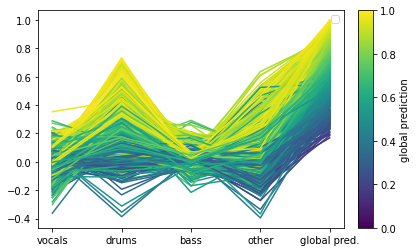

--- Execution Time: 07:45 seconds ---


In [13]:
start_time = time.time()
preprocess_instance_snippet(dataset_path, "Electronic", model_path)
print(f"--- Execution Time: {time.strftime('%M:%S', time.gmtime(time.time() - start_time))} seconds ---")

Concatenate Test Data...
Snippet number 1
Predicted Old-Time / Historic with confidence of 0.9998387098312378
Model predictet Classical for permutation (0, 0, 0, 1); Target label with 0.001468106172978878
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.002746366895735264
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.01953011006116867
Model predictet Experimental for permutation (0, 1, 0, 0); Target label with 0.0037598018534481525
Model predictet Classical for permutation (0, 1, 0, 1); Target label with 0.003607086604461074
Model predictet Experimental for permutation (0, 1, 1, 0); Target label with 0.004909648094326258
Model predictet Experimental for permutation (0, 1, 1, 1); Target label with 0.04425457492470741
Model predictet Old-Time / Historic for permutation (1, 0, 0, 0); Target label with 0.6642965078353882
Model predictet Old-Time / Historic for permutation (1, 0, 0, 1); Target label with 0.9733203053474426
Model pre

Predicted Old-Time / Historic with confidence of 0.9999380111694336
Model predictet Old-Time / Historic for permutation (0, 0, 0, 1); Target label with 0.2922574281692505
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.005317537114024162
Model predictet Old-Time / Historic for permutation (0, 0, 1, 1); Target label with 0.9806162118911743
Model predictet Experimental for permutation (0, 1, 0, 0); Target label with 0.18160103261470795
Model predictet Old-Time / Historic for permutation (0, 1, 0, 1); Target label with 0.9943617582321167
Model predictet Old-Time / Historic for permutation (0, 1, 1, 0); Target label with 0.2725091576576233
Model predictet Old-Time / Historic for permutation (0, 1, 1, 1); Target label with 0.9999184608459473
Model predictet Instrumental for permutation (1, 0, 0, 0); Target label with 0.0016262298449873924
Model predictet Old-Time / Historic for permutation (1, 0, 0, 1); Target label with 0.44262421131134033
Model predictet Class

Model predictet Old-Time / Historic for permutation (1, 1, 1, 0); Target label with 0.9999290704727173
Snippet number 13
Predicted Old-Time / Historic with confidence of 1.0
Model predictet Old-Time / Historic for permutation (0, 0, 0, 1); Target label with 0.6450853943824768
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.004886481445282698
Model predictet Old-Time / Historic for permutation (0, 0, 1, 1); Target label with 0.9963548183441162
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.0028140931390225887
Model predictet Old-Time / Historic for permutation (0, 1, 0, 1); Target label with 0.9355071783065796
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.0038409035187214613
Model predictet Old-Time / Historic for permutation (0, 1, 1, 1); Target label with 0.9973024129867554
Model predictet Old-Time / Historic for permutation (1, 0, 0, 0); Target label with 0.9999642372131348
Model predictet Old-T

Model predictet Old-Time / Historic for permutation (1, 0, 0, 1); Target label with 0.9969112277030945
Model predictet Old-Time / Historic for permutation (1, 0, 1, 0); Target label with 0.9845941066741943
Model predictet Old-Time / Historic for permutation (1, 0, 1, 1); Target label with 0.9912849068641663
Model predictet Old-Time / Historic for permutation (1, 1, 0, 0); Target label with 0.9734222292900085
Model predictet Old-Time / Historic for permutation (1, 1, 0, 1); Target label with 0.9997566342353821
Model predictet Old-Time / Historic for permutation (1, 1, 1, 0); Target label with 0.9893747568130493
Snippet number 19
Predicted Old-Time / Historic with confidence of 0.9941748976707458
Model predictet Instrumental for permutation (0, 0, 0, 1); Target label with 0.0005466088769026101
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.0028122132644057274
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.006869217846542597
Mode

Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.003446979448199272
Model predictet Electronic for permutation (0, 1, 1, 1); Target label with 0.027253806591033936
Model predictet Old-Time / Historic for permutation (1, 0, 0, 0); Target label with 0.9992772936820984
Model predictet Old-Time / Historic for permutation (1, 0, 0, 1); Target label with 0.9999253749847412
Model predictet Old-Time / Historic for permutation (1, 0, 1, 0); Target label with 0.9999299049377441
Model predictet Old-Time / Historic for permutation (1, 0, 1, 1); Target label with 0.9999958276748657
Model predictet Old-Time / Historic for permutation (1, 1, 0, 0); Target label with 0.995486319065094
Model predictet Old-Time / Historic for permutation (1, 1, 0, 1); Target label with 0.9998100399971008
Model predictet Old-Time / Historic for permutation (1, 1, 1, 0); Target label with 0.9990795850753784
Snippet number 25
Predicted Old-Time / Historic with confidence of 1.0
Model predictet E

Model predictet Old-Time / Historic for permutation (0, 1, 0, 1); Target label with 0.6926053762435913
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.0029616488609462976
Model predictet Old-Time / Historic for permutation (0, 1, 1, 1); Target label with 0.9999891519546509
Model predictet Old-Time / Historic for permutation (1, 0, 0, 0); Target label with 0.9995768666267395
Model predictet Old-Time / Historic for permutation (1, 0, 0, 1); Target label with 0.9999995231628418
Model predictet Old-Time / Historic for permutation (1, 0, 1, 0); Target label with 0.9999711513519287
Model predictet Old-Time / Historic for permutation (1, 0, 1, 1); Target label with 1.0
Model predictet Old-Time / Historic for permutation (1, 1, 0, 0); Target label with 0.9996951818466187
Model predictet Old-Time / Historic for permutation (1, 1, 0, 1); Target label with 1.0
Model predictet Old-Time / Historic for permutation (1, 1, 1, 0); Target label with 0.9999490976333618
Snippe

Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.0072968932799994946
Model predictet Old-Time / Historic for permutation (0, 1, 0, 1); Target label with 0.4527128040790558
Model predictet Experimental for permutation (0, 1, 1, 0); Target label with 0.015143608674407005
Model predictet Old-Time / Historic for permutation (0, 1, 1, 1); Target label with 0.9315680265426636
Model predictet Old-Time / Historic for permutation (1, 0, 0, 0); Target label with 0.9998975992202759
Model predictet Old-Time / Historic for permutation (1, 0, 0, 1); Target label with 0.9999992847442627
Model predictet Old-Time / Historic for permutation (1, 0, 1, 0); Target label with 0.9999908208847046
Model predictet Old-Time / Historic for permutation (1, 0, 1, 1); Target label with 1.0
Model predictet Old-Time / Historic for permutation (1, 1, 0, 0); Target label with 0.9999986886978149
Model predictet Old-Time / Historic for permutation (1, 1, 0, 1); Target label with 1.0
Model predi

Model predictet Old-Time / Historic for permutation (0, 0, 1, 1); Target label with 0.9103866815567017
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.0005476750084199011
Model predictet Old-Time / Historic for permutation (0, 1, 0, 1); Target label with 0.44673046469688416
Model predictet Experimental for permutation (0, 1, 1, 0); Target label with 0.0003474752593319863
Model predictet Old-Time / Historic for permutation (0, 1, 1, 1); Target label with 0.9801084399223328
Model predictet Old-Time / Historic for permutation (1, 0, 0, 0); Target label with 0.9999494552612305
Model predictet Old-Time / Historic for permutation (1, 0, 0, 1); Target label with 0.9999998807907104
Model predictet Old-Time / Historic for permutation (1, 0, 1, 0); Target label with 0.9999840259552002
Model predictet Old-Time / Historic for permutation (1, 0, 1, 1); Target label with 1.0
Model predictet Old-Time / Historic for permutation (1, 1, 0, 0); Target label with 0.99998104572

Model predictet Old-Time / Historic for permutation (1, 1, 1, 0); Target label with 0.9916965961456299
Snippet number 48
Predicted Old-Time / Historic with confidence of 0.928977906703949
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.0015843530418351293
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.002891343552619219
Model predictet Classical for permutation (0, 0, 1, 1); Target label with 0.002349607879295945
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.2168864607810974
Model predictet Old-Time / Historic for permutation (0, 1, 0, 1); Target label with 0.6300150752067566
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.270866334438324
Model predictet Experimental for permutation (0, 1, 1, 1); Target label with 0.2501398026943207
Model predictet Experimental for permutation (1, 0, 0, 0); Target label with 0.13522155582904816
Model predictet Old-Time / Historic for

Model predictet Old-Time / Historic for permutation (1, 0, 0, 0); Target label with 0.9992017149925232
Model predictet Old-Time / Historic for permutation (1, 0, 0, 1); Target label with 0.999685525894165
Model predictet Old-Time / Historic for permutation (1, 0, 1, 0); Target label with 0.9999451637268066
Model predictet Old-Time / Historic for permutation (1, 0, 1, 1); Target label with 0.9999955892562866
Model predictet Old-Time / Historic for permutation (1, 1, 0, 0); Target label with 0.9997667670249939
Model predictet Old-Time / Historic for permutation (1, 1, 0, 1); Target label with 0.999982476234436
Model predictet Old-Time / Historic for permutation (1, 1, 1, 0); Target label with 0.9999897480010986
Snippet number 54
Predicted Old-Time / Historic with confidence of 0.9999837875366211
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.0005824709660373628
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.003768046386539936


Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.001916662324219942
Model predictet Old-Time / Historic for permutation (0, 0, 1, 1); Target label with 0.9996440410614014
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.008289754390716553
Model predictet Old-Time / Historic for permutation (0, 1, 0, 1); Target label with 0.9993730187416077
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.006203780882060528
Model predictet Old-Time / Historic for permutation (0, 1, 1, 1); Target label with 0.9998420476913452
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.00824576336890459
Model predictet Old-Time / Historic for permutation (1, 0, 0, 1); Target label with 0.9999897480010986
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.05323825404047966
Model predictet Old-Time / Historic for permutation (1, 0, 1, 1); Target label with 0.9999991655349731
Model p

Predicted Old-Time / Historic with confidence of 0.9778974652290344
Model predictet Experimental for permutation (0, 0, 0, 1); Target label with 0.0027530700899660587
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.00541082676500082
Model predictet Experimental for permutation (0, 0, 1, 1); Target label with 0.008282163180410862
Model predictet Instrumental for permutation (0, 1, 0, 0); Target label with 0.0009536707075312734
Model predictet Experimental for permutation (0, 1, 0, 1); Target label with 0.004771295934915543
Model predictet Instrumental for permutation (0, 1, 1, 0); Target label with 0.0021383846178650856
Model predictet Experimental for permutation (0, 1, 1, 1); Target label with 0.007000101264566183
Model predictet Old-Time / Historic for permutation (1, 0, 0, 0); Target label with 0.8361013531684875
Model predictet Old-Time / Historic for permutation (1, 0, 0, 1); Target label with 0.9934074878692627
Model predictet Old-Time / Historic for 

Predicted Old-Time / Historic with confidence of 0.9996004700660706
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.005928585305809975
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.007030900567770004
Model predictet Old-Time / Historic for permutation (0, 0, 1, 1); Target label with 0.9975656270980835
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.0010661839041858912
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.003916732966899872
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.002321725245565176
Model predictet Old-Time / Historic for permutation (0, 1, 1, 1); Target label with 0.9949297308921814
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.0007809188100509346
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.007962682284414768
Model predictet Electronic for permutation (1, 0, 1,

Model predictet Old-Time / Historic for permutation (1, 0, 1, 0); Target label with 0.4259943664073944
Model predictet Old-Time / Historic for permutation (1, 0, 1, 1); Target label with 0.9999996423721313
Model predictet Old-Time / Historic for permutation (1, 1, 0, 0); Target label with 0.3254557251930237
Model predictet Old-Time / Historic for permutation (1, 1, 0, 1); Target label with 0.9996670484542847
Model predictet Old-Time / Historic for permutation (1, 1, 1, 0); Target label with 0.35131192207336426
Snippet number 78
Predicted Old-Time / Historic with confidence of 1.0
Model predictet Old-Time / Historic for permutation (0, 0, 0, 1); Target label with 0.923080325126648
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.004573298618197441
Model predictet Old-Time / Historic for permutation (0, 0, 1, 1); Target label with 0.999982476234436
Model predictet Experimental for permutation (0, 1, 0, 0); Target label with 0.019565854221582413
Model predictet

Model predictet Experimental for permutation (0, 1, 0, 0); Target label with 0.001780928228981793
Model predictet Experimental for permutation (0, 1, 0, 1); Target label with 0.0005311835557222366
Model predictet Experimental for permutation (0, 1, 1, 0); Target label with 0.0029421134386211634
Model predictet Experimental for permutation (0, 1, 1, 1); Target label with 0.002239461522549391
Model predictet Old-Time / Historic for permutation (1, 0, 0, 0); Target label with 0.8308407068252563
Model predictet Old-Time / Historic for permutation (1, 0, 0, 1); Target label with 0.9612804651260376
Model predictet Old-Time / Historic for permutation (1, 0, 1, 0); Target label with 0.9958251714706421
Model predictet Old-Time / Historic for permutation (1, 0, 1, 1); Target label with 0.9958949089050293
Model predictet Old-Time / Historic for permutation (1, 1, 0, 0); Target label with 0.9083662629127502
Model predictet Old-Time / Historic for permutation (1, 1, 0, 1); Target label with 0.99391

Model predictet Old-Time / Historic for permutation (0, 1, 0, 1); Target label with 0.9705718755722046
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.0026767489034682512
Model predictet Old-Time / Historic for permutation (0, 1, 1, 1); Target label with 0.9806420207023621
Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 0.028981201350688934
Model predictet Old-Time / Historic for permutation (1, 0, 0, 1); Target label with 0.9990078806877136
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 0.13748164474964142
Model predictet Old-Time / Historic for permutation (1, 0, 1, 1); Target label with 0.9995386600494385
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.2523323595523834
Model predictet Old-Time / Historic for permutation (1, 1, 0, 1); Target label with 0.9999672174453735
Model predictet Old-Time / Historic for permutation (1, 1, 1, 0); Target label with 0.48765477538108826

Predicted Old-Time / Historic with confidence of 0.9999947547912598
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.20509612560272217
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.0017331663984805346
Model predictet Old-Time / Historic for permutation (0, 0, 1, 1); Target label with 0.30627331137657166
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.0013305844040587544
Model predictet Old-Time / Historic for permutation (0, 1, 0, 1); Target label with 0.8845353126525879
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.0012706108391284943
Model predictet Old-Time / Historic for permutation (0, 1, 1, 1); Target label with 0.8915430307388306
Model predictet Old-Time / Historic for permutation (1, 0, 0, 0); Target label with 0.9438952207565308
Model predictet Old-Time / Historic for permutation (1, 0, 0, 1); Target label with 0.9998071789741516
Model predictet Old-Time / His

Model predictet Old-Time / Historic for permutation (1, 0, 0, 1); Target label with 0.9999786615371704
Model predictet Old-Time / Historic for permutation (1, 0, 1, 0); Target label with 0.5308958292007446
Model predictet Old-Time / Historic for permutation (1, 0, 1, 1); Target label with 0.999992847442627
Model predictet Old-Time / Historic for permutation (1, 1, 0, 0); Target label with 0.6065489053726196
Model predictet Old-Time / Historic for permutation (1, 1, 0, 1); Target label with 0.9999992847442627
Model predictet Old-Time / Historic for permutation (1, 1, 1, 0); Target label with 0.8047923445701599
Snippet number 103
Predicted Old-Time / Historic with confidence of 1.0
Model predictet Old-Time / Historic for permutation (0, 0, 0, 1); Target label with 0.6353293061256409
Model predictet Instrumental for permutation (0, 0, 1, 0); Target label with 0.0009476703125983477
Model predictet Old-Time / Historic for permutation (0, 0, 1, 1); Target label with 0.9985612034797668
Model 

Model predictet Old-Time / Historic for permutation (0, 0, 1, 1); Target label with 0.9999992847442627
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.009967471472918987
Model predictet Old-Time / Historic for permutation (0, 1, 0, 1); Target label with 0.9999949932098389
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.020027179270982742
Model predictet Old-Time / Historic for permutation (0, 1, 1, 1); Target label with 1.0
Model predictet Old-Time / Historic for permutation (1, 0, 0, 0); Target label with 0.9780969023704529
Model predictet Old-Time / Historic for permutation (1, 0, 0, 1); Target label with 1.0
Model predictet Old-Time / Historic for permutation (1, 0, 1, 0); Target label with 0.998676598072052
Model predictet Old-Time / Historic for permutation (1, 0, 1, 1); Target label with 1.0
Model predictet Old-Time / Historic for permutation (1, 1, 0, 0); Target label with 0.9978530406951904
Model predictet Old-Time / His

Predicted International with confidence of 0.7435910701751709
Not Target Genre ... continue
Snippet number 116
Predicted International with confidence of 0.47058945894241333
Not Target Genre ... continue
Snippet number 117
Predicted Spoken with confidence of 0.3130883574485779
Not Target Genre ... continue
Snippet number 118
Predicted Old-Time / Historic with confidence of 0.9999996423721313
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.001123158261179924
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.005036721937358379
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.004423561040312052
Model predictet Experimental for permutation (0, 1, 0, 0); Target label with 0.006398817058652639
Model predictet Experimental for permutation (0, 1, 0, 1); Target label with 0.010230262763798237
Model predictet Experimental for permutation (0, 1, 1, 0); Target label with 0.0034380999859422445
Model predictet Experi

Model predictet Old-Time / Historic for permutation (1, 1, 0, 1); Target label with 1.0
Model predictet Old-Time / Historic for permutation (1, 1, 1, 0); Target label with 0.9999960660934448
Snippet number 124
Predicted Old-Time / Historic with confidence of 1.0
Model predictet Electronic for permutation (0, 0, 0, 1); Target label with 0.023553669452667236
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.0033986889757215977
Model predictet Old-Time / Historic for permutation (0, 0, 1, 1); Target label with 0.7320977449417114
Model predictet Experimental for permutation (0, 1, 0, 0); Target label with 0.005208518821746111
Model predictet Old-Time / Historic for permutation (0, 1, 0, 1); Target label with 0.7505466938018799
Model predictet Experimental for permutation (0, 1, 1, 0); Target label with 0.004946175962686539
Model predictet Old-Time / Historic for permutation (0, 1, 1, 1); Target label with 0.9947303533554077
Model predictet Old-Time / Historic for

Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.013186660595238209
Model predictet Old-Time / Historic for permutation (0, 1, 1, 1); Target label with 0.9033915996551514
Model predictet Old-Time / Historic for permutation (1, 0, 0, 0); Target label with 0.9779456853866577
Model predictet Old-Time / Historic for permutation (1, 0, 0, 1); Target label with 0.9995567202568054
Model predictet Old-Time / Historic for permutation (1, 0, 1, 0); Target label with 0.999092698097229
Model predictet Old-Time / Historic for permutation (1, 0, 1, 1); Target label with 0.9999985694885254
Model predictet Old-Time / Historic for permutation (1, 1, 0, 0); Target label with 0.9982317090034485
Model predictet Old-Time / Historic for permutation (1, 1, 0, 1); Target label with 0.9999806880950928
Model predictet Old-Time / Historic for permutation (1, 1, 1, 0); Target label with 0.9996823072433472
Snippet number 130
Predicted Old-Time / Historic with confidence of 0.99997484683

Predicted Old-Time / Historic with confidence of 0.9999898672103882
Model predictet Old-Time / Historic for permutation (0, 0, 0, 1); Target label with 0.3337140679359436
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.0033135036937892437
Model predictet Electronic for permutation (0, 0, 1, 1); Target label with 0.19370520114898682
Model predictet Experimental for permutation (0, 1, 0, 0); Target label with 0.02854723297059536
Model predictet Old-Time / Historic for permutation (0, 1, 0, 1); Target label with 0.9849328398704529
Model predictet Experimental for permutation (0, 1, 1, 0); Target label with 0.041175249963998795
Model predictet Old-Time / Historic for permutation (0, 1, 1, 1); Target label with 0.9614552855491638
Model predictet Old-Time / Historic for permutation (1, 0, 0, 0); Target label with 0.34121909737586975
Model predictet Old-Time / Historic for permutation (1, 0, 0, 1); Target label with 0.9996640682220459
Model predictet Old-Time / Hi

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.011479442939162254
Model predictet Old-Time / Historic for permutation (0, 0, 1, 1); Target label with 0.9999932050704956
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.02675130032002926
Model predictet Old-Time / Historic for permutation (0, 1, 0, 1); Target label with 0.999824583530426
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.07219675183296204
Model predictet Old-Time / Historic for permutation (0, 1, 1, 1); Target label with 1.0
Model predictet Classical for permutation (1, 0, 0, 0); Target label with 0.00787537544965744
Model predictet Old-Time / Historic for permutation (1, 0, 0, 1); Target label with 0.9995445609092712
Model predictet Instrumental for permutation (1, 0, 1, 0); Target label with 0.14453986287117004
Model predictet Old-Time / Historic for permutation (1, 0, 1, 1); Target label with 1.0
Model predictet Old-Time / Historic for

Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.0022459973115473986
Model predictet Old-Time / Historic for permutation (0, 0, 1, 1); Target label with 0.5061702132225037
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.0019178343936800957
Model predictet Electronic for permutation (0, 1, 0, 1); Target label with 0.013571113348007202
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.0025385504122823477
Model predictet Old-Time / Historic for permutation (0, 1, 1, 1); Target label with 0.5127137303352356
Model predictet Instrumental for permutation (1, 0, 0, 0); Target label with 0.019321857020258904
Model predictet Old-Time / Historic for permutation (1, 0, 0, 1); Target label with 0.9230674505233765
Model predictet Instrumental for permutation (1, 0, 1, 0); Target label with 0.14989866316318512
Model predictet Old-Time / Historic for permutation (1, 0, 1, 1); Target label with 0.9979078769683838
Model 

Model predictet Old-Time / Historic for permutation (1, 1, 0, 1); Target label with 0.911607027053833
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.00039366548298858106
Snippet number 153
Predicted Old-Time / Historic with confidence of 0.9976317882537842
Model predictet Old-Time / Historic for permutation (0, 0, 0, 1); Target label with 0.5190408229827881
Model predictet Electronic for permutation (0, 0, 1, 0); Target label with 0.0017506824806332588
Model predictet Old-Time / Historic for permutation (0, 0, 1, 1); Target label with 0.9879937171936035
Model predictet Electronic for permutation (0, 1, 0, 0); Target label with 0.0029183761216700077
Model predictet Old-Time / Historic for permutation (0, 1, 0, 1); Target label with 0.7075533866882324
Model predictet Electronic for permutation (0, 1, 1, 0); Target label with 0.0038280223961919546
Model predictet Old-Time / Historic for permutation (0, 1, 1, 1); Target label with 0.9956982135772705


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

Model predictet Electronic for permutation (1, 0, 0, 0); Target label with 4.1597024392103776e-05
Model predictet Electronic for permutation (1, 0, 0, 1); Target label with 0.18931250274181366
Model predictet Electronic for permutation (1, 0, 1, 0); Target label with 9.399017289979383e-05
Model predictet Old-Time / Historic for permutation (1, 0, 1, 1); Target label with 0.9725623726844788
Model predictet Electronic for permutation (1, 1, 0, 0); Target label with 0.0007465926464647055
Model predictet Old-Time / Historic for permutation (1, 1, 0, 1); Target label with 0.8132733702659607
Model predictet Electronic for permutation (1, 1, 1, 0); Target label with 0.0012550859246402979
Number of Explanations: 146


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

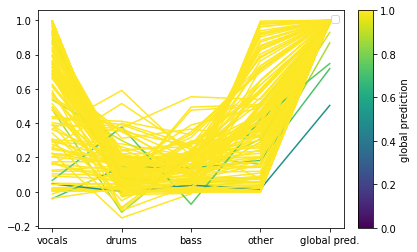

--- Execution Time: 00:59 seconds ---


In [14]:
start_time = time.time()
preprocess_instance_snippet(dataset_path, "Old-Time / Historic", model_path)
print(f"--- Execution Time: {time.strftime('%M:%S', time.gmtime(time.time() - start_time))} seconds ---")